In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import math

class PatchEmbedding(nn.Module):
    """将影像分割为patches并进行嵌入"""
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.in_channels = in_channels
        
        # 使用卷积进行patch嵌入
        self.projection = nn.Conv2d(
            in_channels, embed_dim, 
            kernel_size=patch_size, stride=patch_size
        )
        
    def forward(self, x):
        # x: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        
        # 重塑为 (B*T, C, H, W) 进行patch嵌入
        x = x.view(B * T, C, H, W)
        
        # 应用卷积得到 (B*T, embed_dim, num_patches_h, num_patches_w)
        x = self.projection(x)
        
        # 展平spatial维度: (B*T, embed_dim, num_patches)
        x = x.flatten(2)
        
        # 转置: (B*T, num_patches, embed_dim)
        x = x.transpose(1, 2)
        
        # 重塑回时序维度: (B, T, num_patches, embed_dim)
        x = x.view(B, T, -1, x.size(-1))
        
        return x

class TemporalPositionalEncoding(nn.Module):
    """时间位置编码"""
    def __init__(self, embed_dim, max_seq_len=100):
        super().__init__()
        self.embed_dim = embed_dim
        
        # 创建时间位置编码
        pe = torch.zeros(max_seq_len, embed_dim)
        position = torch.arange(0, max_seq_len).unsqueeze(1).float()
        
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() *
                           -(math.log(10000.0) / embed_dim))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x: (B, T, num_patches, embed_dim)
        B, T, N, D = x.shape
        
        # 为每个时间步添加时间位置编码
        temporal_pe = self.pe[:T].unsqueeze(0).unsqueeze(2)  # (1, T, 1, D)
        temporal_pe = temporal_pe.expand(B, T, N, D)
        
        return x + temporal_pe

class SpatialPositionalEncoding(nn.Module):
    """空间位置编码"""
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.spatial_pe = nn.Parameter(torch.randn(1, 1, num_patches, embed_dim))
        
    def forward(self, x):
        # x: (B, T, num_patches, embed_dim)
        return x + self.spatial_pe

class MaskTokenEmbedding(nn.Module):
    """掩码token嵌入"""
    def __init__(self, embed_dim):
        super().__init__()
        self.mask_token = nn.Parameter(torch.randn(1, 1, 1, embed_dim))
        
    def forward(self, x, mask):
        # x: (B, T, num_patches, embed_dim)
        # mask: (B, num_patches) - 1表示保留，0表示掩码
        B, T, N, D = x.shape
        
        # 扩展mask到时间维度
        mask = mask.unsqueeze(1).expand(B, T, N)  # (B, T, N)
        
        # 创建掩码token
        mask_tokens = self.mask_token.expand(B, T, N, D)
        
        # 应用掩码
        mask = mask.unsqueeze(-1)  # (B, T, N, 1)
        x_masked = x * mask + mask_tokens * (1 - mask)
        
        return x_masked

class TransformerBlock(nn.Module):
    """Transformer Block"""
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim, num_heads, dropout=dropout, batch_first=True
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # Self-attention
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out
        
        # MLP
        x = x + self.mlp(self.norm2(x))
        
        return x

class MAEEncoder(nn.Module):
    """MAE编码器"""
    def __init__(self, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0):
        super().__init__()
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x, mask):
        # x: (B, T, num_patches, embed_dim)
        # mask: (B, num_patches)
        B, T, N, D = x.shape
        
        # 只保留未掩码的patches进行编码
        visible_patches = []
        visible_indices = []
        
        for b in range(B):
            visible_idx = torch.nonzero(mask[b]).squeeze(-1)  # 获取可见patch索引
            if len(visible_idx) > 0:
                visible_patch = x[b, :, visible_idx, :]  # (T, num_visible, D)
                visible_patches.append(visible_patch)
                visible_indices.append(visible_idx)
        
        if not visible_patches:
            return torch.zeros(B, T, 0, D, device=x.device)
        
        # 将所有可见patches合并处理
        # 重塑为 (B*T, num_visible_total, D)
        x_visible_list = []
        for i, patches in enumerate(visible_patches):
            T_curr, num_vis, D_curr = patches.shape
            x_vis = patches.view(T_curr * num_vis, D_curr)  # (T*num_vis, D)
            x_visible_list.append(x_vis)
        
        # 为了简化，我们处理每个batch项目
        encoded_patches = []
        for b, x_vis in enumerate(visible_patches):
            T_curr, num_vis, D_curr = x_vis.shape
            x_flat = x_vis.view(-1, D_curr)  # (T*num_vis, D)
            
            # 通过transformer blocks
            for block in self.blocks:
                x_flat = block(x_flat.unsqueeze(0)).squeeze(0)  # 添加batch维度处理
            
            x_encoded = x_flat.view(T_curr, num_vis, D_curr)
            encoded_patches.append(x_encoded)
        
        return encoded_patches, visible_indices

class MAEDecoder(nn.Module):
    """MAE解码器（非对称，更轻量）"""
    def __init__(self, encoder_embed_dim=768, decoder_embed_dim=512, 
                 depth=8, num_heads=16, mlp_ratio=4.0, patch_size=16, in_channels=3):
        super().__init__()
        self.decoder_embed_dim = decoder_embed_dim
        self.patch_size = patch_size
        self.in_channels = in_channels
        
        # 编码器到解码器的投影
        self.decoder_embed = nn.Linear(encoder_embed_dim, decoder_embed_dim)
        
        # 解码器的掩码token
        self.mask_token = nn.Parameter(torch.randn(1, 1, decoder_embed_dim))
        
        # 解码器transformer blocks
        self.decoder_blocks = nn.ModuleList([
            TransformerBlock(decoder_embed_dim, num_heads, mlp_ratio)
            for _ in range(depth)
        ])
        
        self.decoder_norm = nn.LayerNorm(decoder_embed_dim)
        
        # 预测头：将tokens转换为像素值
        self.decoder_pred = nn.Linear(
            decoder_embed_dim, 
            patch_size * patch_size * in_channels
        )
        
        # 解码器位置编码
        self.decoder_pos_embed = nn.Parameter(torch.randn(1, 1, 1, decoder_embed_dim))
        
    def forward(self, encoded_patches, visible_indices, mask, num_patches, time_steps):
        # 重构完整的token序列
        B = len(encoded_patches)
        T = time_steps
        N = num_patches
        D = self.decoder_embed_dim
        
        # 创建解码器输入
        x_full = torch.zeros(B, T, N, D, device=encoded_patches[0].device)
        
        for b in range(B):
            if len(visible_indices[b]) > 0:
                # 投影编码器输出到解码器维度
                encoded = self.decoder_embed(encoded_patches[b])  # (T, num_visible, D)
                x_full[b, :, visible_indices[b], :] = encoded
        
        # 为掩码位置添加mask tokens
        mask_expanded = mask.unsqueeze(1).unsqueeze(-1).expand(B, T, N, D)
        mask_tokens = self.mask_token.expand(B, T, N, D)
        x_full = x_full * mask_expanded + mask_tokens * (1 - mask_expanded)
        
        # 添加位置编码
        x_full = x_full + self.decoder_pos_embed
        
        # 重塑为 (B*T*N, D) 进行处理
        x_flat = x_full.view(-1, D)
        
        # 通过解码器blocks
        for block in self.decoder_blocks:
            x_flat = block(x_flat.unsqueeze(0)).squeeze(0)
        
        x_flat = self.decoder_norm(x_flat)
        
        # 预测像素值
        pred = self.decoder_pred(x_flat)  # (B*T*N, patch_size^2 * C)
        
        # 重塑回原始维度
        pred = pred.view(B, T, N, -1)
        
        return pred

class TemporalSpatialMAE(nn.Module):
    """时空MAE模型"""
    def __init__(self, img_size=224, patch_size=16, in_channels=3,
                 encoder_embed_dim=768, encoder_depth=12, encoder_num_heads=12,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4.0):
        super().__init__()
        
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_patches = (img_size // patch_size) ** 2
        
        # Patch嵌入
        self.patch_embed = PatchEmbedding(
            img_size, patch_size, in_channels, encoder_embed_dim
        )
        
        # 位置编码
        self.temporal_pos_embed = TemporalPositionalEncoding(encoder_embed_dim)
        self.spatial_pos_embed = SpatialPositionalEncoding(
            self.num_patches, encoder_embed_dim
        )
        
        # 掩码token嵌入
        self.mask_token_embed = MaskTokenEmbedding(encoder_embed_dim)
        
        # 编码器和解码器
        self.encoder = MAEEncoder(
            encoder_embed_dim, encoder_depth, encoder_num_heads, mlp_ratio
        )
        
        self.decoder = MAEDecoder(
            encoder_embed_dim, decoder_embed_dim, decoder_depth, 
            decoder_num_heads, mlp_ratio, patch_size, in_channels
        )
        
    def patchify(self, imgs):
        """将图像转换为patches"""
        # imgs: (B, T, C, H, W)
        B, T, C, H, W = imgs.shape
        p = self.patch_size
        
        # 重塑为patches
        x = imgs.view(B, T, C, H // p, p, W // p, p)
        x = x.permute(0, 1, 3, 5, 4, 6, 2)  # (B, T, H//p, W//p, p, p, C)
        x = x.contiguous().view(B, T, -1, p * p * C)  # (B, T, N, p^2*C)
        
        return x
    
    def unpatchify(self, x):
        """将patches转换回图像"""
        # x: (B, T, N, p^2*C)
        B, T, N, _ = x.shape
        p = self.patch_size
        c = self.in_channels
        h = w = int(N ** 0.5)
        
        x = x.view(B, T, h, w, p, p, c)
        x = x.permute(0, 1, 6, 2, 4, 3, 5)  # (B, T, C, h, p, w, p)
        x = x.contiguous().view(B, T, c, h * p, w * p)
        
        return x
    
    def forward(self, imgs, mask_ratio=0.75, custom_mask=None):
        """
        前向传播
        Args:
            imgs: (B, T, C, H, W) - 输入影像序列
            mask_ratio: float - 掩码比例
            custom_mask: (B, num_patches) - 自定义掩码（可选）
        """
        B, T, C, H, W = imgs.shape
        
        # 1. Patch嵌入
        x = self.patch_embed(imgs)  # (B, T, N, D)
        
        # 2. 添加位置编码
        x = self.temporal_pos_embed(x)  # 时间位置编码
        x = self.spatial_pos_embed(x)   # 空间位置编码
        
        # 3. 生成或使用掩码
        if custom_mask is not None:
            mask = custom_mask
        else:
            # 随机生成掩码
            num_keep = int(self.num_patches * (1 - mask_ratio))
            mask = torch.zeros(B, self.num_patches, device=imgs.device)
            for b in range(B):
                perm = torch.randperm(self.num_patches, device=imgs.device)
                mask[b, perm[:num_keep]] = 1
        
        # 4. 应用掩码token
        x_masked = self.mask_token_embed(x, mask)
        
        # 5. 编码器
        encoded_patches, visible_indices = self.encoder(x_masked, mask)
        
        # 6. 解码器
        pred = self.decoder(encoded_patches, visible_indices, mask, 
                          self.num_patches, T)
        
        return pred, mask
    
    def forward_loss(self, imgs, pred, mask):
        """计算重构损失"""
        # 将图像转换为patches
        target = self.patchify(imgs)  # (B, T, N, p^2*C)
        
        # 只计算掩码区域的损失
        mask_expanded = (1 - mask).unsqueeze(1).unsqueeze(-1)  # (B, 1, N, 1)
        mask_expanded = mask_expanded.expand_as(target)
        
        loss = F.mse_loss(pred, target, reduction='none')
        loss = (loss * mask_expanded).sum() / mask_expanded.sum()
        
        return loss

# 使用示例和训练函数
def create_model(img_size=224, patch_size=16, in_channels=3):
    """创建模型"""
    model = TemporalSpatialMAE(
        img_size=img_size,
        patch_size=patch_size,
        in_channels=in_channels,
        encoder_embed_dim=768,
        encoder_depth=12,
        encoder_num_heads=12,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16
    )
    return model

def train_step(model, imgs, optimizer, mask_ratio=0.75, custom_mask=None):
    """训练步骤"""
    model.train()
    optimizer.zero_grad()
    
    # 前向传播
    pred, mask = model(imgs, mask_ratio=mask_ratio, custom_mask=custom_mask)
    
    # 计算损失
    loss = model.forward_loss(imgs, pred, mask)
    
    # 反向传播
    loss.backward()
    optimizer.step()
    
    return loss.item()

# 测试代码
if __name__ == "__main__":
    # 创建模型
    # RGB图像
    model_rgb = create_model(img_size=224, patch_size=16, in_channels=3)
    
    # 灰度图像
    model_gray = create_model(img_size=224, patch_size=16, in_channels=1)
    
    # 测试数据
    batch_size = 2
    time_steps = 8
    
    # RGB测试
    imgs_rgb = torch.randn(batch_size, time_steps, 3, 224, 224)
    pred_rgb, mask_rgb = model_rgb(imgs_rgb, mask_ratio=0.75)
    print(f"RGB - Input: {imgs_rgb.shape}, Prediction: {pred_rgb.shape}, Mask: {mask_rgb.shape}")
    
    # 灰度测试
    imgs_gray = torch.randn(batch_size, time_steps, 1, 224, 224)
    pred_gray, mask_gray = model_gray(imgs_gray, mask_ratio=0.75)
    print(f"Grayscale - Input: {imgs_gray.shape}, Prediction: {pred_gray.shape}, Mask: {mask_gray.shape}")
    
    # 计算损失
    loss_rgb = model_rgb.forward_loss(imgs_rgb, pred_rgb, mask_rgb)
    loss_gray = model_gray.forward_loss(imgs_gray, pred_gray, mask_gray)
    
    print(f"RGB Loss: {loss_rgb:.4f}")
    print(f"Grayscale Loss: {loss_gray:.4f}")
    
    print(f"RGB Model Parameters: {sum(p.numel() for p in model_rgb.parameters()):,}")
    print(f"Grayscale Model Parameters: {sum(p.numel() for p in model_gray.parameters()):,}")

RGB - Input: torch.Size([2, 8, 3, 224, 224]), Prediction: torch.Size([2, 8, 196, 768]), Mask: torch.Size([2, 196])
Grayscale - Input: torch.Size([2, 8, 1, 224, 224]), Prediction: torch.Size([2, 8, 196, 256]), Mask: torch.Size([2, 196])
RGB Loss: 1.3242
Grayscale Loss: 1.3722
RGB Model Parameters: 111,806,720
Grayscale Model Parameters: 111,150,848


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
from typing import List, Tuple, Optional, Union

# 导入之前的MAE模型（假设已经定义）
# from temporal_spatial_mae import TemporalSpatialMAE, create_model

class MaskGenerator:
    """您提供的掩码生成器类"""
    def __init__(self, base_mask_array):
        """
        接收 base_mask_array，形状为 (H, W)，或者 xarray.DataArray。
        要求该掩码中值为 1 表示有效区域，0 表示无效。
        """
        if isinstance(base_mask_array, xr.DataArray):
            base_mask_array = base_mask_array.values

        if base_mask_array.ndim != 2:
            raise ValueError("base_mask_array 必须是二维数组 (H, W)")

        self.base_mask = (base_mask_array > 0).astype(np.uint8)
        self.height, self.width = self.base_mask.shape

        self.valid_coords = np.argwhere(self.base_mask == 1)
        if len(self.valid_coords) == 0:
            raise ValueError("base_mask 中没有有效像素")

        self.valid_rows = [min(self.valid_coords[:, 0]), max(self.valid_coords[:, 0])]
        self.valid_cols = [min(self.valid_coords[:, 1]), max(self.valid_coords[:, 1])]

    def generate_irregular_patch(self, size_range):
        """生成更像云形状的不规则补丁"""
        max_size = min(size_range[1], 
                      int((self.valid_rows[1]-self.valid_rows[0])*0.5),
                      int((self.valid_cols[1]-self.valid_cols[0])*0.5))
        
        if max_size < size_range[0]:
            return None
            
        # 确定云的大小（在指定范围内随机）
        size = np.random.randint(size_range[0], max_size + 1)
        
        # 创建画布 - 使用更大的画布确保云有足够的空间
        canvas_size = size * 3
        canvas = np.zeros((canvas_size, canvas_size), dtype=np.uint8)
        
        # 1. 生成多个重叠的圆形作为基础
        num_circles = np.random.randint(3, 7)  # 3-6个圆形
        centers = []
        radii = []
        
        # 在画布中心区域生成圆形
        for _ in range(num_circles):
            # 圆心在中心区域附近随机分布
            cx = canvas_size // 2 + np.random.randint(-size//2, size//2)
            cy = canvas_size // 2 + np.random.randint(-size//2, size//2)
            radius = np.random.randint(size//4, size//2)
            
            # 绘制圆形
            cv2.circle(canvas, (cx, cy), radius, 1, -1)
            centers.append((cx, cy))
            radii.append(radius)
        
        # 2. 应用高斯模糊使边缘更柔和
        blur_size = min(11, size//5)  # 模糊核大小
        if blur_size % 2 == 0:  # 确保奇数核
            blur_size += 1
        blurred = cv2.GaussianBlur(canvas.astype(np.float32), (blur_size, blur_size), 0)
        
        # 3. 二值化创建云形状
        # 使用自适应阈值保留模糊后的形状
        _, cloud_patch = cv2.threshold(blurred, 0.3, 1, cv2.THRESH_BINARY)
        cloud_patch = cloud_patch.astype(np.uint8)
        
        # 4. 形态学操作使云形状更自然
        kernel_size = max(3, size//10)
        if kernel_size % 2 == 0:
            kernel_size += 1
            
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        
        # 先膨胀使云更蓬松
        cloud_patch = cv2.dilate(cloud_patch, kernel, iterations=1)
        # 再腐蚀使边缘更自然
        cloud_patch = cv2.erode(cloud_patch, kernel, iterations=1)
        
        # 5. 裁剪非零区域
        rows, cols = np.where(cloud_patch)
        if len(rows) == 0:
            return None
            
        min_row, max_row = np.min(rows), np.max(rows)
        min_col, max_col = np.min(cols), np.max(cols)
        cropped = cloud_patch[min_row:max_row+1, min_col:max_col+1]
        
        # 6. 随机缩放增加变化性
        scale_factor = np.random.uniform(0.8, 1.2)
        new_h = max(1, int(cropped.shape[0] * scale_factor))
        new_w = max(1, int(cropped.shape[1] * scale_factor))
        
        if new_h > 0 and new_w > 0:
            resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
            # 重新二值化
            _, resized = cv2.threshold(resized, 0.5, 1, cv2.THRESH_BINARY)
            return resized.astype(np.uint8)
        
        return cropped

    def find_valid_position(self, patch):
        h, w = patch.shape
        if h >= self.height or w >= self.width:
            return None

        min_row = max(0, self.valid_rows[0])
        max_row = min(self.height - h, self.valid_rows[1])
        min_col = max(0, self.valid_cols[0])
        max_col = min(self.width - w, self.valid_cols[1])

        if min_row >= max_row or min_col >= max_col:
            return None

        x = np.random.randint(min_row, max_row)
        y = np.random.randint(min_col, max_col)

        valid_region = self.base_mask[x:x + h, y:y + w]
        overlap = patch & valid_region
        if np.sum(overlap) / np.sum(patch) > 0.9:
            return (x, y)
        return None

    def force_apply(self, mask, patch):
        for _ in range(50):
            x = np.random.randint(0, self.height - patch.shape[0])
            y = np.random.randint(0, self.width - patch.shape[1])
            mask[x:x + patch.shape[0], y:y + patch.shape[1]] |= patch
            return np.sum(patch)
        return 0

    def apply_patch(self, mask, patch, force=False):
        pos = self.find_valid_position(patch)
        if pos is None:
            return 0 if not force else self.force_apply(mask, patch)

        x, y = pos
        region = mask[x:x + patch.shape[0], y:y + patch.shape[1]]
        valid_region = self.base_mask[x:x + patch.shape[0], y:y + patch.shape[1]]

        new_pixels = np.sum((region == 0) & (patch == 1) & (valid_region == 1))
        if new_pixels > 0:
            mask[x:x + patch.shape[0], y:y + patch.shape[1]] = np.where(
                (region == 0) & (patch == 1) & (valid_region == 1),
                1,
                region
            )
        return new_pixels

    def generate_mask(self, missing_ratio, mode='speckled'):
        mask = np.zeros((self.height, self.width), dtype=np.uint8)
        target_pixels = int(missing_ratio * np.sum(self.base_mask))
        current_pixels = 0

        if mode == 'speckled':
            size_range = (20, 40)
            max_iter = max(2000, target_pixels * 2)
        elif mode == 'contiguous':
            size_range = (50, min(300, int(self.height * 0.4), int(self.width * 0.4)))
            max_iter = max(500, target_pixels // 10)
        else:
            raise ValueError("不支持的掩码模式")

        failure_count = 0
        for _ in range(max_iter):
            if current_pixels >= target_pixels:
                break

            patch = self.generate_irregular_patch(size_range)
            if patch is None:
                failure_count += 1
                continue

            added = self.apply_patch(mask, patch)
            if added == 0:
                failure_count += 1
            else:
                current_pixels += added
                failure_count = 0

            if failure_count >= 20:
                size_range = (max(3, size_range[0] // 2), max(5, size_range[1] // 2))
                failure_count = 0

        actual_ratio = np.sum(mask) / np.sum(self.base_mask)
        if abs(actual_ratio - missing_ratio) > 0.05:
            print(f"警告: 目标比例 {missing_ratio:.0%}, 实际达到 {actual_ratio:.0%}")

        return mask


class PatchMaskConverter:
    """将像素级掩码转换为patch级掩码"""
    def __init__(self, img_size: int, patch_size: int):
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches_per_dim = img_size // patch_size
        self.num_patches = self.num_patches_per_dim ** 2
    
    def pixel_mask_to_patch_mask(self, pixel_mask: np.ndarray, threshold: float = 0.5) -> torch.Tensor:
        """
        将像素级掩码转换为patch级掩码
        Args:
            pixel_mask: (H, W) - 像素级掩码，1表示掩码（缺失），0表示有效
            threshold: float - patch被认为是掩码的阈值（patch中掩码像素的比例）
        Returns:
            patch_mask: (num_patches,) - patch级掩码，1表示保留，0表示掩码
        """
        H, W = pixel_mask.shape
        p = self.patch_size
        
        # 确保尺寸匹配
        assert H == self.img_size and W == self.img_size, f"掩码尺寸 {H}x{W} 与图像尺寸 {self.img_size} 不匹配"
        
        patch_mask = torch.zeros(self.num_patches)
        
        for i in range(self.num_patches_per_dim):
            for j in range(self.num_patches_per_dim):
                # 提取patch区域
                patch_region = pixel_mask[i*p:(i+1)*p, j*p:(j+1)*p]
                
                # 计算patch中掩码像素的比例
                mask_ratio = np.mean(patch_region)
                
                # 如果掩码比例低于阈值，则保留该patch（1），否则掩码（0）
                patch_idx = i * self.num_patches_per_dim + j
                patch_mask[patch_idx] = 1.0 if mask_ratio < threshold else 0.0
        
        return patch_mask


class TemporalImageDataset(Dataset):
    """时序影像数据集"""
    def __init__(self, data_paths: List[str], sequence_length: int = 8, 
                 img_size: int = 224, patch_size: int = 16,
                 mask_ratios: List[float] = [0.5, 0.75], 
                 mask_modes: List[str] = ['speckled', 'contiguous'],
                 transform=None):
        self.data_paths = data_paths
        self.sequence_length = sequence_length
        self.img_size = img_size
        self.patch_size = patch_size
        self.mask_ratios = mask_ratios
        self.mask_modes = mask_modes
        self.transform = transform
        
        # 初始化patch掩码转换器
        self.patch_converter = PatchMaskConverter(img_size, patch_size)
        
        # 加载数据序列
        self.sequences = self._load_sequences()
        
    def _load_sequences(self):
        """加载时序数据序列"""
        # 这里需要根据您的数据格式进行调整
        # 假设每个路径包含一个时序影像序列
        sequences = []
        for path in self.data_paths:
            # 加载您的时序数据
            # 这里是示例代码，需要根据实际数据格式调整
            sequence_data = self._load_sequence_from_path(path)
            sequences.append(sequence_data)
        return sequences
    
    def _load_sequence_from_path(self, path):
        """从路径加载单个时序序列"""
        # 示例实现 - 需要根据实际数据格式调整
        # 假设返回格式为 (T, C, H, W) 的numpy数组
        pass
    
    def _create_base_mask(self, img_shape):
        """创建基础掩码（有效区域）"""
        # 创建一个简单的基础掩码，您可以根据需要调整
        H, W = img_shape[-2:]
        base_mask = np.ones((H, W), dtype=np.uint8)
        
        # 可以添加边界掩码或其他有效区域定义
        border = 10  # 边界宽度
        base_mask[:border, :] = 0
        base_mask[-border:, :] = 0
        base_mask[:, :border] = 0
        base_mask[:, -border:] = 0
        
        return base_mask
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]  # (T, C, H, W)
        
        # 随机选择掩码参数
        mask_ratio = np.random.choice(self.mask_ratios)
        mask_mode = np.random.choice(self.mask_modes)
        
        # 创建基础掩码
        base_mask = self._create_base_mask(sequence.shape)
        
        # 生成像素级掩码
        mask_generator = MaskGenerator(base_mask)
        pixel_mask = mask_generator.generate_mask(mask_ratio, mask_mode)
        
        # 转换为patch级掩码
        patch_mask = self.patch_converter.pixel_mask_to_patch_mask(pixel_mask)
        
        # 转换为tensor
        sequence_tensor = torch.from_numpy(sequence).float()
        
        if self.transform:
            sequence_tensor = self.transform(sequence_tensor)
        
        return {
            'sequence': sequence_tensor,
            'patch_mask': patch_mask,
            'pixel_mask': torch.from_numpy(pixel_mask).float()
        }


class MAETrainer:
    """MAE训练器"""
    def __init__(self, model: nn.Module, device: str = 'cuda'):
        self.model = model.to(device)
        self.device = device
        self.logger = self._setup_logger()
        
    def _setup_logger(self):
        """设置日志记录"""
        logging.basicConfig(level=logging.INFO)
        logger = logging.getLogger(__name__)
        return logger
    
    def train_epoch(self, dataloader: DataLoader, optimizer: optim.Optimizer, 
                   epoch: int, log_interval: int = 100):
        """训练一个epoch"""
        self.model.train()
        total_loss = 0.0
        num_batches = len(dataloader)
        
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch}')
        
        for batch_idx, batch in enumerate(progress_bar):
            # 获取数据
            sequences = batch['sequence'].to(self.device)  # (B, T, C, H, W)
            patch_masks = batch['patch_mask'].to(self.device)  # (B, num_patches)
            
            # 前向传播
            optimizer.zero_grad()
            pred, _ = self.model(sequences, custom_mask=patch_masks)
            
            # 计算损失
            loss = self.model.forward_loss(sequences, pred, patch_masks)
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # 更新进度条
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{total_loss/(batch_idx+1):.4f}'
            })
            
            # 记录日志
            if batch_idx % log_interval == 0:
                self.logger.info(
                    f'Epoch: {epoch}, Batch: {batch_idx}/{num_batches}, '
                    f'Loss: {loss.item():.6f}'
                )
        
        avg_loss = total_loss / num_batches
        return avg_loss
    
    def validate(self, dataloader: DataLoader):
        """验证模型"""
        self.model.eval()
        total_loss = 0.0
        num_batches = len(dataloader)
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc='Validation'):
                sequences = batch['sequence'].to(self.device)
                patch_masks = batch['patch_mask'].to(self.device)
                
                pred, _ = self.model(sequences, custom_mask=patch_masks)
                loss = self.model.forward_loss(sequences, pred, patch_masks)
                
                total_loss += loss.item()
        
        avg_loss = total_loss / num_batches
        return avg_loss
    
    def save_checkpoint(self, filepath: str, epoch: int, optimizer: optim.Optimizer, 
                       train_loss: float, val_loss: float):
        """保存检查点"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }
        torch.save(checkpoint, filepath)
        self.logger.info(f'Checkpoint saved to {filepath}')
    
    def load_checkpoint(self, filepath: str, optimizer: optim.Optimizer = None):
        """加载检查点"""
        checkpoint = torch.load(filepath, map_location=self.device)
        
        self.model.load_state_dict(checkpoint['model_state_dict'])
        
        if optimizer and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        epoch = checkpoint.get('epoch', 0)
        train_loss = checkpoint.get('train_loss', 0.0)
        val_loss = checkpoint.get('val_loss', 0.0)
        
        self.logger.info(f'Checkpoint loaded from {filepath}')
        return epoch, train_loss, val_loss


def visualize_reconstruction(model: nn.Module, dataloader: DataLoader, 
                           device: str, num_samples: int = 4):
    """可视化重构结果"""
    model.eval()
    
    with torch.no_grad():
        batch = next(iter(dataloader))
        sequences = batch['sequence'][:num_samples].to(device)  # (B, T, C, H, W)
        patch_masks = batch['patch_mask'][:num_samples].to(device)
        
        # 获取预测结果
        pred, _ = model(sequences, custom_mask=patch_masks)
        
        # 转换预测结果为图像
        pred_imgs = model.unpatchify(pred)  # (B, T, C, H, W)
        
        # 创建可视化
        fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
        
        for i in range(num_samples):
            # 选择时间步（例如中间的一帧）
            t_idx = sequences.shape[1] // 2
            
            # 原始图像
            orig_img = sequences[i, t_idx].cpu().numpy()
            if orig_img.shape[0] == 3:  # RGB
                orig_img = np.transpose(orig_img, (1, 2, 0))
            else:  # 灰度
                orig_img = orig_img.squeeze()
            
            # 重构图像
            recon_img = pred_imgs[i, t_idx].cpu().numpy()
            if recon_img.shape[0] == 3:  # RGB
                recon_img = np.transpose(recon_img, (1, 2, 0))
            else:  # 灰度
                recon_img = recon_img.squeeze()
            
            # 掩码
            pixel_mask = batch['pixel_mask'][i].cpu().numpy()
            
            # 显示
            axes[i, 0].imshow(orig_img, cmap='gray' if len(orig_img.shape) == 2 else None)
            axes[i, 0].set_title('Original')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(recon_img, cmap='gray' if len(recon_img.shape) == 2 else None)
            axes[i, 1].set_title('Reconstructed')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pixel_mask, cmap='binary')
            axes[i, 2].set_title('Mask (1=missing)')
            axes[i, 2].axis('off')
        
        plt.tight_layout()
        plt.show()


def main():
    """主训练函数"""
    # 参数设置
    config = {
        'img_size': 256,
        'patch_size': 16,
        'in_channels': 3,  # RGB图像，灰度图像设为1
        'sequence_length': 8,
        'batch_size': 4,
        'learning_rate': 1e-4,
        'num_epochs': 100,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'save_dir': './checkpoints',
        'log_interval': 50,
    }
    
    # 创建保存目录
    Path(config['save_dir']).mkdir(parents=True, exist_ok=True)
    
    # 创建模型
    model = create_model(
        img_size=config['img_size'],
        patch_size=config['patch_size'],
        in_channels=config['in_channels']
    )
    
    # 创建数据加载器
    # 注意：您需要提供实际的数据路径
    data_paths = ['E:/RSenMAE/output_frames']  # 填入您的数据路径

    # 如果有数据路径，创建数据集
    if data_paths:
        train_dataset = TemporalImageDataset(
            data_paths=data_paths,
            sequence_length=config['sequence_length'],
            img_size=config['img_size'],
            patch_size=config['patch_size']
        )
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=config['batch_size'],
            shuffle=True,
            num_workers=4
        )
        
        # 创建训练器
        trainer = MAETrainer(model, config['device'])
        
        # 创建优化器
        optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['num_epochs'])
        
        # 训练循环
        best_loss = float('inf')
        
        for epoch in range(config['num_epochs']):
            # 训练
            train_loss = trainer.train_epoch(
                train_loader, optimizer, epoch, config['log_interval']
            )
            
            # 更新学习率
            scheduler.step()
            
            # 保存检查点
            if train_loss < best_loss:
                best_loss = train_loss
                checkpoint_path = Path(config['save_dir']) / f'best_model_epoch_{epoch}.pth'
                trainer.save_checkpoint(
                    checkpoint_path, epoch, optimizer, train_loss, train_loss
                )
            
            print(f'Epoch {epoch}: Train Loss = {train_loss:.6f}')
        
        # 可视化结果
        visualize_reconstruction(model, train_loader, config['device'])
    
    else:
        print("请提供数据路径以开始训练")
        
        # 演示模型结构
        batch_size = 2
        time_steps = config['sequence_length']
        
        # 创建示例数据
        sample_data = torch.randn(
            batch_size, time_steps, config['in_channels'],
            config['img_size'], config['img_size']
        )
        
        # 创建示例掩码
        base_mask = np.ones((config['img_size'], config['img_size']), dtype=np.uint8)
        mask_generator = MaskGenerator(base_mask)
        
        patch_converter = PatchMaskConverter(config['img_size'], config['patch_size'])
        
        sample_masks = []
        for _ in range(batch_size):
            pixel_mask = mask_generator.generate_mask(0.75, 'speckled')
            patch_mask = patch_converter.pixel_mask_to_patch_mask(pixel_mask)
            sample_masks.append(patch_mask)
        
        sample_masks = torch.stack(sample_masks)
        
        # 测试模型
        model.eval()
        with torch.no_grad():
            pred, mask = model(sample_data, custom_mask=sample_masks)
            loss = model.forward_loss(sample_data, pred, sample_masks)
        
        print(f"模型测试完成:")
        print(f"输入形状: {sample_data.shape}")
        print(f"预测形状: {pred.shape}")
        print(f"掩码形状: {sample_masks.shape}")
        print(f"损失: {loss:.6f}")
        print(f"模型参数量: {sum(p.numel() for p in model.parameters()):,}")


if __name__ == "__main__":
    main()

Epoch 0:   0%|          | 0/1 [00:05<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 12168, 40560, 12568, 27176) exited unexpectedly

### patch化可见块

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
class PatchEmbedding(nn.Module):
    """Patch嵌入层"""
    def __init__(self, img_size_h: int = 224, img_size_w: int = 224, 
                 patch_size: int = 16, in_channels: int = 3, 
                 embed_dim: int = 768, use_mask_channel: bool = True):
        super().__init__()
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.num_patches = (img_size_h // patch_size) * (img_size_w // patch_size)
        self.in_channels = in_channels
        self.embed_dim = embed_dim
        self.use_mask_channel = use_mask_channel
        # 如果使用掩码通道，输入通道数需要加1
        conv_in_channels = in_channels + 1 if use_mask_channel else in_channels
        # 主要的patch embedding卷积
        self.projection = nn.Conv2d(
            conv_in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False
        )
        # 无掩码通道的单独处理
        self.mask_projection = nn.Conv2d(
            1, embed_dim // 4,  # 掩码通道用较少的维度
            kernel_size=patch_size, stride=patch_size
        )
        # 融合层
        self.fusion = nn.Linear(embed_dim + embed_dim // 4, embed_dim)
    def forward(self, x, mask=None):
        """
        前向传播
        Args:
            x:    (B, T, C, H, W) - 输入影像序列
            mask: (B, T, 1, H, W) - 掩码通道（如果使用）或 None
        Returns:
            x:    (B, T, D, N)   
                -> (B, T, N, D) - Patch嵌入后的输出
        """
        B, T, C, or_H, or_W = x.shape
        #* 调整图像尺寸到目标大小
        if or_H != self.img_size_h or or_W != self.img_size_w:
            x = F.interpolate(
                x.view(-1, C, or_H, or_W),  # (B*T, C, H, W)
                size=(self.img_size_h, self.img_size_w),
                mode='bilinear', align_corners=False
            )
        x = x.view(B, T, C, self.img_size_h, self.img_size_w)
        # 处理掩码通道
        if mask is not None:
            mask = F.interpolate(
                mask.view(-1, 1, or_H, or_W),  # (B*T, 1, H, W)
                size=(self.img_size_h, self.img_size_w),
                mode='nearest'
            )
            mask = mask.view(B, T, 1, self.img_size_h, self.img_size_w)
        if self.use_mask_channel and mask is not None:
            #! 策略1：直接拼接掩码通道
            x_with_mask  = torch.cat([x, mask], dim=2) # (B, T, C+1, H, W)
            x_with_mask =  rearrange(x_with_mask, 'b t c h w -> (b t) c h w')
            x_embedded  = self.projection(x_with_mask)  # (B*T, D , num_h, num_w)
            x_embedded  = rearrange(x_embedded , '(b t) d n_h n_w -> b t (n_h n_w) d', b=B, t=T)    
        else:
            #! 策略2：分别处理图像和掩码，然后融合
            x_reshaped = rearrange(x, 'b t c h w -> (b t) c h w')
            img_embedded = self.projection(x_reshaped)  # (B*T, D, num_h, num_w)
            img_embedded = rearrange(img_embedded, '(b t) d n_h n_w -> b t (n_h n_w) d', b=B, t=T)
            mask_reshaped = rearrange(mask, 'b t c h w -> (b t) c h w')
            mask_embedded = self.mask_projection(mask_reshaped)  # (B*T, D//4, num_h, num_w)
            mask_embedded = rearrange(mask_embedded, '(b t) d n_h n_w -> b t (n_h n_w) d', b=B, t=T)
            # 融合图像和掩码嵌入
            combined = torch.cat([img_embedded, mask_embedded], dim=-1)  # (B, T, N, D + D//4)
            x_embedded = self.fusion(combined)  # (B, T, N, D)
        return x_embedded

In [3]:
import torch
import torchvision.transforms as T
from PIL import Image
import os
# ---------- 参数设置 ----------
img_paths = ["E:/lama/masked_img/pseudo_color_000.png", "E:/lama/masked_img/pseudo_color_001.png"]  # 多帧图像路径
mask_paths = ["E:/lama/mask_img/missing_mask_000.png", "E:/lama/mask_img/missing_mask_001.png"]  # 对应的掩码路径

img_size_h = 512
img_size_w = 256
patch_size = 16
in_channels = 3
embed_dim = 768
T_frames = len(img_paths)

# ---------- 图像与掩码加载 ----------
def load_image(path):
    img = Image.open(path).convert('RGB')  # 保证3通道
    return T.ToTensor()(img)  # (C, H, W), [0,1]

def load_mask(path):
    mask = Image.open(path).convert('L')  # 单通道灰度图
    mask_tensor = T.ToTensor()(mask)  # (1, H, W), float
    binary_mask = (mask_tensor > 0.5).float()  # 二值化
    return binary_mask

imgs = torch.stack([load_image(p) for p in img_paths], dim=0)  # (T, C, H, W)
masks = torch.stack([load_mask(p) for p in mask_paths], dim=0)  # (T, 1, H, W)

# ---------- 构造模型输入 ----------
B = 1
x = imgs.unsqueeze(0)  # (B, T, C, H, W)
mask = masks.unsqueeze(0)  # (B, T, 1, H, W)

# ---------- 创建模型并前向 ----------
model = PatchEmbedding(
    img_size_h=img_size_h, img_size_w=img_size_w, patch_size=patch_size,
    in_channels=in_channels, embed_dim=embed_dim, use_mask_channel=True
)

out = model(x, mask)  # (B, T, N, D)

print(f"PatchEmbedding 输出形状: {out.shape}")


PatchEmbedding 输出形状: torch.Size([1, 2, 512, 768])


### 位置编码

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from typing import Tuple

class SpatioTemporalPositionalEncoding(nn.Module):
    def __init__(self, embed_dim: int, img_size_h: int, img_size_w: int, 
                patch_size: int , max_seq_len: int , dropout: float = 0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.max_seq_len = max_seq_len
        # 计算patch网格尺寸
        self.num_patches_h = img_size_h // patch_size
        self.num_patches_w = img_size_w // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        # 时间位置编码 - 用于同空间位置不同时序的注意力
        self.temporal_pos_bias = nn.Parameter(
            torch.zeros(max_seq_len,max_seq_len)
        )
        # 空间位置编码 - 用于同时刻相邻空间位置的注意力
        self.spatial_pos_bias = nn.Parameter(
            torch.zeros(self.num_patches, self.num_patches)
        )
        # 时空交互位置编码 - 用于时空联合建模
        # self.spatiotemporal_pos_bias = nn.Parameter(
        #     torch.zeros(embed_dim//8)
        # )
        # 位置编码投影层
        self.temporal_proj = nn.Linear(1, embed_dim // 4)
        self.spatial_proj = nn.Linear(2, embed_dim // 4)  # x, y坐标
        self.relative_proj = nn.Linear(3, embed_dim // 4)  # 相对时空距离
        # 多头注意力的头数
        self.num_heads = 16  # 假设每个头64维
        self.dropout = nn.Dropout(dropout)
        self._init_parameters()
    def _init_parameters(self):
        """初始化参数"""
        # 时间位置bias初始化 - 使用正弦位置编码的思想
        with torch.no_grad():
            for i in range(self.max_seq_len):
                for j in range(self.max_seq_len):
                    if i == j:
                        self.temporal_pos_bias[i, j] = 0.0
                    else:
                        # 时序距离越近，bias越小（注意力越强）
                        self.temporal_pos_bias[i, j] = -abs(i-j)*0.1
            # 空间位置bias初始化 - 基于曼哈顿距离
            for i in range(self.num_patches):
                for j in range(self.num_patches):
                    pos_i = self._patch_idx_to_coords(i)
                    pos_j = self._patch_idx_to_coords(j)
                    manhattan_distance = abs(pos_i[0] - pos_j[0]) + abs(pos_i[1] - pos_j[1])
                    # 空间距离越近，bias越小
                    self.spatial_pos_bias[i, j] = -manhattan_distance * 0.05
            # 其他参数的标准初始化
            # nn.init.normal_(self.spatiotemporal_pos_bias, std=0.02)
    def _patch_idx_to_coords(self, idx):
        """将patch索引转换为二维坐标"""
        h_idx = idx // self.num_patches_w
        w_idx = idx % self.num_patches_w
        return (h_idx, w_idx)
    def _get_spatial_neighbors(self,patch_idx:int, radius:int=1)->list:
        """获取指定patch索引的空间邻居"""
        neighbors = []
        h_idx, w_idx = self._patch_idx_to_coords(patch_idx)
        for dh in range(-radius, radius + 1):
            for dw in range(-radius, radius + 1):
                new_h = h_idx + dh
                new_w = w_idx + dw
                if (0 <= new_h < self.num_patches_h and 
                    0 <= new_w < self.num_patches_w and 
                    (dh != 0 or dw != 0)):
                    neighbors.append(new_h * self.num_patches_w + new_w)
        return neighbors
    def create_sparse_attention_mask(self,batch_size:int,seq_len:int,device:torch.device)->torch.Tensor:
        """
        创建稀疏注意力掩码
        关注：1) 同空间位置不同时序的块 2) 同时刻相邻空间位置的块
        Args:
            batch_size: 批次大小
            seq_len: 序列长度（时间步数）
            device: 设备
        Returns:
            attention_mask: (B, T, N) - 稀疏注意力掩码
        """
        total_tokens = seq_len * self.num_patches
        mask = torch.full((batch_size, total_tokens, total_tokens),float('-inf'), device=device)
        for t in range(seq_len):
            for n in range(self.num_patches):
                current_idx = t * self.num_patches + n
                # 同空间位置不同时序的块
                for other_t in range(seq_len):
                    other_idx = other_t * self.num_patches + n
                    mask[:, current_idx, other_idx] = 0.0
                # 同时刻相邻空间位置的块
                neighbors = self._get_spatial_neighbors(n, radius=1)
                for neighbor in neighbors:
                    mask[:, current_idx, t * self.num_patches + neighbor] = 0.0
        return mask.to(device)
    def get_attention_bias(self, batch_size:int,seq_len:int, device:torch.device)-> torch.Tensor:
        """
        获取注意力偏置
        Args:
            batch_size: 批次大小
            seq_len: 序列长度（时间步数）
            device: 设备
        Returns:
            attention_bias: (B, T, N, N) - 注意力偏置
        """
        total_tokens = seq_len * self.num_patches
        bias = torch.zeros((batch_size, self.num_heads, total_tokens, total_tokens), device=device) 
        for t in range(seq_len):
            for n in range(self.num_patches):
                current_idx = t * self.num_patches + n
                # 时间位置偏置
                for other_t in range(seq_len):
                    other_idx = other_t * self.num_patches + n
                    temporal_bias = self.temporal_pos_bias[t, other_t]
                    bias[:, :, current_idx, other_idx] += temporal_bias
                # 空间位置偏置
                neighbors = self._get_spatial_neighbors(n, radius=2)
                for neighbor in neighbors:
                    bias[:, :, current_idx, t * self.num_patches + neighbor] += self.spatial_pos_bias[n, neighbor]
        return bias  
    def forward(self,x:torch.Tensor) -> Tuple[torch.Tensor,torch.Tensor,torch.Tensor]:
        """
        前向传播
        Args:
            x: (B, T, N, D) - 来自PatchEmbedding的输出
        Returns:
            enhanced_x: (B, T*N, D) - 重塑后的特征用于注意力计算
            attention_mask: (B, T*N, T*N) - 稀疏注意力掩码
            attention_bias: (B, num_heads, T*N, T*N) - 位置编码偏置
        """
        B,T,N,D = x.shape
        device = x.device 
        # 重塑为序列格式用于注意力计算
        enhanced_x = rearrange(x, 'b t n d -> b (t n) d')
        # 生成稀疏注意力掩码
        attention_mask = self.create_sparse_attention_mask(B,T,device)
        # 生成位置编码偏置
        attention_bias = self.get_attention_bias(B,T,device)
        return enhanced_x,attention_mask,attention_bias
class SparseMultiHeadAttention(nn.Module):
    """稀疏多头注意力"""
    def __init__(self, embed_dim: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim必须能被num_heads整除"
        self.scale = self.head_dim ** -0.5
        
        # 注意力权重矩阵
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        
        # 输出线性层
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        
        # dropout层
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor, attention_mask: torch.Tensor, 
                attention_bias: torch.Tensor) -> torch.Tensor:
        """
        前向传播
        Args:
            query: (B, T*N, D) - 查询张量
            key: (B, T*N, D) - 键张量
            value: (B, T*N, D) - 值张量
            attention_mask: (B, T*N, T*N) - 稀疏注意力掩码
            attention_bias: (B, num_heads, T*N, T*N) - 注意力偏置
        Returns:
            output: (B, T*N, D) - 注意力输出
        """
        B, T_N, D = x.shape
        
        # 线性变换
        q = self.q_proj(x).view(B, T_N, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, T*N, head_dim)
        k = self.k_proj(x).view(B, T_N, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, T*N, head_dim)
        v = self.v_proj(x).view(B, T_N, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, T*N, head_dim)
        # 计算注意力分数
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        # 添加位置编码偏置
        attention_scores += attention_bias
        # 应用稀疏掩码
        attention_mask = attention_mask.unsqueeze(1).expand(-1, self.num_heads, -1, -1)
        # attention_scores = attention_scores.masked_fill(attention_mask == float('-inf'), float('-inf'))
        attention_scores = attention_scores + attention_mask
        # Softmax归一化
        attention_probs=F.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        # 应用注意力权重
        context = torch.matmul(attention_probs, v)  # (B, num_heads, T*N, head_dim)
        context = context.transpose(1, 2).contiguous().view(B, T_N, D)  # (B, T*N, D)
        # 输出投影
        output = self.out_proj(context)
        return output

In [4]:
batch_size, seq_len, num_patches, embed_dim = 2, 8, 196, 768  # 14x14 patches
patch_size = 16
img_size = 224

# 创建位置编码
pos_encoding = SpatioTemporalPositionalEncoding(
    embed_dim=embed_dim,
    img_size_h=img_size,
    img_size_w=img_size,
    patch_size=patch_size,
    max_seq_len=seq_len
)

# 创建稀疏注意力层
sparse_attention = SparseMultiHeadAttention(
    embed_dim=embed_dim,
    num_heads=16
)

# 模拟输入数据
x = torch.randn(batch_size, seq_len, num_patches, embed_dim)

# 获取位置编码和掩码
enhanced_x, attention_mask, attention_bias = pos_encoding(x)
# 应用稀疏注意力
output = sparse_attention(enhanced_x, attention_mask, attention_bias)

print(f"输入shape: {x.shape}")
print(f"增强特征shape: {enhanced_x.shape}")
print(f"注意力掩码shape: {attention_mask.shape}")
print(f"位置偏置shape: {attention_bias.shape}")
print(f"输出shape: {output.shape}")

# 统计稀疏程度
valid_connections = (attention_mask != float('-inf')).sum().item()
total_connections = attention_mask.numel()
sparsity = 1 - (valid_connections / total_connections)
print(f"注意力稀疏度: {sparsity:.2%}")

输入shape: torch.Size([2, 8, 196, 768])
增强特征shape: torch.Size([2, 1568, 768])
注意力掩码shape: torch.Size([2, 1568, 1568])
位置偏置shape: torch.Size([2, 16, 1568, 1568])
输出shape: torch.Size([2, 1568, 768])
注意力稀疏度: 99.03%


### 重构缺失块

In [15]:
import math
class PatchDecoder(nn.Module):
    """Patch解码器"""
    def __init__(self, img_size_h: int, img_size_w: int, patch_size: int, 
                 embed_dim: int, out_channels: int = 3, use_progressive: bool = False, output_size: Tuple[int, int] = None):
        super().__init__()
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.out_channels = out_channels
        self.output_size = output_size
        self.use_progressive = use_progressive

        # 计算patch网格尺寸
        self.num_patches_h = img_size_h // patch_size
        self.num_patches_w = img_size_w // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        
        # 方案1：直接反卷积到目标尺寸（推荐）
        self.direct_decoder = nn.ConvTranspose2d(
            embed_dim, out_channels, 
            kernel_size=patch_size, 
            stride=patch_size,
            padding=0
        )
        
        # 方案2：渐进式上采样（如果patch_size较大）
        self.progressive_decoder = self._build_progressive_decoder()
        
    def _build_progressive_decoder(self):
        """构建渐进式解码器"""
        layers = []
        current_dim = self.embed_dim
        
        # 计算需要多少层来达到patch_size的放大倍数
        scale_factor = self.patch_size
        num_layers = int(math.log2(scale_factor)) if scale_factor > 1 and (scale_factor & (scale_factor - 1)) == 0 else None
        
        if num_layers is not None and num_layers > 1:
            # patch_size是2的幂次，可以用多层stride=2的反卷积
            for i in range(num_layers):
                next_dim = current_dim // 2 if i < num_layers - 1 else self.out_channels
                layers.extend([
                    nn.ConvTranspose2d(current_dim, next_dim, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(inplace=True) if i < num_layers - 1 else nn.Sigmoid(),
                ])
                if i < num_layers - 1:
                    layers.append(nn.GroupNorm(min(8, next_dim), next_dim))
                current_dim = next_dim
        else:
            # 不是2的幂次或patch_size=1，使用直接上采样
            return nn.Sequential(
                nn.ConvTranspose2d(self.embed_dim, self.embed_dim // 2, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.GroupNorm(8, self.embed_dim // 2),
                nn.ConvTranspose2d(self.embed_dim // 2, self.out_channels, kernel_size=1),
                nn.Sigmoid()
            )
            
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, use_progressive: bool = False) -> torch.Tensor:
        """
        前向传播
        Args:
            x: (B, T*N, D) - Patch嵌入特征
        Returns:
            reconstructed: (B, T, C, H, W) - 重构的视频序列
        """
        B, T_N, D = x.shape
        T = T_N // self.num_patches

        # 重塑为图像格式 (B*T, D, num_patches_h, num_patches_w)
        x = x.view(B, T, self.num_patches, D)
        x = x.permute(0, 1, 3, 2)  # (B, T, D, N)
        x = rearrange(x, 'b t d (n_h n_w) -> (b t) d n_h n_w', n_h=self.num_patches_h, n_w=self.num_patches_w)

        # 反卷积到图像空间
        if use_progressive and hasattr(self, 'progressive_decoder'):
            # 使用渐进式解码器
            output = self.progressive_decoder(x)  # (B*T, C, H, W)
        else:
            # 使用直接解码器（推荐）
            output = self.direct_decoder(x)  # (B*T, C, H, W)
            output = torch.sigmoid(output)  # 确保输出在[0,1]范围

        # 恢复批次和时间维度
        output = rearrange(output, '(b t) c h w -> b t c h w', b=B)
        
        return output

### 模块集成

In [ ]:
class VideoCompletionModel(nn.Module):
    """视频补全模型"""
    def __init__(self, img_size_h: int, img_size_w: int, patch_size: int, 
                 embed_dim: int, num_heads: int, max_seq_len: int, 
                 use_mask_channel: bool = False, out_channels: int = 3, dropout: float = 0.1):  
        super().__init__()
        self.patch_embedding = PatchEmbedding(
            img_size_h=img_size_h,
            img_size_w=img_size_w,
            patch_size=patch_size,
            in_channels=out_channels,
            embed_dim=embed_dim,
            use_mask_channel=use_mask_channel
        )
        self.positional_encoding = SpatioTemporalPositionalEncoding(
            embed_dim=embed_dim,
            img_size_h=img_size_h,
            img_size_w=img_size_w,
            patch_size=patch_size,
            max_seq_len=max_seq_len,
            dropout=dropout
        )
        self.sparse_attention = SparseMultiHeadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout
        )
        self.decoder = PatchDecoder(
            img_size_h=img_size_h,
            img_size_w=img_size_w,
            patch_size=patch_size,
            embed_dim=embed_dim,
            out_channels=out_channels,
            use_progressive=False  # 使用直接解码器
        )
        #!注意力计算使用Transformer编码器层
        #设置注意力层数
        self.attenLayers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim * 4,
                dropout=dropout,
                activation='gelu'
            ) for _ in range(6)  # 假设使用6层Transformer编码器
        ])

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        """
        前向传播
        Args:
            x: (B, T, C, H, W) - 输入视频序列
            mask: (B, T, 1, H, W) - 掩码（可选）
        Returns:
            reconstructed: (B, T, C, H, W) - 重构的视频序列
        """
        B, T, C, H, W = x.shape
        
        # Patch嵌入
        x_embedded = self.patch_embedding(x, mask)
        
        # 时空位置编码
        enhanced_x, attention_mask, attention_bias = self.positional_encoding(x_embedded)
        
        # 稀疏多头注意力
        attention_output = self.sparse_attention(enhanced_x, attention_mask, attention_bias)
        # for layer in self.attenLayers:
        #     attention_output = layer(enhanced_x, attention_mask)
        # 解码器重构图像
        reconstructed = self.decoder(attention_output)

        return reconstructed

In [1]:
# 参数设置
B, T, C, H, W = 4, 8, 3, 224, 224  # 批次大小，时间步，通道，高度，宽度
patch_size = 16
embed_dim = 768

# 创建模型
model = VideoCompletionModel(
    img_size_h=H, 
    img_size_w=W, 
    patch_size=patch_size,
    embed_dim=embed_dim,
    num_heads=16,  # 假设使用16个头
    max_seq_len=T, #视频序列中的最大帧数
    use_mask_channel=False,  # 使用掩码通道
    out_channels=C,  # 输出通道数与输入相同
)

# 模拟输入
input_video = torch.randn(B, T, C, H, W)
input_mask = torch.randint(0, 2, (B, T, 1, H, W)).float()  # 随机掩码

# 前向传播
with torch.no_grad():
    output = model(input_video, input_mask)

print("输入尺寸:", input_video.shape)
print("输出尺寸:", output.shape)  # 应该与输入尺寸相同 (B, T, C, H, W)

NameError: name 'VideoCompletionModel' is not defined

### 基于MAE和VIT的时序视频帧插补

#### 模型构建

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from typing import Tuple
import math
class PatchEmbedding(nn.Module):
    """Patch嵌入层"""
    def __init__(self, img_size_h: int = 224, img_size_w: int = 224, 
                 patch_size: int = 16, in_channels: int = 3, 
                 embed_dim: int = 768, use_mask_channel: bool = True):
        super().__init__()
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.num_patches = (img_size_h // patch_size) * (img_size_w // patch_size)
        self.in_channels = in_channels
        self.embed_dim = embed_dim
        self.use_mask_channel = use_mask_channel
        # 如果使用掩码通道，输入通道数需要加1
        conv_in_channels = in_channels + 1 if use_mask_channel else in_channels
        # 主要的patch embedding卷积
        self.projection = nn.Conv2d(
            conv_in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False
        )
        # 无掩码通道的单独处理
        self.mask_projection = nn.Conv2d(
            1, embed_dim // 4,  # 掩码通道用较少的维度
            kernel_size=patch_size, stride=patch_size
        )
        # 融合层
        self.fusion = nn.Linear(embed_dim + embed_dim // 4, embed_dim)
    def forward(self, x, mask=None):
        """
        前向传播
        Args:
            x:    (B, T, C, H, W) - 输入影像序列
            mask: (B, T, 1, H, W) - 掩码通道（如果使用）或 None
        Returns:
            x:    (B, T, D, N)   
                -> (B, T, N, D) - Patch嵌入后的输出
        """
        B, T, C, or_H, or_W = x.shape
        #* 调整图像尺寸到目标大小
        if or_H != self.img_size_h or or_W != self.img_size_w:
            x = F.interpolate(
                x.view(-1, C, or_H, or_W),  # (B*T, C, H, W)
                size=(self.img_size_h, self.img_size_w),
                mode='bilinear', align_corners=False
            )
        x = x.view(B, T, C, self.img_size_h, self.img_size_w)
        # 处理掩码通道
        if mask is not None:
            mask = F.interpolate(
                mask.view(-1, 1, or_H, or_W),  # (B*T, 1, H, W)
                size=(self.img_size_h, self.img_size_w),
                mode='nearest'
            )
            mask = mask.view(B, T, 1, self.img_size_h, self.img_size_w)
        if self.use_mask_channel and mask is not None:
            #! 策略1：直接拼接掩码通道
            x_with_mask  = torch.cat([x, mask], dim=2) # (B, T, C+1, H, W)
            x_with_mask =  rearrange(x_with_mask, 'b t c h w -> (b t) c h w')
            x_embedded  = self.projection(x_with_mask)  # (B*T, D , num_h, num_w)
            x_embedded  = rearrange(x_embedded , '(b t) d n_h n_w -> b t (n_h n_w) d', b=B, t=T)    
        else:
            #! 策略2：分别处理图像和掩码，然后融合
            x_reshaped = rearrange(x, 'b t c h w -> (b t) c h w')
            img_embedded = self.projection(x_reshaped)  # (B*T, D, num_h, num_w)
            img_embedded = rearrange(img_embedded, '(b t) d n_h n_w -> b t (n_h n_w) d', b=B, t=T)
            mask_reshaped = rearrange(mask, 'b t c h w -> (b t) c h w')
            mask_embedded = self.mask_projection(mask_reshaped)  # (B*T, D//4, num_h, num_w)
            mask_embedded = rearrange(mask_embedded, '(b t) d n_h n_w -> b t (n_h n_w) d', b=B, t=T)
            # 融合图像和掩码嵌入
            combined = torch.cat([img_embedded, mask_embedded], dim=-1)  # (B, T, N, D + D//4)
            x_embedded = self.fusion(combined)  # (B, T, N, D)
        return x_embedded
class SpatioTemporalPositionalEncoding(nn.Module):
    def __init__(self, embed_dim: int, img_size_h: int, img_size_w: int,num_heads: int, 
                patch_size: int , max_seq_len: int , dropout: float = 0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.max_seq_len = max_seq_len
        # 计算patch网格尺寸
        self.num_patches_h = img_size_h // patch_size
        self.num_patches_w = img_size_w // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        # 时间位置编码 - 用于同空间位置不同时序的注意力
        self.temporal_pos_bias = nn.Parameter(
            torch.zeros(max_seq_len,max_seq_len)
        )
        # 空间位置编码 - 用于同时刻相邻空间位置的注意力
        self.spatial_pos_bias = nn.Parameter(
            torch.zeros(self.num_patches, self.num_patches)
        )
        # 时空交互位置编码 - 用于时空联合建模
        # self.spatiotemporal_pos_bias = nn.Parameter(
        #     torch.zeros(embed_dim//8)
        # )
        # 位置编码投影层
        self.temporal_proj = nn.Linear(1, embed_dim // 4)
        self.spatial_proj = nn.Linear(2, embed_dim // 4)  # x, y坐标
        self.relative_proj = nn.Linear(3, embed_dim // 4)  # 相对时空距离
        # 多头注意力的头数
        self.num_heads = num_heads  # 假设每个头64维
        self.dropout = nn.Dropout(dropout)
        self._init_parameters()
    def _init_parameters(self):
        """初始化参数"""
        # 时间位置bias初始化 - 使用正弦位置编码的思想
        with torch.no_grad():
            for i in range(self.max_seq_len):
                for j in range(self.max_seq_len):
                    if i == j:
                        self.temporal_pos_bias[i, j] = 0.0
                    else:
                        # 时序距离越近，bias越小（注意力越强）
                        self.temporal_pos_bias[i, j] = -abs(i-j)*0.1
            # 空间位置bias初始化 - 基于曼哈顿距离
            for i in range(self.num_patches):
                for j in range(self.num_patches):
                    pos_i = self._patch_idx_to_coords(i)
                    pos_j = self._patch_idx_to_coords(j)
                    manhattan_distance = abs(pos_i[0] - pos_j[0]) + abs(pos_i[1] - pos_j[1])
                    # 空间距离越近，bias越小
                    self.spatial_pos_bias[i, j] = -manhattan_distance * 0.05
            # 其他参数的标准初始化
            # nn.init.normal_(self.spatiotemporal_pos_bias, std=0.02)
    def _patch_idx_to_coords(self, idx):
        """将patch索引转换为二维坐标"""
        h_idx = idx // self.num_patches_w
        w_idx = idx % self.num_patches_w
        return (h_idx, w_idx)
    def _get_spatial_neighbors(self,patch_idx:int, radius:int=1)->list:
        """获取指定patch索引的空间邻居"""
        neighbors = []
        h_idx, w_idx = self._patch_idx_to_coords(patch_idx)
        for dh in range(-radius, radius + 1):
            for dw in range(-radius, radius + 1):
                new_h = h_idx + dh
                new_w = w_idx + dw
                if (0 <= new_h < self.num_patches_h and 
                    0 <= new_w < self.num_patches_w and 
                    (dh != 0 or dw != 0)):
                    neighbors.append(new_h * self.num_patches_w + new_w)
        return neighbors
    def create_sparse_attention_mask(self,batch_size:int,seq_len:int,device:torch.device)->torch.Tensor:
        """
        创建稀疏注意力掩码
        关注：1) 同空间位置不同时序的块 2) 同时刻相邻空间位置的块
        Args:
            batch_size: 批次大小
            seq_len: 序列长度（时间步数）
            device: 设备
        Returns:
            attention_mask: (B, T, N) - 稀疏注意力掩码
        """
        total_tokens = seq_len * self.num_patches
        mask = torch.full((batch_size, total_tokens, total_tokens),float('-inf'), device=device)
        for t in range(seq_len):
            for n in range(self.num_patches):
                current_idx = t * self.num_patches + n
                # 同空间位置不同时序的块
                for other_t in range(seq_len):
                    other_idx = other_t * self.num_patches + n
                    mask[:, current_idx, other_idx] = 0.0
                # 同时刻相邻空间位置的块
                neighbors = self._get_spatial_neighbors(n, radius=1)
                for neighbor in neighbors:
                    mask[:, current_idx, t * self.num_patches + neighbor] = 0.0
        return mask.to(device)
    def get_attention_bias(self, batch_size:int,seq_len:int, device:torch.device)-> torch.Tensor:
        """
        获取注意力偏置
        Args:
            batch_size: 批次大小
            seq_len: 序列长度（时间步数）
            device: 设备
        Returns:
            attention_bias: (B, T, N, N) - 注意力偏置
        """
        total_tokens = seq_len * self.num_patches
        bias = torch.zeros((batch_size, self.num_heads, total_tokens, total_tokens), device=device) 
        for t in range(seq_len):
            for n in range(self.num_patches):
                current_idx = t * self.num_patches + n
                # 时间位置偏置
                for other_t in range(seq_len):
                    other_idx = other_t * self.num_patches + n
                    temporal_bias = self.temporal_pos_bias[t, other_t]
                    bias[:, :, current_idx, other_idx] += temporal_bias
                # 空间位置偏置
                neighbors = self._get_spatial_neighbors(n, radius=2)
                for neighbor in neighbors:
                    bias[:, :, current_idx, t * self.num_patches + neighbor] += self.spatial_pos_bias[n, neighbor]
        return bias  
    def forward(self,x:torch.Tensor) -> Tuple[torch.Tensor,torch.Tensor,torch.Tensor]:
        """
        前向传播
        Args:
            x: (B, T, N, D) - 来自PatchEmbedding的输出
        Returns:
            enhanced_x: (B, T*N, D) - 重塑后的特征用于注意力计算
            attention_mask: (B, T*N, T*N) - 稀疏注意力掩码
            attention_bias: (B, num_heads, T*N, T*N) - 位置编码偏置
        """
        B,T,N,D = x.shape
        device = x.device 
        # 重塑为序列格式用于注意力计算
        enhanced_x = rearrange(x, 'b t n d -> b (t n) d')
        # 生成稀疏注意力掩码
        attention_mask = self.create_sparse_attention_mask(B,T,device)
        # 生成位置编码偏置
        attention_bias = self.get_attention_bias(B,T,device)
        return enhanced_x,attention_mask,attention_bias
class SparseMultiHeadAttention(nn.Module):
    """稀疏多头注意力"""
    def __init__(self, embed_dim: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim必须能被num_heads整除"
        self.scale = self.head_dim ** -0.5
        
        # 注意力权重矩阵
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        
        # 输出线性层
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        
        # dropout层
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor, attention_mask: torch.Tensor, 
                attention_bias: torch.Tensor) -> torch.Tensor:
        """
        前向传播
        Args:
            query: (B, T*N, D) - 查询张量
            key: (B, T*N, D) - 键张量
            value: (B, T*N, D) - 值张量
            attention_mask: (B, T*N, T*N) - 稀疏注意力掩码
            attention_bias: (B, num_heads, T*N, T*N) - 注意力偏置
        Returns:
            output: (B, T*N, D) - 注意力输出
        """
        B, T_N, D = x.shape
        
        # 线性变换
        q = self.q_proj(x).view(B, T_N, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, T*N, head_dim)
        k = self.k_proj(x).view(B, T_N, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, T*N, head_dim)
        v = self.v_proj(x).view(B, T_N, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, T*N, head_dim)
        # 计算注意力分数
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        # 添加位置编码偏置
        attention_scores += attention_bias
        # 应用稀疏掩码
        attention_mask = attention_mask.unsqueeze(1).expand(-1, self.num_heads, -1, -1)
        # attention_scores = attention_scores.masked_fill(attention_mask == float('-inf'), float('-inf'))
        attention_scores = attention_scores + attention_mask
        # Softmax归一化
        attention_probs=F.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        # 应用注意力权重
        context = torch.matmul(attention_probs, v)  # (B, num_heads, T*N, head_dim)
        context = context.transpose(1, 2).contiguous().view(B, T_N, D)  # (B, T*N, D)
        # 输出投影
        output = self.out_proj(context)
        return output
class PatchDecoder(nn.Module):
    """Patch解码器"""
    def __init__(self, img_size_h: int, img_size_w: int, patch_size: int, 
                 embed_dim: int, out_channels: int = 3, use_progressive: bool = False, output_size: Tuple[int, int] = None):
        super().__init__()
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.out_channels = out_channels
        self.output_size = output_size
        self.use_progressive = use_progressive

        # 计算patch网格尺寸
        self.num_patches_h = img_size_h // patch_size
        self.num_patches_w = img_size_w // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        
        # 方案1：直接反卷积到目标尺寸（推荐）
        self.direct_decoder = nn.ConvTranspose2d(
            embed_dim, out_channels, 
            kernel_size=patch_size, 
            stride=patch_size,
            padding=0
        )
        
        # 方案2：渐进式上采样（如果patch_size较大）
        self.progressive_decoder = self._build_progressive_decoder()
        
    def _build_progressive_decoder(self):
        """构建渐进式解码器"""
        layers = []
        current_dim = self.embed_dim
        
        # 计算需要多少层来达到patch_size的放大倍数
        scale_factor = self.patch_size
        num_layers = int(math.log2(scale_factor)) if scale_factor > 1 and (scale_factor & (scale_factor - 1)) == 0 else None
        
        if num_layers is not None and num_layers > 1:
            # patch_size是2的幂次，可以用多层stride=2的反卷积
            for i in range(num_layers):
                next_dim = current_dim // 2 if i < num_layers - 1 else self.out_channels
                layers.extend([
                    nn.ConvTranspose2d(current_dim, next_dim, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(inplace=True) if i < num_layers - 1 else nn.Sigmoid(),
                ])
                if i < num_layers - 1:
                    layers.append(nn.GroupNorm(min(8, next_dim), next_dim))
                current_dim = next_dim
        else:
            # 不是2的幂次或patch_size=1，使用直接上采样
            return nn.Sequential(
                nn.ConvTranspose2d(self.embed_dim, self.embed_dim // 2, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.GroupNorm(8, self.embed_dim // 2),
                nn.ConvTranspose2d(self.embed_dim // 2, self.out_channels, kernel_size=1),
                nn.Sigmoid()
            )
            
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, use_progressive: bool = False) -> torch.Tensor:
        """
        前向传播
        Args:
            x: (B, T*N, D) - Patch嵌入特征
        Returns:
            reconstructed: (B, T, C, H, W) - 重构的视频序列
        """
        B, T_N, D = x.shape
        T = T_N // self.num_patches

        # 重塑为图像格式 (B*T, D, num_patches_h, num_patches_w)
        x = x.view(B, T, self.num_patches, D)
        x = x.permute(0, 1, 3, 2)  # (B, T, D, N)
        x = rearrange(x, 'b t d (n_h n_w) -> (b t) d n_h n_w', n_h=self.num_patches_h, n_w=self.num_patches_w)

        # 反卷积到图像空间
        if use_progressive and hasattr(self, 'progressive_decoder'):
            # 使用渐进式解码器
            output = self.progressive_decoder(x)  # (B*T, C, H, W)
        else:
            # 使用直接解码器（推荐）
            output = self.direct_decoder(x)  # (B*T, C, H, W)
            output = torch.sigmoid(output)  # 确保输出在[0,1]范围

        # 恢复批次和时间维度
        output = rearrange(output, '(b t) c h w -> b t c h w', b=B)
        
        return output
class VideoCompletionModel(nn.Module):
    """视频补全模型"""
    def __init__(self, img_size_h: int, img_size_w: int, patch_size: int, 
                 embed_dim: int, num_heads: int, max_seq_len: int, 
                 use_mask_channel: bool = False, out_channels: int = 3, dropout: float = 0.1):  
        super().__init__()
        self.patch_embedding = PatchEmbedding(
            img_size_h=img_size_h,
            img_size_w=img_size_w,
            patch_size=patch_size,
            in_channels=out_channels,
            embed_dim=embed_dim,
            use_mask_channel=use_mask_channel
        )
        self.positional_encoding = SpatioTemporalPositionalEncoding(
            embed_dim=embed_dim,
            img_size_h=img_size_h,
            img_size_w=img_size_w,
            patch_size=patch_size,
            max_seq_len=max_seq_len,
            num_heads=num_heads,
            dropout=dropout
        )
        self.sparse_attention = SparseMultiHeadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout
        )
        self.decoder = PatchDecoder(
            img_size_h=img_size_h,
            img_size_w=img_size_w,
            patch_size=patch_size,
            embed_dim=embed_dim,
            out_channels=out_channels,
            use_progressive=False  # 使用直接解码器
        )
        #!注意力计算使用Transformer编码器层
        #设置注意力层数
        self.attenLayers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim * 4,
                dropout=dropout,
                activation='gelu'
            ) for _ in range(6)  # 假设使用6层Transformer编码器
        ])

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        """
        前向传播
        Args:
            x: (B, T, C, H, W) - 输入视频序列
            mask: (B, T, 1, H, W) - 掩码（可选）
        Returns:
            reconstructed: (B, T, C, H, W) - 重构的视频序列
        """
        B, T, C, H, W = x.shape
        
        # Patch嵌入
        x_embedded = self.patch_embedding(x, mask)
        
        # 时空位置编码
        enhanced_x, attention_mask, attention_bias = self.positional_encoding(x_embedded)
        
        # 稀疏多头注意力
        attention_output = self.sparse_attention(enhanced_x, attention_mask, attention_bias)
        # for layer in self.attenLayers:
        #     attention_output = layer(enhanced_x, attention_mask)
        # 解码器重构图像
        reconstructed = self.decoder(attention_output)

        return reconstructed

#### 数据加载

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import os
import cv2
from PIL import Image 

class Datasets(Dataset):
    """自定义数据集"""
    def __init__(self, data_dir: str, max_seq_len: int = 8):
        self.data_dir = data_dir
        self.max_seq_len = max_seq_len  # 假设每个视频序列有8帧
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # 转换为Tensor
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 标准化
        ])
        self.img_list = self._load_data()
        if self.img_list:
            self.img_size = self.img_list[0].size[::-1]  # PIL图像: (W, H) → (H, W)
        else:
            raise ValueError("No images found in directory:", data_dir)
    def _load_data(self):
        """加载数据"""
        img_list = []
        for frame_file in sorted(os.listdir(self.data_dir)):
            if frame_file.endswith('.png') or frame_file.endswith('.jpg'):
                frame_path = os.path.join(self.data_dir, frame_file)
                image = Image.open(frame_path).convert('RGB')  # 使用PIL读取并转为RGB
                img_list.append(image)
        return img_list

    def __len__(self):
        """返回数据集长度"""
        return len(self.img_list) // self.max_seq_len

    def __getitem__(self, idx):
        """获取单个样本"""
        start_idx = idx * self.max_seq_len
        end_idx = min(start_idx + self.max_seq_len, len(self.img_list))
        frames = self.img_list[start_idx:end_idx]
        if len(frames) < self.max_seq_len:
            # 如果不足max_seq_len帧，填充
            frames += [frames[-1]] * (self.max_seq_len - len(frames))
        frames = [self.transform(frame) for frame in frames]
        # 转换为张量 (T, C, H, W)
        video = torch.stack(frames, dim=0)
        
        # 生成随机掩码 (T, 1, H, W)
        mask = self._generate_random_mask()
        
        # 应用掩码创建输入
        masked_video = video * (1 - mask)
        
        return {
            'video': video,          # 完整视频 (T, C, H, W)
            'masked': masked_video,  # 带掩码的视频 (T, C, H, W)
            'mask': mask             # 掩码 (T, 1, H, W)
        }
    def _generate_random_mask(self):
        """生成云形状的随机掩码"""
        # 随机选择掩码类型: 0-大块云, 1-分散小云, 2-时序随机云
        mask_type = np.random.randint(0, 3)
        mask = torch.zeros((self.max_seq_len, 1, *self.img_size))
        
        if mask_type == 0:  # 大块云
            # 生成1-3个大云块
            num_clouds = np.random.randint(1, 4)
            for _ in range(num_clouds):
                # 云的大小范围(占图像尺寸的10%-40%)
                size_range = (
                    max(10, int(min(self.img_size)*0.1)),
                    int(min(self.img_size)*0.4)
                )
                cloud_patch = self._generate_cloud_patch(size_range)
                if cloud_patch is not None:
                    h, w = cloud_patch.shape
                    # 随机位置
                    h_start = np.random.randint(0, self.img_size[0]-h)
                    w_start = np.random.randint(0, self.img_size[1]-w)
                    # 随机时间持续(1-3帧)
                    t_start = np.random.randint(0, self.max_seq_len-1)
                    t_end = min(t_start + np.random.randint(1, 4), self.max_seq_len)
                    # 应用云掩码
                    mask[t_start:t_end, 0, h_start:h_start+h, w_start:w_start+w] = \
                        torch.from_numpy(cloud_patch).float()
        
        elif mask_type == 1:  # 分散小云
            # 生成5-15个小云块
            num_clouds = np.random.randint(5, 16)
            for _ in range(num_clouds):
                # 云的大小范围(占图像尺寸的5%-20%)
                size_range = (
                    max(5, int(min(self.img_size)*0.05)),
                    int(min(self.img_size)*0.2)
                )
                cloud_patch = self._generate_cloud_patch(size_range)
                if cloud_patch is not None:
                    h, w = cloud_patch.shape
                    # 随机位置
                    h_start = np.random.randint(0, self.img_size[0]-h)
                    w_start = np.random.randint(0, self.img_size[1]-w)
                    # 随机时间持续(1帧)
                    t = np.random.randint(0, self.max_seq_len)
                    # 应用云掩码
                    mask[t, 0, h_start:h_start+h, w_start:w_start+w] = \
                        torch.from_numpy(cloud_patch).float()
        
        else:  # 时序随机云
            for t in range(self.max_seq_len):
                if np.random.rand() < 0.5:  # 50%概率该帧有云
                    # 随机云数量
                    num_clouds = np.random.randint(1, 4)
                    for _ in range(num_clouds):
                        # 云的大小范围(占图像尺寸的5%-30%)
                        size_range = (
                            max(5, int(min(self.img_size)*0.05)),
                            int(min(self.img_size)*0.3)
                        )
                        cloud_patch = self._generate_cloud_patch(size_range)
                        if cloud_patch is not None:
                            h, w = cloud_patch.shape
                            # 随机位置
                            h_start = np.random.randint(0, self.img_size[0]-h)
                            w_start = np.random.randint(0, self.img_size[1]-w)
                            # 应用云掩码
                            mask[t, 0, h_start:h_start+h, w_start:w_start+w] = \
                                torch.from_numpy(cloud_patch).float()
        
        return mask

    def _generate_cloud_patch(self, size_range):
        """生成单个云形状的补丁"""
        # 确定云的大小
        size = np.random.randint(size_range[0], size_range[1] + 1)
        
        # 创建画布
        canvas_size = size * 3
        canvas = np.zeros((canvas_size, canvas_size), dtype=np.float32)
        
        # 1. 生成多个重叠的圆形作为基础
        num_circles = np.random.randint(3, 7)  # 3-6个圆形
        
        for _ in range(num_circles):
            # 圆心在中心区域附近随机分布
            cx = canvas_size // 2 + np.random.randint(-size//2, size//2)
            cy = canvas_size // 2 + np.random.randint(-size//2, size//2)
            radius = np.random.randint(size//4, size//2)
            
            # 绘制圆形
            cv2.circle(canvas, (cx, cy), radius, 1, -1)
        
        # 2. 应用高斯模糊使边缘更柔和
        blur_size = min(11, size//5)  # 模糊核大小
        if blur_size % 2 == 0:  # 确保奇数核
            blur_size += 1
        blurred = cv2.GaussianBlur(canvas, (blur_size, blur_size), 0)
        
        # 3. 二值化创建云形状
        _, cloud_patch = cv2.threshold(blurred, 0.3, 1, cv2.THRESH_BINARY)
        cloud_patch = cloud_patch.astype(np.uint8)
        
        # 4. 形态学操作使云形状更自然
        kernel_size = max(3, size//10)
        if kernel_size % 2 == 0:
            kernel_size += 1
            
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        
        # 先膨胀使云更蓬松
        cloud_patch = cv2.dilate(cloud_patch, kernel, iterations=1)
        # 再腐蚀使边缘更自然
        cloud_patch = cv2.erode(cloud_patch, kernel, iterations=1)
        
        # 5. 裁剪非零区域
        rows, cols = np.where(cloud_patch)
        if len(rows) == 0:
            return None
            
        min_row, max_row = np.min(rows), np.max(rows)
        min_col, max_col = np.min(cols), np.max(cols)
        cropped = cloud_patch[min_row:max_row+1, min_col:max_col+1]
        
        # 6. 随机缩放增加变化性
        scale_factor = np.random.uniform(0.8, 1.2)
        new_h = max(1, int(cropped.shape[0] * scale_factor))
        new_w = max(1, int(cropped.shape[1] * scale_factor))
        
        if new_h > 0 and new_w > 0:
            resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
            # 重新二值化
            _, resized = cv2.threshold(resized, 0.5, 1, cv2.THRESH_BINARY)
            return resized.astype(np.uint8)
        
        return cropped


In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 初始化数据集
# data_dir = 'E:/lama/jet_S2_Daily_Mosaic/'  # 改成你自己的图像目录
data_dir = 'E:/RSenMAE/output_frames/'  # 改成你自己的图像目录   
dataset = Datasets(data_dir=data_dir, max_seq_len=8)

# 取一个样本
sample = dataset[0]

video = sample['video']         # (T, C, H, W)
masked_video = sample['masked']  # (T, C, H, W)
mask = sample['mask']           # (T, 1, H, W)

# 可视化一帧（例如第0帧）
def show_image(tensor_img, title=''):
    img = tensor_img.permute(1, 2, 0).numpy()
    img = (img * 0.5 + 0.5).clip(0, 1)  # 反归一化
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

t = 0
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
show_image(video[t], 'Original Frame')

plt.subplot(1, 3, 2)
show_image(masked_video[t], 'Masked Frame')

plt.subplot(1, 3, 3)
plt.imshow(mask[t, 0], cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


#### 模型训练

In [4]:
def train(model,dataloader,optimizer,device,criterion,epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for batch in dataloader:
            
            video = batch['video'].to(device)  # (B, T, C, H, W)
            masked_video = batch['masked'].to(device)  # (B, T, C, H, W)
            mask = batch['mask'].to(device)  # (B, T, 1, H, W)

            # 前向传播
            optimizer.zero_grad()
            reconstructed = model(masked_video, mask)

            # 先插值上采样 reconstructed 到 video 的 H, W
            B, T, C, H, W = video.shape
            reconstructed= F.interpolate(
                reconstructed.view(B * T, C, *reconstructed.shape[-2:]),  # (B*T, C, H1, W1)
                size=(H, W),
                mode='bilinear',  # 或 'nearest'、'bicubic'，视情况选择
                align_corners=False
            ).view(B, T, C, H, W)
            # 计算损失
            loss = criterion(reconstructed*(1-mask), video*(1-mask))

            # 反向传播和优化
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

Epoch [1/20], Loss: 0.8918
Epoch [2/20], Loss: 0.9026
Epoch [3/20], Loss: 0.8450
Epoch [4/20], Loss: 0.7645
Epoch [5/20], Loss: 0.6002
Epoch [6/20], Loss: 0.4696
Epoch [7/20], Loss: 0.3693
Epoch [8/20], Loss: 0.3298
Epoch [9/20], Loss: 0.3321
Epoch [10/20], Loss: 0.3273
Epoch [11/20], Loss: 0.3228
Epoch [12/20], Loss: 0.3234
Epoch [13/20], Loss: 0.3097
Epoch [14/20], Loss: 0.3097
Epoch [15/20], Loss: 0.2962
Epoch [16/20], Loss: 0.2960
Epoch [17/20], Loss: 0.2975
Epoch [18/20], Loss: 0.3004
Epoch [19/20], Loss: 0.3009
Epoch [20/20], Loss: 0.3023
模型权重已保存为 video_completion_model.pth
已加载训练好的模型权重。


C:\Users\1\AppData\Local\Temp\ipykernel_22148\252380371.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('video_completion_model.pth', m

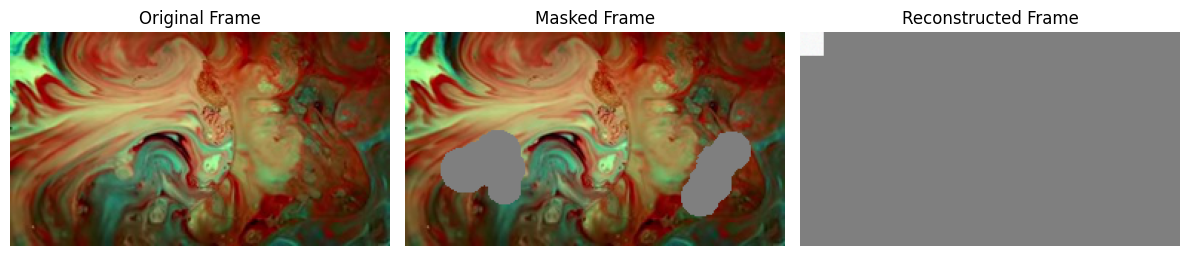

In [5]:
import matplotlib.pyplot as plt

# data_dir = 'E:/lama/masked_img/test_img/'  # 改成你自己的图像目录  
# data_dir = 'E:/lama/jet_S2_Daily_Mosaic/'  # 改成你自己的图像目录
data_dir = 'E:/lama/masked_img/test_8/'  # 改成你自己的图像目录
input_seq_len = 8
dataset = Datasets(data_dir=data_dir, max_seq_len=input_seq_len)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 模型初始化
model = VideoCompletionModel(
    # img_size_h=960,
    # img_size_w=608,
    img_size_h=144,
    img_size_w=256,
    patch_size=16,
    embed_dim=192,
    num_heads=2,
    max_seq_len=input_seq_len,
    use_mask_channel=True,
    out_channels=3,
    dropout=0.1
).to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#* 调用训练函数
train(model, dataloader, optimizer, device, criterion, epochs=20)
# 保存模型权重
torch.save(model.state_dict(), 'video_completion_model.pth')
print("模型权重已保存为 video_completion_model.pth")

#* 加载训练好的权重
model.load_state_dict(torch.load('video_completion_model.pth', map_location=device))
model.eval()
print("已加载训练好的模型权重。")
# 从dataloader中取一个batch
sample = next(iter(dataloader))
video = sample['video'].to(device)         # (B, T, C, H, W)
masked_video = sample['masked'].to(device) # (B, T, C, H, W)
mask = sample['mask'].to(device)           # (B, T, 1, H, W)
with torch.no_grad():
    output = model(masked_video, mask)

    # 上采样到原始分辨率
    B, T, C, H, W = video.shape
    output = F.interpolate(
        output.view(B * T, C, *output.shape[-2:]),
        size=(H, W),
        mode='bilinear',
        align_corners=False
    ).view(B, T, C, H, W)
# 可视化第 t 帧
def show_image(tensor_img, title=''):
    img = tensor_img.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    img = (img * 0.5 + 0.5).clip(0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
t = 0
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
show_image(video[0, t], 'Original Frame')
plt.subplot(1, 3, 2)
show_image(masked_video[0, t], 'Masked Frame')
plt.subplot(1, 3, 3)
show_image(output[0, t], 'Reconstructed Frame')
plt.tight_layout()
plt.savefig('result_visualization.png')
plt.show()

### 模型测试

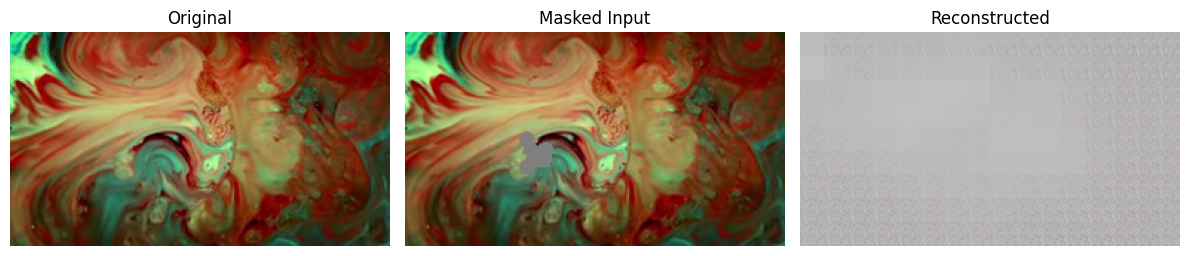

In [5]:
import torch.nn.functional as F

# 取一个验证样本
sample = dataset[0]

video = sample['video'].unsqueeze(0).to(device)         # (1, T, C, H, W)
masked_video = sample['masked'].unsqueeze(0).to(device)  # (1, T, C, H, W)
mask = sample['mask'].unsqueeze(0).to(device)            # (1, T, 1, H, W)

# 前向推理
model.eval()
with torch.no_grad():
    output = model(masked_video, mask)

    # 上采样使 reconstructed 与 video 尺寸一致
    B, T, C, H, W = video.shape
    output = F.interpolate(
        output.view(B * T, C, *output.shape[-2:]),
        size=(H, W),
        mode='bilinear',
        align_corners=False
    ).view(B, T, C, H, W)

# 可视化某一帧
import matplotlib.pyplot as plt

def show_image(tensor_img, title=''):
    img = tensor_img.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    img = (img * 0.5 + 0.5).clip(0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

t = 0  # 第 t 帧
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
show_image(video[0, t], 'Original')

plt.subplot(1, 3, 2)
show_image(masked_video[0, t], 'Masked Input')

plt.subplot(1, 3, 3)
show_image(output[0, t], 'Reconstructed')

plt.tight_layout()
plt.savefig("result_visualization.png")  # 保存可视化结果
plt.show()


### 基于MAE和VIT的时序视频帧插补 V2.0

c:\Users\1\.conda\envs\ViT\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
c:\Users\1\.conda\envs\ViT\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/20], Loss: 0.1554
Epoch [2/20], Loss: 0.0781
Epoch [3/20], Loss: 0.0684
Epoch [4/20], Loss: 0.0597
Epoch [5/20], Loss: 0.0517
Epoch [6/20], Loss: 0.0505
Epoch [7/20], Loss: 0.0607
Epoch [8/20], Loss: 0.0641
Epoch [9/20], Loss: 0.0625
Epoch [10/20], Loss: 0.0584
Epoch [11/20], Loss: 0.0445
Epoch [12/20], Loss: 0.0361
Epoch [13/20], Loss: 0.0320
Epoch [14/20], Loss: 0.0329
Epoch [15/20], Loss: 0.0347
Epoch [16/20], Loss: 0.0274
Epoch [17/20], Loss: 0.0255
Epoch [18/20], Loss: 0.0273
Epoch [19/20], Loss: 0.0239
Epoch [20/20], Loss: 0.0267
模型权重已保存为 video_completion_model.pth


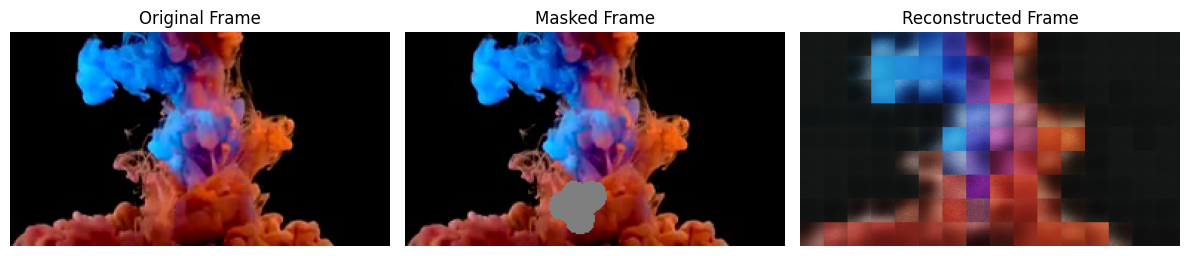

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from typing import Tuple
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import os
import cv2
from PIL import Image 

class Datasets(Dataset):
    """自定义数据集"""
    def __init__(self, data_dir: str, max_seq_len: int = 8):
        self.data_dir = data_dir
        self.max_seq_len = max_seq_len  # 假设每个视频序列有8帧
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # 转换为Tensor
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 标准化
        ])
        self.img_list = self._load_data()
        if self.img_list:
            self.img_size = self.img_list[0].size[::-1]  # PIL图像: (W, H) → (H, W)
        else:
            raise ValueError("No images found in directory:", data_dir)
    def _load_data(self):
        """加载数据"""
        img_list = []
        for frame_file in sorted(os.listdir(self.data_dir)):
            if frame_file.endswith('.png') or frame_file.endswith('.jpg'):
                frame_path = os.path.join(self.data_dir, frame_file)
                image = Image.open(frame_path).convert('RGB')  # 使用PIL读取并转为RGB
                img_list.append(image)
        return img_list

    def __len__(self):
        """返回数据集长度"""
        return len(self.img_list) // self.max_seq_len

    def __getitem__(self, idx):
        """获取单个样本"""
        start_idx = idx * self.max_seq_len
        end_idx = min(start_idx + self.max_seq_len, len(self.img_list))
        frames = self.img_list[start_idx:end_idx]
        if len(frames) < self.max_seq_len:
            # 如果不足max_seq_len帧，填充
            frames += [frames[-1]] * (self.max_seq_len - len(frames))
        frames = [self.transform(frame) for frame in frames]
        # 转换为张量 (T, C, H, W)
        video = torch.stack(frames, dim=0)
        
        # 生成随机掩码 (T, 1, H, W)
        mask = self._generate_random_mask()
        
        # 应用掩码创建输入
        masked_video = video * (1 - mask)
        
        return {
            'video': video,          # 完整视频 (T, C, H, W)
            'masked': masked_video,  # 带掩码的视频 (T, C, H, W)
            'mask': mask             # 掩码 (T, 1, H, W)
        }
    def _generate_random_mask(self):
        """生成云形状的随机掩码"""
        # 随机选择掩码类型: 0-大块云, 1-分散小云, 2-时序随机云
        mask_type = np.random.randint(0, 3)
        mask = torch.zeros((self.max_seq_len, 1, *self.img_size))
        
        if mask_type == 0:  # 大块云
            # 生成1-3个大云块
            num_clouds = np.random.randint(1, 4)
            for _ in range(num_clouds):
                # 云的大小范围(占图像尺寸的10%-40%)
                size_range = (
                    max(10, int(min(self.img_size)*0.1)),
                    int(min(self.img_size)*0.4)
                )
                cloud_patch = self._generate_cloud_patch(size_range)
                if cloud_patch is not None:
                    h, w = cloud_patch.shape
                    # 随机位置
                    h_start = np.random.randint(0, self.img_size[0]-h)
                    w_start = np.random.randint(0, self.img_size[1]-w)
                    # 随机时间持续(1-3帧)
                    t_start = np.random.randint(0, self.max_seq_len-1)
                    t_end = min(t_start + np.random.randint(1, 4), self.max_seq_len)
                    # 应用云掩码
                    mask[t_start:t_end, 0, h_start:h_start+h, w_start:w_start+w] = \
                        torch.from_numpy(cloud_patch).float()
        
        elif mask_type == 1:  # 分散小云
            # 生成5-15个小云块
            num_clouds = np.random.randint(5, 16)
            for _ in range(num_clouds):
                # 云的大小范围(占图像尺寸的5%-20%)
                size_range = (
                    max(5, int(min(self.img_size)*0.05)),
                    int(min(self.img_size)*0.2)
                )
                cloud_patch = self._generate_cloud_patch(size_range)
                if cloud_patch is not None:
                    h, w = cloud_patch.shape
                    # 随机位置
                    h_start = np.random.randint(0, self.img_size[0]-h)
                    w_start = np.random.randint(0, self.img_size[1]-w)
                    # 随机时间持续(1帧)
                    t = np.random.randint(0, self.max_seq_len)
                    # 应用云掩码
                    mask[t, 0, h_start:h_start+h, w_start:w_start+w] = \
                        torch.from_numpy(cloud_patch).float()
        
        else:  # 时序随机云
            for t in range(self.max_seq_len):
                if np.random.rand() < 0.5:  # 50%概率该帧有云
                    # 随机云数量
                    num_clouds = np.random.randint(1, 4)
                    for _ in range(num_clouds):
                        # 云的大小范围(占图像尺寸的5%-30%)
                        size_range = (
                            max(5, int(min(self.img_size)*0.05)),
                            int(min(self.img_size)*0.3)
                        )
                        cloud_patch = self._generate_cloud_patch(size_range)
                        if cloud_patch is not None:
                            h, w = cloud_patch.shape
                            # 随机位置
                            h_start = np.random.randint(0, self.img_size[0]-h)
                            w_start = np.random.randint(0, self.img_size[1]-w)
                            # 应用云掩码
                            mask[t, 0, h_start:h_start+h, w_start:w_start+w] = \
                                torch.from_numpy(cloud_patch).float()
        
        return mask

    def _generate_cloud_patch(self, size_range):
        """生成单个云形状的补丁"""
        # 确定云的大小
        size = np.random.randint(size_range[0], size_range[1] + 1)
        
        # 创建画布
        canvas_size = size * 3
        canvas = np.zeros((canvas_size, canvas_size), dtype=np.float32)
        
        # 1. 生成多个重叠的圆形作为基础
        num_circles = np.random.randint(3, 7)  # 3-6个圆形
        
        for _ in range(num_circles):
            # 圆心在中心区域附近随机分布
            cx = canvas_size // 2 + np.random.randint(-size//2, size//2)
            cy = canvas_size // 2 + np.random.randint(-size//2, size//2)
            radius = np.random.randint(size//4, size//2)
            
            # 绘制圆形
            cv2.circle(canvas, (cx, cy), radius, 1, -1)
        
        # 2. 应用高斯模糊使边缘更柔和
        blur_size = min(11, size//5)  # 模糊核大小
        if blur_size % 2 == 0:  # 确保奇数核
            blur_size += 1
        blurred = cv2.GaussianBlur(canvas, (blur_size, blur_size), 0)
        
        # 3. 二值化创建云形状
        _, cloud_patch = cv2.threshold(blurred, 0.3, 1, cv2.THRESH_BINARY)
        cloud_patch = cloud_patch.astype(np.uint8)
        
        # 4. 形态学操作使云形状更自然
        kernel_size = max(3, size//10)
        if kernel_size % 2 == 0:
            kernel_size += 1
            
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        
        # 先膨胀使云更蓬松
        cloud_patch = cv2.dilate(cloud_patch, kernel, iterations=1)
        # 再腐蚀使边缘更自然
        cloud_patch = cv2.erode(cloud_patch, kernel, iterations=1)
        
        # 5. 裁剪非零区域
        rows, cols = np.where(cloud_patch)
        if len(rows) == 0:
            return None
            
        min_row, max_row = np.min(rows), np.max(rows)
        min_col, max_col = np.min(cols), np.max(cols)
        cropped = cloud_patch[min_row:max_row+1, min_col:max_col+1]
        
        # 6. 随机缩放增加变化性
        scale_factor = np.random.uniform(0.8, 1.2)
        new_h = max(1, int(cropped.shape[0] * scale_factor))
        new_w = max(1, int(cropped.shape[1] * scale_factor))
        
        if new_h > 0 and new_w > 0:
            resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
            # 重新二值化
            _, resized = cv2.threshold(resized, 0.5, 1, cv2.THRESH_BINARY)
            return resized.astype(np.uint8)
        
        return cropped

class PatchEmbedding(nn.Module):
    """Patch嵌入层"""
    def __init__(self, img_size_h: int = 224, img_size_w: int = 224, 
                 patch_size: int = 16, in_channels: int = 3, 
                 embed_dim: int = 768, use_mask_channel: bool = True):
        super().__init__()
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.num_patches = (img_size_h // patch_size) * (img_size_w // patch_size)
        self.in_channels = in_channels
        self.embed_dim = embed_dim
        self.use_mask_channel = use_mask_channel
        
        conv_in_channels = in_channels + 1 if use_mask_channel else in_channels
        self.projection = nn.Conv2d(
            conv_in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False
        )
        
        self.mask_projection = nn.Conv2d(
            1, embed_dim // 4, kernel_size=patch_size, stride=patch_size
        )
        
        self.fusion = nn.Linear(embed_dim + embed_dim // 4, embed_dim)
        
    def forward(self, x, mask=None):
        B, T, C, or_H, or_W = x.shape
        
        if or_H != self.img_size_h or or_W != self.img_size_w:
            x = F.interpolate(
                x.view(-1, C, or_H, or_W),
                size=(self.img_size_h, self.img_size_w),
                mode='bilinear', align_corners=False
            )
        x = x.view(B, T, C, self.img_size_h, self.img_size_w)
        
        if mask is not None:
            mask = F.interpolate(
                mask.view(-1, 1, or_H, or_W),
                size=(self.img_size_h, self.img_size_w),
                mode='nearest'
            )
            mask = mask.view(B, T, 1, self.img_size_h, self.img_size_w)
        
        if self.use_mask_channel and mask is not None:
            x_with_mask = torch.cat([x, mask], dim=2)
            x_with_mask = rearrange(x_with_mask, 'b t c h w -> (b t) c h w')
            x_embedded = self.projection(x_with_mask)
            x_embedded = rearrange(x_embedded, '(b t) d n_h n_w -> b t (n_h n_w) d', b=B, t=T)
        else:
            x_reshaped = rearrange(x, 'b t c h w -> (b t) c h w')
            img_embedded = self.projection(x_reshaped)
            img_embedded = rearrange(img_embedded, '(b t) d n_h n_w -> b t (n_h n_w) d', b=B, t=T)
            
            mask_reshaped = rearrange(mask, 'b t c h w -> (b t) c h w')
            mask_embedded = self.mask_projection(mask_reshaped)
            mask_embedded = rearrange(mask_embedded, '(b t) d n_h n_w -> b t (n_h n_w) d', b=B, t=T)
            
            combined = torch.cat([img_embedded, mask_embedded], dim=-1)
            x_embedded = self.fusion(combined)
            
        return x_embedded

class SpatioTemporalPositionalEncoding(nn.Module):
    def __init__(self, embed_dim: int, img_size_h: int, img_size_w: int, num_heads: int, 
                patch_size: int, max_seq_len: int, dropout: float = 0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.max_seq_len = max_seq_len
        
        self.num_patches_h = img_size_h // patch_size
        self.num_patches_w = img_size_w // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        
        self.temporal_pos_bias = nn.Parameter(torch.zeros(max_seq_len, max_seq_len))
        self.spatial_pos_bias = nn.Parameter(torch.zeros(self.num_patches, self.num_patches))
        
        self.temporal_proj = nn.Linear(1, embed_dim // 4)
        self.spatial_proj = nn.Linear(2, embed_dim // 4)
        self.relative_proj = nn.Linear(3, embed_dim // 4)
        
        self.num_heads = num_heads
        self.dropout = nn.Dropout(dropout)
        self._init_parameters()
        
    def _init_parameters(self):
        with torch.no_grad():
            for i in range(self.max_seq_len):
                for j in range(self.max_seq_len):
                    distance = abs(i - j)
                    self.temporal_pos_bias[i, j] = -0.1 * math.exp(-distance/5.0)
            
            for i in range(self.num_patches):
                for j in range(self.num_patches):
                    pos_i = self._patch_idx_to_coords(i)
                    pos_j = self._patch_idx_to_coords(j)
                    dx = pos_i[0] - pos_j[0]
                    dy = pos_i[1] - pos_j[1]
                    distance = math.sqrt(dx**2 + dy**2)
                    self.spatial_pos_bias[i, j] = -0.1 * math.exp(-distance/5.0)
    
    def _patch_idx_to_coords(self, idx):
        h_idx = idx // self.num_patches_w
        w_idx = idx % self.num_patches_w
        return (h_idx, w_idx)
    
    def _get_spatial_neighbors(self, patch_idx: int, radius: int = 1) -> list:
        neighbors = []
        h_idx, w_idx = self._patch_idx_to_coords(patch_idx)
        for dh in range(-radius, radius + 1):
            for dw in range(-radius, radius + 1):
                new_h = h_idx + dh
                new_w = w_idx + dw
                if (0 <= new_h < self.num_patches_h and 
                    0 <= new_w < self.num_patches_w and 
                    (dh != 0 or dw != 0)):
                    neighbors.append(new_h * self.num_patches_w + new_w)
        return neighbors
    
    def create_sparse_attention_mask(self, batch_size: int, seq_len: int, device: torch.device) -> torch.Tensor:
        total_tokens = seq_len * self.num_patches
        mask = torch.full((batch_size, total_tokens, total_tokens), float('-inf'), device=device)
        
        for t in range(seq_len):
            for n in range(self.num_patches):
                current_idx = t * self.num_patches + n
                for other_t in range(seq_len):
                    other_idx = other_t * self.num_patches + n
                    mask[:, current_idx, other_idx] = 0.0
                
                neighbors = self._get_spatial_neighbors(n, radius=1)
                for neighbor in neighbors:
                    mask[:, current_idx, t * self.num_patches + neighbor] = 0.0
                    
        return mask.to(device)
    
    def get_attention_bias(self, batch_size: int, seq_len: int, device: torch.device) -> torch.Tensor:
        total_tokens = seq_len * self.num_patches
        bias = torch.zeros((batch_size, self.num_heads, total_tokens, total_tokens), device=device)
        
        for t in range(seq_len):
            for n in range(self.num_patches):
                current_idx = t * self.num_patches + n
                for other_t in range(seq_len):
                    other_idx = other_t * self.num_patches + n
                    temporal_bias = self.temporal_pos_bias[t, other_t]
                    bias[:, :, current_idx, other_idx] += temporal_bias
                
                neighbors = self._get_spatial_neighbors(n, radius=2)
                for neighbor in neighbors:
                    bias[:, :, current_idx, t * self.num_patches + neighbor] += self.spatial_pos_bias[n, neighbor]
                    
        return bias
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        B, T, N, D = x.shape
        device = x.device
        
        enhanced_x = rearrange(x, 'b t n d -> b (t n) d')
        attention_mask = self.create_sparse_attention_mask(B, T, device)
        attention_bias = self.get_attention_bias(B, T, device)
        
        return enhanced_x, attention_mask, attention_bias

class SparseMultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim必须能被num_heads整除"
        
        self.scale = self.head_dim ** -0.5
        
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor, attention_mask: torch.Tensor, 
                attention_bias: torch.Tensor) -> torch.Tensor:
        B, T_N, D = x.shape
        
        q = self.q_proj(x).view(B, T_N, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, T_N, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(B, T_N, self.num_heads, self.head_dim).transpose(1, 2)
        
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attention_scores += attention_bias
        
        attention_mask = attention_mask.unsqueeze(1).expand(-1, self.num_heads, -1, -1)
        attention_scores = attention_scores + attention_mask
        
        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        
        context = torch.matmul(attention_probs, v)
        context = context.transpose(1, 2).contiguous().view(B, T_N, D)
        
        output = self.out_proj(context)
        return output

class PatchDecoder(nn.Module):
    def __init__(self, img_size_h: int, img_size_w: int, patch_size: int, 
                 embed_dim: int, out_channels: int = 3, use_progressive: bool = False):
        super().__init__()
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.out_channels = out_channels
        self.use_progressive = use_progressive

        self.num_patches_h = img_size_h // patch_size
        self.num_patches_w = img_size_w // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        
        self.direct_decoder = nn.Sequential(
            nn.ConvTranspose2d(
                embed_dim, out_channels,
                kernel_size=patch_size,
                stride=patch_size,
                padding=0
            ),
            nn.Tanh()  # 使用Tanh匹配输入范围[-1,1]
        )
        
        self.progressive_decoder = self._build_progressive_decoder()
        
    def _build_progressive_decoder(self):
        layers = []
        current_dim = self.embed_dim
        scale_factor = self.patch_size
        num_layers = int(math.log2(scale_factor)) if scale_factor > 1 and (scale_factor & (scale_factor - 1)) == 0 else None
        
        if num_layers is not None and num_layers > 1:
            for i in range(num_layers):
                next_dim = current_dim // 2 if i < num_layers - 1 else self.out_channels
                layers.extend([
                    nn.ConvTranspose2d(current_dim, next_dim, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(inplace=True) if i < num_layers - 1 else nn.Tanh(),
                ])
                if i < num_layers - 1:
                    layers.append(nn.GroupNorm(min(8, next_dim), next_dim))
                current_dim = next_dim
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(self.embed_dim, self.embed_dim // 2, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.GroupNorm(8, self.embed_dim // 2),
                nn.ConvTranspose2d(self.embed_dim // 2, self.out_channels, kernel_size=1),
                nn.Tanh()
            )
            
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T_N, D = x.shape
        T = T_N // self.num_patches

        x = x.view(B, T, self.num_patches, D)
        x = x.permute(0, 1, 3, 2)
        x = rearrange(x, 'b t d (n_h n_w) -> (b t) d n_h n_w', 
                    n_h=self.num_patches_h, n_w=self.num_patches_w)

        if self.use_progressive and hasattr(self, 'progressive_decoder'):
            output = self.progressive_decoder(x)
        else:
            output = self.direct_decoder(x)
            
        output = rearrange(output, '(b t) c h w -> b t c h w', b=B)
        return output

class VideoCompletionModel(nn.Module):
    def __init__(self, img_size_h: int, img_size_w: int, patch_size: int, 
                 embed_dim: int, num_heads: int, max_seq_len: int, 
                 use_mask_channel: bool = False, out_channels: int = 3, dropout: float = 0.1):
        super().__init__()
        self.patch_embedding = PatchEmbedding(
            img_size_h=img_size_h,
            img_size_w=img_size_w,
            patch_size=patch_size,
            in_channels=out_channels,
            embed_dim=embed_dim,
            use_mask_channel=use_mask_channel
        )
        
        self.positional_encoding = SpatioTemporalPositionalEncoding(
            embed_dim=embed_dim,
            img_size_h=img_size_h,
            img_size_w=img_size_w,
            patch_size=patch_size,
            max_seq_len=max_seq_len,
            num_heads=num_heads,
            dropout=dropout
        )
        
        self.sparse_attention = SparseMultiHeadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout
        )
        
        self.decoder = PatchDecoder(
            img_size_h=img_size_h,
            img_size_w=img_size_w,
            patch_size=patch_size,
            embed_dim=embed_dim,
            out_channels=out_channels,
            use_progressive=False
        )
        
        self.attenLayers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim * 4,
                dropout=dropout,
                activation='gelu'
            ) for _ in range(6)
        ])

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        B, T, C, H, W = x.shape
        
        x_embedded = self.patch_embedding(x, mask)
        enhanced_x, attention_mask, attention_bias = self.positional_encoding(x_embedded)
        
        attention_output = self.sparse_attention(enhanced_x, attention_mask, attention_bias)
        enhanced_x = enhanced_x + attention_output  # 添加残差连接
        
        for layer in self.attenLayers:
            enhanced_x = layer(enhanced_x)
            
        reconstructed = self.decoder(enhanced_x)
        return reconstructed

# 训练和验证代码
def train(model, dataloader, optimizer, device, criterion, epochs=10):
    model.train()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    for epoch in range(epochs):
        total_loss = 0.0
        for batch in dataloader:
            video = batch['video'].to(device)
            masked_video = batch['masked'].to(device)
            mask = batch['mask'].to(device)

            optimizer.zero_grad()
            reconstructed = model(masked_video, mask)
            
            # 计算完整图像的损失
            loss = criterion(reconstructed, video)
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        scheduler.step(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

def visualize_results(model, dataloader, device):
    model.eval()
    sample = next(iter(dataloader))
    video = sample['video'].to(device)
    masked_video = sample['masked'].to(device)
    mask = sample['mask'].to(device)
    
    with torch.no_grad():
        output = model(masked_video, mask)
    
    t = 0  # 可视化第一帧
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(video[0, t].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.title('Original Frame')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(masked_video[0, t].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.title('Masked Frame')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(output[0, t].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.title('Reconstructed Frame')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('result_visualization.png')
    plt.show()

# 主程序
if __name__ == "__main__":
    # 数据目录设置
    data_dir = 'E:/lama/masked_img/test_img/'
    input_seq_len = 8
    
    # 初始化数据集和数据加载器
    dataset = Datasets(data_dir=data_dir, max_seq_len=input_seq_len)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # 设备设置
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # 模型初始化
    model = VideoCompletionModel(
        img_size_h=144,
        img_size_w=256,
        patch_size=16,
        embed_dim=192,
        num_heads=2,
        max_seq_len=input_seq_len,
        use_mask_channel=True,
        out_channels=3,
        dropout=0.1
    ).to(device)
    
    # 损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    
    # 训练模型
    train(model, dataloader, optimizer, device, criterion, epochs=20)
    
    # 保存模型
    torch.save(model.state_dict(), 'video_completion_model.pth')
    print("模型权重已保存为 video_completion_model.pth")
    
    # 可视化结果
    visualize_results(model, dataloader, device)

### 基于MAE和VIT的时序视频帧插补 V3.0

##### 改进：位置偏置的邻接链表替代邻接表 

C:\Users\1\AppData\Local\Temp\ipykernel_15716\1620588886.py:625: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

✅ 模型权重已成功加载


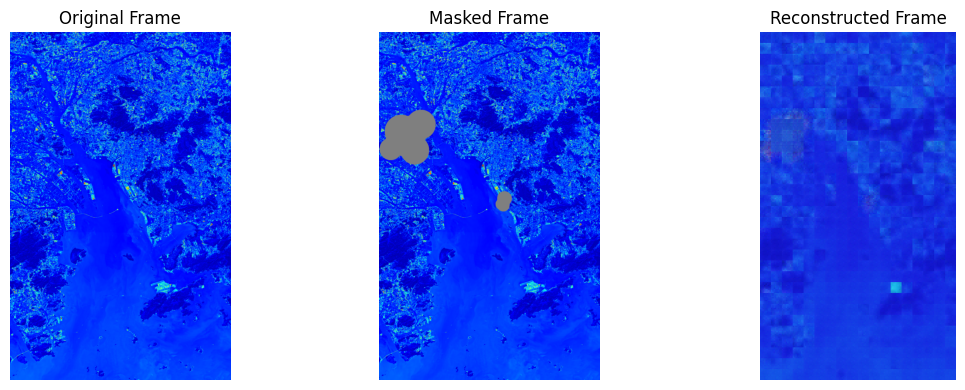

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from typing import Tuple
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import os
import cv2
from PIL import Image 

class Datasets(Dataset):
    """自定义数据集"""
    def __init__(self, data_dir: str, max_seq_len: int = 8):
        self.data_dir = data_dir
        self.max_seq_len = max_seq_len  # 假设每个视频序列有8帧
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # 转换为Tensor
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 标准化
        ])
        self.img_list = self._load_data()
        if self.img_list:
            self.img_size = self.img_list[0].size[::-1]  # PIL图像: (W, H) → (H, W)
        else:
            raise ValueError("No images found in directory:", data_dir)
    def _load_data(self):
        """加载数据"""
        img_list = []
        for frame_file in sorted(os.listdir(self.data_dir)):
            if frame_file.endswith('.png') or frame_file.endswith('.jpg'):
                frame_path = os.path.join(self.data_dir, frame_file)
                image = Image.open(frame_path).convert('RGB')  # 使用PIL读取并转为RGB
                img_list.append(image)
        return img_list

    def __len__(self):
        """返回数据集长度"""
        return len(self.img_list) // self.max_seq_len

    def __getitem__(self, idx):
        """获取单个样本"""
        start_idx = idx * self.max_seq_len
        end_idx = min(start_idx + self.max_seq_len, len(self.img_list))
        frames = self.img_list[start_idx:end_idx]
        if len(frames) < self.max_seq_len:
            # 如果不足max_seq_len帧，填充
            frames += [frames[-1]] * (self.max_seq_len - len(frames))
        frames = [self.transform(frame) for frame in frames]
        # 转换为张量 (T, C, H, W)
        video = torch.stack(frames, dim=0)
        
        # 生成随机掩码 (T, 1, H, W)
        mask = self._generate_random_mask()
        
        # 应用掩码创建输入
        masked_video = video * (1 - mask)
        
        return {
            'video': video,          # 完整视频 (T, C, H, W)
            'masked': masked_video,  # 带掩码的视频 (T, C, H, W)
            'mask': mask             # 掩码 (T, 1, H, W)
        }
    def _generate_random_mask(self):
        """生成云形状的随机掩码"""
        # 随机选择掩码类型: 0-大块云, 1-分散小云, 2-时序随机云
        mask_type = np.random.randint(0, 3)
        mask = torch.zeros((self.max_seq_len, 1, *self.img_size))
        
        if mask_type == 0:  # 大块云
            # 生成1-3个大云块
            num_clouds = np.random.randint(1, 4)
            for _ in range(num_clouds):
                # 云的大小范围(占图像尺寸的10%-40%)
                size_range = (
                    max(10, int(min(self.img_size)*0.1)),
                    int(min(self.img_size)*0.4)
                )
                cloud_patch = self._generate_cloud_patch(size_range)
                if cloud_patch is not None:
                    h, w = cloud_patch.shape
                    # 随机位置
                    h_start = np.random.randint(0, self.img_size[0]-h)
                    w_start = np.random.randint(0, self.img_size[1]-w)
                    # 随机时间持续(1-3帧)
                    t_start = np.random.randint(0, self.max_seq_len-1)
                    t_end = min(t_start + np.random.randint(1, 4), self.max_seq_len)
                    # 应用云掩码
                    mask[t_start:t_end, 0, h_start:h_start+h, w_start:w_start+w] = \
                        torch.from_numpy(cloud_patch).float()
        
        elif mask_type == 1:  # 分散小云
            # 生成5-15个小云块
            num_clouds = np.random.randint(5, 16)
            for _ in range(num_clouds):
                # 云的大小范围(占图像尺寸的5%-20%)
                size_range = (
                    max(5, int(min(self.img_size)*0.05)),
                    int(min(self.img_size)*0.2)
                )
                cloud_patch = self._generate_cloud_patch(size_range)
                if cloud_patch is not None:
                    h, w = cloud_patch.shape
                    # 随机位置
                    h_start = np.random.randint(0, self.img_size[0]-h)
                    w_start = np.random.randint(0, self.img_size[1]-w)
                    # 随机时间持续(1帧)
                    t = np.random.randint(0, self.max_seq_len)
                    # 应用云掩码
                    mask[t, 0, h_start:h_start+h, w_start:w_start+w] = \
                        torch.from_numpy(cloud_patch).float()
        
        else:  # 时序随机云
            for t in range(self.max_seq_len):
                if np.random.rand() < 0.5:  # 50%概率该帧有云
                    # 随机云数量
                    num_clouds = np.random.randint(1, 4)
                    for _ in range(num_clouds):
                        # 云的大小范围(占图像尺寸的5%-30%)
                        size_range = (
                            max(5, int(min(self.img_size)*0.05)),
                            int(min(self.img_size)*0.3)
                        )
                        cloud_patch = self._generate_cloud_patch(size_range)
                        if cloud_patch is not None:
                            h, w = cloud_patch.shape
                            # 随机位置
                            h_start = np.random.randint(0, self.img_size[0]-h)
                            w_start = np.random.randint(0, self.img_size[1]-w)
                            # 应用云掩码
                            mask[t, 0, h_start:h_start+h, w_start:w_start+w] = \
                                torch.from_numpy(cloud_patch).float()
        
        return mask

    def _generate_cloud_patch(self, size_range):
        """生成单个云形状的补丁"""
        # 确定云的大小
        size = np.random.randint(size_range[0], size_range[1] + 1)
        
        # 创建画布
        canvas_size = size * 3
        canvas = np.zeros((canvas_size, canvas_size), dtype=np.float32)
        
        # 1. 生成多个重叠的圆形作为基础
        num_circles = np.random.randint(3, 7)  # 3-6个圆形
        
        for _ in range(num_circles):
            # 圆心在中心区域附近随机分布
            cx = canvas_size // 2 + np.random.randint(-size//2, size//2)
            cy = canvas_size // 2 + np.random.randint(-size//2, size//2)
            radius = np.random.randint(size//4, size//2)
            
            # 绘制圆形
            cv2.circle(canvas, (cx, cy), radius, 1, -1)
        
        # 2. 应用高斯模糊使边缘更柔和
        blur_size = min(11, size//5)  # 模糊核大小
        if blur_size % 2 == 0:  # 确保奇数核
            blur_size += 1
        blurred = cv2.GaussianBlur(canvas, (blur_size, blur_size), 0)
        
        # 3. 二值化创建云形状
        _, cloud_patch = cv2.threshold(blurred, 0.3, 1, cv2.THRESH_BINARY)
        cloud_patch = cloud_patch.astype(np.uint8)
        
        # 4. 形态学操作使云形状更自然
        kernel_size = max(3, size//10)
        if kernel_size % 2 == 0:
            kernel_size += 1
            
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        
        # 先膨胀使云更蓬松
        cloud_patch = cv2.dilate(cloud_patch, kernel, iterations=1)
        # 再腐蚀使边缘更自然
        cloud_patch = cv2.erode(cloud_patch, kernel, iterations=1)
        
        # 5. 裁剪非零区域
        rows, cols = np.where(cloud_patch)
        if len(rows) == 0:
            return None
            
        min_row, max_row = np.min(rows), np.max(rows)
        min_col, max_col = np.min(cols), np.max(cols)
        cropped = cloud_patch[min_row:max_row+1, min_col:max_col+1]
        
        # 6. 随机缩放增加变化性
        scale_factor = np.random.uniform(0.8, 1.2)
        new_h = max(1, int(cropped.shape[0] * scale_factor))
        new_w = max(1, int(cropped.shape[1] * scale_factor))
        
        if new_h > 0 and new_w > 0:
            resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
            # 重新二值化
            _, resized = cv2.threshold(resized, 0.5, 1, cv2.THRESH_BINARY)
            return resized.astype(np.uint8)
        
        return cropped

class PatchEmbedding(nn.Module):
    """Patch嵌入层"""
    def __init__(self, img_size_h: int = 224, img_size_w: int = 224, 
                 patch_size: int = 16, in_channels: int = 3, 
                 embed_dim: int = 768, use_mask_channel: bool = True):
        super().__init__()
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.num_patches = (img_size_h // patch_size) * (img_size_w // patch_size)
        self.in_channels = in_channels
        self.embed_dim = embed_dim
        self.use_mask_channel = use_mask_channel
        
        conv_in_channels = in_channels + 1 if use_mask_channel else in_channels
        self.projection = nn.Conv2d(
            conv_in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False
        )
        
        self.mask_projection = nn.Conv2d(
            1, embed_dim // 4, kernel_size=patch_size, stride=patch_size
        )
        
        self.fusion = nn.Linear(embed_dim + embed_dim // 4, embed_dim)
        
    def forward(self, x, mask=None):
        B, T, C, or_H, or_W = x.shape
        
        if or_H != self.img_size_h or or_W != self.img_size_w:
            x = F.interpolate(
                x.view(-1, C, or_H, or_W),
                size=(self.img_size_h, self.img_size_w),
                mode='bilinear', align_corners=False
            )
        x = x.view(B, T, C, self.img_size_h, self.img_size_w)
        
        if mask is not None:
            mask = F.interpolate(
                mask.view(-1, 1, or_H, or_W),
                size=(self.img_size_h, self.img_size_w),
                mode='nearest'
            )
            mask = mask.view(B, T, 1, self.img_size_h, self.img_size_w)
        
        if self.use_mask_channel and mask is not None:
            x_with_mask = torch.cat([x, mask], dim=2)
            x_with_mask = rearrange(x_with_mask, 'b t c h w -> (b t) c h w')
            x_embedded = self.projection(x_with_mask)
            x_embedded = rearrange(x_embedded, '(b t) d n_h n_w -> b t (n_h n_w) d', b=B, t=T)
        else:
            x_reshaped = rearrange(x, 'b t c h w -> (b t) c h w')
            img_embedded = self.projection(x_reshaped)
            img_embedded = rearrange(img_embedded, '(b t) d n_h n_w -> b t (n_h n_w) d', b=B, t=T)
            
            mask_reshaped = rearrange(mask, 'b t c h w -> (b t) c h w')
            mask_embedded = self.mask_projection(mask_reshaped)
            mask_embedded = rearrange(mask_embedded, '(b t) d n_h n_w -> b t (n_h n_w) d', b=B, t=T)
            
            combined = torch.cat([img_embedded, mask_embedded], dim=-1)
            x_embedded = self.fusion(combined)
            
        return x_embedded

class SpatioTemporalPositionalEncoding(nn.Module):
    def __init__(self, embed_dim: int, img_size_h: int, img_size_w: int, num_heads: int, 
                patch_size: int, max_seq_len: int, dropout: float = 0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.max_seq_len = max_seq_len
        self.num_heads = num_heads
        
        # 计算patch网格尺寸
        self.num_patches_h = img_size_h // patch_size
        self.num_patches_w = img_size_w // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        
        # 时间位置编码参数
        self.temporal_embed = nn.Parameter(torch.randn(1, max_seq_len, 1, embed_dim))
        
        # 空间位置编码参数
        self.spatial_embed = nn.Parameter(torch.randn(1, 1, self.num_patches, embed_dim))
        
        # 相对位置编码网络
        self.relative_pos_encoder = nn.Sequential(
            nn.Linear(3, embed_dim // 4),  # 输入(dx, dy, distance)
            nn.GELU(),
            nn.Linear(embed_dim // 4, num_heads)
        )
        
        # 预计算邻接关系（转换为张量格式）
        neighbor_data = self._precompute_neighbor_data()
        self.register_buffer('neighbor_indices', neighbor_data['indices'])
        self.register_buffer('neighbor_offsets', neighbor_data['offsets'])
        self.register_buffer('neighbor_counts', neighbor_data['counts'])
        
        self.dropout = nn.Dropout(dropout)
        
    def _precompute_neighbor_data(self):
        """预计算邻居索引和偏移量，返回张量格式的数据"""
        max_neighbors = 8  # 3x3邻域最多8个邻居
        indices = torch.full((self.num_patches, max_neighbors), -1, dtype=torch.long)
        offsets = torch.zeros((self.num_patches, max_neighbors, 3))
        counts = torch.zeros(self.num_patches, dtype=torch.long)
        
        grid_h = torch.arange(self.num_patches_h, dtype=torch.float32)
        grid_w = torch.arange(self.num_patches_w, dtype=torch.float32)
        grid = torch.stack(torch.meshgrid(grid_h, grid_w, indexing='ij'), dim=-1)
        grid = grid.view(-1, 2)  # (N, 2)
        
        for i in range(self.num_patches):
            h, w = i // self.num_patches_w, i % self.num_patches_w
            pos_i = grid[i]
            neighbor_count = 0
            
            for dh in [-1, 0, 1]:  # 3x3邻域
                for dw in [-1, 0, 1]:
                    if dh == 0 and dw == 0: continue
                    new_h, new_w = h + dh, w + dw
                    
                    if 0 <= new_h < self.num_patches_h and 0 <= new_w < self.num_patches_w:
                        j = new_h * self.num_patches_w + new_w
                        rel_pos = pos_i - grid[j]
                        distance = torch.norm(rel_pos, p=2)
                        
                        indices[i, neighbor_count] = j
                        offsets[i, neighbor_count] = torch.tensor([rel_pos[0], rel_pos[1], distance])
                        neighbor_count += 1
            
            counts[i] = neighbor_count
        
        return {
            'indices': indices,
            'offsets': offsets,
            'counts': counts
        }
    
    def create_sparse_attention_mask(self, batch_size: int, seq_len: int, device: torch.device) -> torch.Tensor:
        """创建稀疏注意力掩码"""
        total_tokens = seq_len * self.num_patches
        mask = torch.zeros((batch_size, total_tokens, total_tokens), device=device)
        
        # 同位置不同时间的连接
        for t in range(seq_len):
            for other_t in range(seq_len):
                for n in range(self.num_patches):
                    mask[:, t*self.num_patches+n, other_t*self.num_patches+n] = 1
        
        # 空间邻居连接
        for t in range(seq_len):
            for n in range(self.num_patches):
                neighbor_count = self.neighbor_counts[n]
                for k in range(neighbor_count):
                    neighbor_idx = self.neighbor_indices[n, k]
                    mask[:, t*self.num_patches+n, t*self.num_patches+neighbor_idx] = 1
        
        # 转换为-inf掩码
        mask = mask.masked_fill(mask == 0, float('-inf'))
        return mask
    
    def get_attention_bias(self, batch_size: int, seq_len: int, device: torch.device) -> torch.Tensor:
        """计算注意力偏置"""
        total_tokens = seq_len * self.num_patches
        bias = torch.zeros((batch_size, self.num_heads, total_tokens, total_tokens), device=device)
        
        # 时间偏置
        for t in range(seq_len):
            for other_t in range(seq_len):
                time_diff = abs(t - other_t)
                temp_bias = -0.1 * math.exp(-time_diff/5.0)
                for n in range(self.num_patches):
                    bias[:, :, t*self.num_patches+n, other_t*self.num_patches+n] = temp_bias
        
        # 空间偏置
        for t in range(seq_len):
            for n in range(self.num_patches):
                neighbor_count = self.neighbor_counts[n]
                if neighbor_count > 0:
                    rel_bias = self.relative_pos_encoder(
                        self.neighbor_offsets[n, :neighbor_count].to(device)
                    )  # (neighbor_count, num_heads)
                    
                    for k in range(neighbor_count):
                        neighbor_idx = self.neighbor_indices[n, k]
                        bias[:, :, t*self.num_patches+n, t*self.num_patches+neighbor_idx] = rel_bias[k]
        
        return bias
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        B, T, N, D = x.shape
        device = x.device
        
        # 准备注意力掩码和偏置
        enhanced_x = rearrange(x, 'b t n d -> b (t n) d')
        attention_mask = self.create_sparse_attention_mask(B, T, device)
        attention_bias = self.get_attention_bias(B, T, device)
        
        return enhanced_x, attention_mask, attention_bias

class SparseMultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim必须能被num_heads整除"
        
        self.scale = self.head_dim ** -0.5
        
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor, attention_mask: torch.Tensor, 
                attention_bias: torch.Tensor) -> torch.Tensor:
        B, T_N, D = x.shape
        
        q = self.q_proj(x).view(B, T_N, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, T_N, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(B, T_N, self.num_heads, self.head_dim).transpose(1, 2)
        
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attention_scores += attention_bias
        
        attention_mask = attention_mask.unsqueeze(1).expand(-1, self.num_heads, -1, -1)
        attention_scores = attention_scores + attention_mask
        
        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        
        context = torch.matmul(attention_probs, v)
        context = context.transpose(1, 2).contiguous().view(B, T_N, D)
        
        output = self.out_proj(context)
        return output

class PatchDecoder(nn.Module):
    def __init__(self, img_size_h: int, img_size_w: int, patch_size: int, 
                 embed_dim: int, out_channels: int = 3, use_progressive: bool = False):
        super().__init__()
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.out_channels = out_channels
        self.use_progressive = use_progressive

        self.num_patches_h = img_size_h // patch_size
        self.num_patches_w = img_size_w // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        
        self.direct_decoder = nn.Sequential(
            nn.ConvTranspose2d(
                embed_dim, out_channels,
                kernel_size=patch_size,
                stride=patch_size,
                padding=0
            ),
            nn.Tanh()  # 使用Tanh匹配输入范围[-1,1]
        )
        
        self.progressive_decoder = self._build_progressive_decoder()
        
    def _build_progressive_decoder(self):
        layers = []
        current_dim = self.embed_dim
        scale_factor = self.patch_size
        num_layers = int(math.log2(scale_factor)) if scale_factor > 1 and (scale_factor & (scale_factor - 1)) == 0 else None
        
        if num_layers is not None and num_layers > 1:
            for i in range(num_layers):
                next_dim = current_dim // 2 if i < num_layers - 1 else self.out_channels
                layers.extend([
                    nn.ConvTranspose2d(current_dim, next_dim, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(inplace=True) if i < num_layers - 1 else nn.Tanh(),
                ])
                if i < num_layers - 1:
                    layers.append(nn.GroupNorm(min(8, next_dim), next_dim))
                current_dim = next_dim
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(self.embed_dim, self.embed_dim // 2, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.GroupNorm(8, self.embed_dim // 2),
                nn.ConvTranspose2d(self.embed_dim // 2, self.out_channels, kernel_size=1),
                nn.Tanh()
            )
            
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T_N, D = x.shape
        T = T_N // self.num_patches

        x = x.view(B, T, self.num_patches, D)
        x = x.permute(0, 1, 3, 2)
        x = rearrange(x, 'b t d (n_h n_w) -> (b t) d n_h n_w', 
                    n_h=self.num_patches_h, n_w=self.num_patches_w)

        if self.use_progressive and hasattr(self, 'progressive_decoder'):
            output = self.progressive_decoder(x)
        else:
            output = self.direct_decoder(x)
            
        output = rearrange(output, '(b t) c h w -> b t c h w', b=B)
        return output

class VideoCompletionModel(nn.Module):
    def __init__(self, img_size_h: int, img_size_w: int, patch_size: int, 
                 embed_dim: int, num_heads: int, max_seq_len: int, 
                 use_mask_channel: bool = False, out_channels: int = 3, dropout: float = 0.1):
        super().__init__()
        self.patch_embedding = PatchEmbedding(
            img_size_h=img_size_h,
            img_size_w=img_size_w,
            patch_size=patch_size,
            in_channels=out_channels,
            embed_dim=embed_dim,
            use_mask_channel=use_mask_channel
        )
        
        self.positional_encoding = SpatioTemporalPositionalEncoding(
            embed_dim=embed_dim,
            img_size_h=img_size_h,
            img_size_w=img_size_w,
            patch_size=patch_size,
            max_seq_len=max_seq_len,
            num_heads=num_heads,
            dropout=dropout
        )
        
        self.sparse_attention = SparseMultiHeadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout
        )
        
        self.decoder = PatchDecoder(
            img_size_h=img_size_h,
            img_size_w=img_size_w,
            patch_size=patch_size,
            embed_dim=embed_dim,
            out_channels=out_channels,
            use_progressive=False
        )
        
        self.attenLayers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim * 4,
                dropout=dropout,
                activation='gelu'
            ) for _ in range(6)
        ])

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        B, T, C, H, W = x.shape
        
        x_embedded = self.patch_embedding(x, mask)
        enhanced_x, attention_mask, attention_bias = self.positional_encoding(x_embedded)
        
        attention_output = self.sparse_attention(enhanced_x, attention_mask, attention_bias)
        enhanced_x = enhanced_x + attention_output  # 添加残差连接
        
        for layer in self.attenLayers:
            enhanced_x = layer(enhanced_x)
            
        reconstructed = self.decoder(enhanced_x)
        return reconstructed

# 训练和验证代码
def train(model, dataloader, optimizer, device, criterion, epochs=10):
    model.train()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    for epoch in range(epochs):
        total_loss = 0.0
        for batch in dataloader:
            video = batch['video'].to(device)
            masked_video = batch['masked'].to(device)
            mask = batch['mask'].to(device)

            optimizer.zero_grad()
            reconstructed = model(masked_video, mask)
            
            # 计算完整图像的损失
            loss = criterion(reconstructed, video)
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        scheduler.step(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

def inference_with_pretrained(model_path, data_dir, model, dataset,dataloader, input_seq_len=8):
    import torch
    from torch.utils.data import DataLoader
    import matplotlib.pyplot as plt

    # 设置设备
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 初始化数据集和数据加载器（与训练保持一致）
    dataset = dataset
    dataloader = dataloader

    # 初始化模型（结构要与训练保持一致）
    model = model.to(device)

    # 加载预训练权重
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("✅ 模型权重已成功加载")

    # 获取一个样本进行推理
    sample = next(iter(dataloader))
    video = sample['video'].to(device)
    masked_video = sample['masked'].to(device)
    mask = sample['mask'].to(device)

    # 前向推理
    with torch.no_grad():
        output = model(masked_video, mask)

    # 可视化结果（第一帧）
    t = 0
    plt.figure(figsize=(12, 4))

    def unnorm(img):
        return (img * 0.5 + 0.5).clamp(0, 1).cpu().permute(1, 2, 0).numpy()

    plt.subplot(1, 3, 1)
    plt.imshow(unnorm(video[0, t]))
    plt.title('Original Frame')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(unnorm(masked_video[0, t]))
    plt.title('Masked Frame')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(unnorm(output[0, t]))
    plt.title('Reconstructed Frame')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('inference_visualization.png')
    plt.show()

def visualize_results(model, dataloader, device):
    model.eval()
    sample = next(iter(dataloader))
    video = sample['video'].to(device)
    masked_video = sample['masked'].to(device)
    mask = sample['mask'].to(device)
    
    with torch.no_grad():
        output = model(masked_video, mask)
    
    t = 4  # 可视化第一帧
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(video[0, t].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.title('Original Frame')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(masked_video[0, t].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.title('Masked Frame')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(output[0, t].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.title('Reconstructed Frame')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('result_visualization1.png')
    plt.show()

# 主程序
if __name__ == "__main__":
    # 数据目录设置
    # data_dir = 'E:/lama/masked_img/test_8/'
    data_dir = 'E:/lama/jet_S2_Daily_Mosaic/'
    input_seq_len = 8
    
    # 初始化数据集和数据加载器
    dataset = Datasets(data_dir=data_dir, max_seq_len=input_seq_len)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # 设备设置
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # 模型初始化
    model = VideoCompletionModel(
        img_size_h=256,
        img_size_w=144,
        patch_size=8,
        embed_dim=192,
        num_heads=2,
        max_seq_len=input_seq_len,
        use_mask_channel=True,
        out_channels=3,
        dropout=0.1
    ).to(device)
    
    # 损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    
    #* 训练模型
    # train(model, dataloader, optimizer, device, criterion, epochs=20)
    # # 保存模型
    # torch.save(model.state_dict(), 'video_completion_model.pth')
    # print("模型权重已保存为 video_completion_model.pth")
    # # 可视化结果
    # visualize_results(model, dataloader, device)

    #* 推理
    inference_with_pretrained('video_completion_model144_256_8.pth', data_dir, model, dataset, dataloader, input_seq_len=8)

### 基于MAE和VIT的时序视频帧插补 V4.0

##### 改进：全局注意力改为局部注意力计算 ； 可见部分添加skip_connect到输出；融合lama和mae结果

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from typing import Tuple
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import os
import cv2
from PIL import Image 
from simple_lama_inpainting import SimpleLama
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np

class Datasets(Dataset):
    """自定义数据集"""
    def __init__(self, data_dir: str, max_seq_len: int = 8):
        self.data_dir = data_dir
        self.max_seq_len = max_seq_len
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # 归一化到-1，1
        ])
        self.img_list, self.fname_list = self._load_data()
        self.mask_list = self._load_mask()
        self.lama_init = self._load_lama_init()
        if self.img_list:
            self.img_size = self.img_list[0].size[::-1]
        else:
            raise ValueError("No images found in directory:", data_dir)
            
    def _load_data(self):
        img_list = []
        fname_list = []
        for frame_file in sorted(os.listdir(self.data_dir)):
            if frame_file.endswith('.png') or frame_file.endswith('.jpg'):
                frame_path = os.path.join(self.data_dir, frame_file)
                image = Image.open(frame_path)#.convert('L')
                img_list.append(image)
                fname = int(frame_file.split('.')[0].split('_')[-1])
                fname_list.append(fname)
        return img_list, fname_list
    def _load_mask(self):
        mask_list = []
        for frame_file in sorted(os.listdir('E:/lama/mask_img')):
            if frame_file.endswith('.png') or frame_file.endswith('.jpg'):
                frame_path = os.path.join('E:/lama/mask_img', frame_file)
                mask = Image.open(frame_path).convert('L')
                mask_list.append(mask)  # 转换为0-1范围的浮点数
        mask_list = np.array([np.array(mask) for mask in mask_list])
        mask_list = torch.tensor(mask_list / 255, dtype=torch.float32).unsqueeze(1)
        return mask_list
    def _load_lama_init(self):
        lama_init = []
        for frame_file in sorted(os.listdir('E:/lama/inpainted_img/lama_init')):
            if frame_file.endswith('.png') or frame_file.endswith('.jpg'):
                frame_path = os.path.join('E:/lama/inpainted_img/lama_init', frame_file)
                image = Image.open(frame_path)#.convert('L')
                lama_init.append(image)
        return lama_init
    
    def __len__(self):
        return len(self.img_list) // self.max_seq_len

    def __getitem__(self, idx):
        start_idx = idx * self.max_seq_len
        end_idx = min(start_idx + self.max_seq_len, len(self.img_list))
        frames = self.img_list[start_idx:end_idx]
        fnames = self.fname_list[start_idx:end_idx]
        lama_init = self.lama_init[:]
        if self. data_dir == 'E:/lama/masked_img/test_img/':
            mask = self._generate_random_mask()
        elif self.data_dir == 'E:/lama/jet_S2_Daily_Mosaic/':
            mask = self.mask_list
            mask = mask[start_idx:end_idx]
        else:
            raise ValueError('重新设置此路径下数据的掩码位置')
        if len(frames) < self.max_seq_len:
            frames += [frames[-1]] * (self.max_seq_len - len(frames))

        
        frames = [self.transform(frame) for frame in frames]
        fnames  = torch.tensor(fnames, dtype=torch.int64)
        
        #*读入lama初始值
        lama_init = [self.transform(frame) for frame in lama_init]
        lama_init = torch.stack(lama_init, dim=0)

        video = torch.stack(frames, dim=0)
        masked_video = video * (1 - mask)
        
        return {
            'video': video,
            'masked': masked_video,
            'mask': mask,
            'times': fnames,
            'lama_init': lama_init
        }
        
    

    def _generate_random_mask(self):
        mask_type = np.random.randint(0, 3)
        mask = torch.zeros((self.max_seq_len, 1, *self.img_size))
        
        if mask_type == 0:
            num_clouds = np.random.randint(1, 4)
            for _ in range(num_clouds):
                size_range = (
                    max(10, int(min(self.img_size)*0.1)),
                    int(min(self.img_size)*0.4)
                )
                cloud_patch = self._generate_cloud_patch(size_range)
                if cloud_patch is not None:
                    h, w = cloud_patch.shape
                    h_start = np.random.randint(0, self.img_size[0]-h)
                    w_start = np.random.randint(0, self.img_size[1]-w)
                    t_start = np.random.randint(0, self.max_seq_len-1)
                    t_end = min(t_start + np.random.randint(1, 4), self.max_seq_len)
                    mask[t_start:t_end, 0, h_start:h_start+h, w_start:w_start+w] = \
                        torch.from_numpy(cloud_patch).float()
        
        elif mask_type == 1:
            num_clouds = np.random.randint(5, 16)
            for _ in range(num_clouds):
                size_range = (
                    max(15, int(min(self.img_size)*0.05)),
                    int(min(self.img_size)*0.2)
                )
                cloud_patch = self._generate_cloud_patch(size_range)
                if cloud_patch is not None:
                    h, w = cloud_patch.shape
                    h_start = np.random.randint(0, self.img_size[0]-h)
                    w_start = np.random.randint(0, self.img_size[1]-w)
                    t = np.random.randint(0, self.max_seq_len)
                    mask[t, 0, h_start:h_start+h, w_start:w_start+w] = \
                        torch.from_numpy(cloud_patch).float()
        
        else:
            for t in range(self.max_seq_len):
                if np.random.rand() < 0.5:
                    num_clouds = np.random.randint(1, 4)
                    for _ in range(num_clouds):
                        size_range = (
                            max(15, int(min(self.img_size)*0.05)),
                            int(min(self.img_size)*0.3)
                        )
                        cloud_patch = self._generate_cloud_patch(size_range)
                        if cloud_patch is not None:
                            h, w = cloud_patch.shape
                            h_start = np.random.randint(0, self.img_size[0]-h)
                            w_start = np.random.randint(0, self.img_size[1]-w)
                            mask[t, 0, h_start:h_start+h, w_start:w_start+w] = \
                                torch.from_numpy(cloud_patch).float()
        
        return mask

    def _generate_cloud_patch(self, size_range):
        size = np.random.randint(size_range[0], size_range[1] + 1)
        canvas_size = size * 3
        canvas = np.zeros((canvas_size, canvas_size), dtype=np.float32)
        
        num_circles = np.random.randint(3, 7)
        for _ in range(num_circles):
            cx = canvas_size // 2 + np.random.randint(-size//2, size//2)
            cy = canvas_size // 2 + np.random.randint(-size//2, size//2)
            radius = np.random.randint(size//4, size//2)
            cv2.circle(canvas, (cx, cy), radius, 1, -1)
        
        blur_size = min(11, size//5)
        if blur_size % 2 == 0:
            blur_size += 1
        blurred = cv2.GaussianBlur(canvas, (blur_size, blur_size), 0)
        
        _, cloud_patch = cv2.threshold(blurred, 0.3, 1, cv2.THRESH_BINARY)
        cloud_patch = cloud_patch.astype(np.uint8)
        
        kernel_size = max(3, size//10)
        if kernel_size % 2 == 0:
            kernel_size += 1
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        cloud_patch = cv2.dilate(cloud_patch, kernel, iterations=1)
        cloud_patch = cv2.erode(cloud_patch, kernel, iterations=1)
        
        rows, cols = np.where(cloud_patch)
        if len(rows) == 0:
            return None
        min_row, max_row = np.min(rows), np.max(rows)
        min_col, max_col = np.min(cols), np.max(cols)
        cropped = cloud_patch[min_row:max_row+1, min_col:max_col+1]
        
        scale_factor = np.random.uniform(0.8, 1.2)
        new_h = max(1, int(cropped.shape[0] * scale_factor))
        new_w = max(1, int(cropped.shape[1] * scale_factor))
        
        if new_h > 0 and new_w > 0:
            resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
            _, resized = cv2.threshold(resized, 0.5, 1, cv2.THRESH_BINARY)
            return resized.astype(np.uint8)
        
        return cropped

class PatchEmbedding(nn.Module):
    """Patch嵌入层"""
    def __init__(self, img_size_h: int = 224, img_size_w: int = 224, 
                 patch_size: int = 16, in_channels: int = 3, use_lama_init: bool = False,
                 embed_dim: int = 768, use_mask_channel: bool = True):
        super().__init__()
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.num_patches = (img_size_h // patch_size) * (img_size_w // patch_size)
        self.embed_dim = embed_dim
        self.use_lama_init = use_lama_init
        self.use_mask_channel = use_mask_channel
        conv_in_channels = in_channels# + 1 if use_mask_channel else in_channels
        self.projection = nn.Conv2d(
            conv_in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False
        )
        
    def forward(self, x, mask=None):
        B, T, C, or_H, or_W = x.shape
        
        if or_H != self.img_size_h or or_W != self.img_size_w:
            x = F.interpolate(
                x.view(-1, C, or_H, or_W),
                size=(self.img_size_h, self.img_size_w),
                mode='bilinear', align_corners=False
            )
        x = x.view(B, T, C, self.img_size_h, self.img_size_w)
        
        if self.use_mask_channel and mask is not None:
            mask = F.interpolate(
                mask.view(-1, 1, or_H, or_W),
                size=(self.img_size_h, self.img_size_w),
                mode='nearest'
            )
            mask = mask.view(B, T, 1, self.img_size_h, self.img_size_w)

            x_with_mask = torch.cat([x, mask], dim=2)
            x_with_mask = rearrange(x_with_mask, 'b t c h w -> (b t) c h w')
            x_embedded = self.projection(x_with_mask)
            x_embedded = rearrange(x_embedded, '(b t) d n_h n_w -> b t (n_h n_w) d', b=B, t=T)
        else:
            x_reshaped = rearrange(x, 'b t c h w -> (b t) c h w')
            x_embedded = self.projection(x_reshaped)
            x_embedded = rearrange(x_embedded, '(b t) d n_h n_w -> b t (n_h n_w) d', b=B, t=T)
            
        return x_embedded

class TemporalAttention(nn.Module):
    """仅时间维度的注意力机制，时间编码作为偏置加入"""
    def __init__(self, embed_dim: int, num_heads: int, max_seq_len: int, dropout: float = 0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim必须能被num_heads整除"
        
        self.scale = self.head_dim ** -0.5
        
        # 时间位置编码作为可学习参数
        self.temporal_bias = nn.Parameter(torch.randn(1, num_heads, max_seq_len, max_seq_len))
        
        # 投影层
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """x形状: (B, N, T, D)"""
        B, N, T, D = x.shape
        
        # 合并批次和空间维度: (B*N, T, D)
        x_flat = x.reshape(B*N, T, D)
        
        # 线性变换
        q = self.q_proj(x_flat).view(B*N, T, self.num_heads, self.head_dim).transpose(1, 2)  # (B*N, H, T, d)
        k = self.k_proj(x_flat).view(B*N, T, self.num_heads, self.head_dim).transpose(1, 2)  # (B*N, H, T, d)
        v = self.v_proj(x_flat).view(B*N, T, self.num_heads, self.head_dim).transpose(1, 2)  # (B*N, H, T, d)
        
        # 计算注意力分数 (B*N, H, T, T)
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        
        # 添加时间偏置 (广播到B*N)
        attn_scores = attn_scores + self.temporal_bias[:, :, :T, :T]
        
        # 注意力权重
        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = self.dropout(attn_probs)
        
        # 应用注意力
        context = torch.matmul(attn_probs, v)  # (B*N, H, T, d)
        context = context.transpose(1, 2).reshape(B*N, T, D)  # (B*N, T, D)
        
        # 输出投影
        output = self.out_proj(context)
        
        # 恢复原始形状: (B, N, T, D)
        output = output.view(B, N, T, D)
        return output

class PatchDecoder(nn.Module):
    def __init__(self, img_size_h: int, img_size_w: int, patch_size: int, 
                 embed_dim: int, out_channels: int = 3):
        super().__init__()
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.out_channels = out_channels

        self.num_patches_h = img_size_h // patch_size
        self.num_patches_w = img_size_w // patch_size
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                embed_dim, out_channels,
                kernel_size=patch_size,
                stride=patch_size,
                padding=0
            ),
            nn.Tanh() # 使用Tanh匹配输入范围[-1,1]
            # nn.Sigmoid()
        )
        # 尺寸调整层（如果需要）
        self.resize = None
        if (self.num_patches_h * patch_size != img_size_h) or \
           (self.num_patches_w * patch_size != img_size_w):
            self.resize = nn.Upsample(
                size=(img_size_h, img_size_w),
                mode='bilinear',
                align_corners=False
            )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, N_D = x.shape
        D = N_D // (self.num_patches_h * self.num_patches_w)
        x = x.view(B, T, self.num_patches_h, self.num_patches_w, D)
        x = rearrange(x, 'b t n_h n_w d -> (b t) d n_h n_w')
        output = self.decoder(x)
        # 调整尺寸（如果需要）
        if self.resize is not None:
            output = self.resize(output)
        output = rearrange(output, '(b t) c h w -> b t c h w', b=B)
        return output

class LamaInpaintingModule(nn.Module):
    def __init__(self, device='cuda'):
        super().__init__()
        self.device = device
        self.to_PIL = transforms.ToPILImage()
        self.to_tensor = transforms.Compose([
            transforms.ToTensor()
        ])
        self.denormalize = transforms.Normalize(
            mean=[-1.0, -1.0, -1.0],  # -mean/std
            std=[2.0, 2.0, 2.0]       # 1/std
        )
        self.normalize = transforms.Normalize(
            mean=[0.5, 0.5, 0.5], 
            std=[0.5, 0.5, 0.5]
        )
        self.lama = SimpleLama()
    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        repaired_images = []
        for i in range(batch_size):
            for j in range(x.shape[1]):
                img_tensor = self.denormalize(x[i,j]).cpu()
                img_tensor = torch.clamp(img_tensor, 0.0, 1.0)
                mask_tensor = mask[i,j,0].cpu()
                img_pil = self.to_PIL(img_tensor)
                mask_array = (mask_tensor.numpy() * 255).astype(np.uint8)
                mask_pil = Image.fromarray(mask_array, mode='L')
                repaired_pil = self.lama(img_pil, mask_pil)
                if repaired_pil.size != img_pil.size:
                    repaired_pil = repaired_pil.resize(img_pil.size, Image.BILINEAR)  # 正确调用
                repaired_tensor = self.to_tensor(repaired_pil)  # 转为[0,1]
                repaired_tensor = self.normalize(repaired_tensor)  # 转为[-1,1]
                repaired_images.append(repaired_tensor)
        repaired_batch = torch.stack(repaired_images).to(self.device)
        repaired_batch = repaired_batch.view(batch_size, x.shape[1], -1, repaired_batch.shape[-2], repaired_batch.shape[-1])
        return repaired_batch

class VideoCompletionModel(nn.Module):
    def __init__(self, img_size_h: int, img_size_w: int, patch_size: int, 
                 embed_dim: int, num_heads: int, max_seq_len: int, use_lama_init: bool = False,
                 use_mask_channel: bool = False, out_channels: int = 3, dropout: float = 0.1):
        super().__init__()
        self.patch_embedding = PatchEmbedding(
            img_size_h=img_size_h,
            img_size_w=img_size_w,
            patch_size=patch_size,
            in_channels=out_channels,
            embed_dim=embed_dim,
            use_mask_channel=use_mask_channel,
            use_lama_init=use_lama_init
        )
        
        # 使用时间注意力层替代原位置编码
        self.temporal_attention = TemporalAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            max_seq_len=max_seq_len,
            dropout=dropout
        )
        
        self.decoder = PatchDecoder(
            img_size_h=img_size_h,
            img_size_w=img_size_w,
            patch_size=patch_size,
            embed_dim=embed_dim,
            out_channels=out_channels
        )
        
        # 多层时间注意力
        self.atten_layers = nn.ModuleList([
            TemporalAttention(
                embed_dim=embed_dim,
                num_heads=num_heads,
                max_seq_len=max_seq_len,
                dropout=dropout
            ) for _ in range(3)
        ])
        
        # 前馈网络
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )
        
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.use_lama_init = use_lama_init
        # LaMa修复模块（仅在use_lama_init=True时使用）
        if self.use_lama_init:
            self.lama_module = LamaInpaintingModule(device=next(self.parameters()).device)
            # 融合模块：将MAE重构结果与LaMa修复结果融合
            self.fusion_weight_layer = nn.Sequential(
                nn.Conv2d(out_channels*2-1, embed_dim, kernel_size=1),
                nn.ReLU(inplace=True),#? 直接在输入张量上执行激活函数操作，而不是创建一个新的输出张量
                nn.Conv2d(embed_dim,embed_dim//2,kernel_size=3,padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(embed_dim//2, out_channels, kernel_size=1),
                nn.Sigmoid() # 生成融合权重
            )

    def fuse_mae_lama_results(self, mae_reconstructed: torch.Tensor, lama_results: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        B, T, C, H, W = mae_reconstructed.shape
        fused_results = []
        for t in range(T):
            mae_frame = mae_reconstructed[:, t]      # (B, C+1, H, W)
            lama_frame = lama_results[:, t].to(mae_frame.device)    # (B, C, H, W)
            mask_frame = mask[:, t]  # (B, 1, H, W)
            #拼接两个结果作为融合层的输入
            fusion_input = torch.cat([lama_frame,mae_frame], dim=1)  # (B, 2C+1, H, W)
            fusion_weight = self.fusion_weight_layer(fusion_input)  # (B, C+1, H, W)
            # 融合MAE和LaMa结果
            lama_frame_mask=torch.cat([lama_frame, mask_frame], dim=1)  # (B, C+1, H, W)
            final_input = mae_frame * (1 - fusion_weight) + lama_frame_mask * fusion_weight  # (B, C+1, H, W)
            # 将融合结果与原始视频帧结合
            fused_results.append(final_input)  # 添加时间维度
        return torch.stack(fused_results, dim=1)  # (B, T, C, H, W)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        B, T, C, H, W = x.shape
        
        # 1. Patch嵌入 (B, T, N, D)
        x_embedded = self.patch_embedding(x, mask)
        
        # 2. 重新排列为 (B, N, T, D) 以便空间位置作为批次维度
        x_pos = rearrange(x_embedded, 'b t n d -> b n t d')
        
        # 3. 时间注意力机制
        attn_output = self.temporal_attention(x_pos)
        x_pos = x_pos + attn_output  # 残差连接
        x_pos = self.norm1(x_pos)
        
        # 4. 多层时间注意力
        for layer in self.atten_layers:
            attn_output = layer(x_pos)
            x_pos = x_pos + attn_output
            x_pos = self.norm1(x_pos)
            
            # 前馈网络
            ff_output = self.ffn(x_pos)
            x_pos = x_pos + ff_output
            x_pos = self.norm2(x_pos)
        
        # 5. 恢复原始形状 (B, T, N, D)
        x_out = rearrange(x_pos, 'b n t d -> b t (n d)')
        
        # 6. 解码器
        mae_reconstructed = self.decoder(x_out)

        # 7. 如果启用LaMa初始化，则应用LaMa修复并融合结果
        if self.use_lama_init:
            # 应用LaMa修复
            lama_results = self.lama_module(x, mask)
            # 融合MAE重构结果和LaMa修复结果
            fusion_result = self.fuse_mae_lama_results(mae_reconstructed, lama_results, mask)
            return fusion_result
        else:
            return mae_reconstructed

#* 训练函数
def train(model, dataloader, optimizer, device, criterion, epochs=10):
    model.train()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    for epoch in range(epochs):
        total_loss = 0.0
        for batch in dataloader:
            video = batch['video'].to(device)
            masked_video = batch['masked'].to(device)
            mask = batch['mask'].to(device)

            optimizer.zero_grad()
            reconstructed = model(masked_video, mask)
            # reconstructed = model(masked_video, None) # 无掩码

            #*1) 计算每帧缺失区域平均灰度
            mask_f = mask.float()
            mean_mask = (video*mask).sum(dim=(3,4),keepdim=True) /(mask_f.sum(dim=(3,4),keepdim=True)+1e-8) 
            #*2) 将平均灰度填充到缺失区域
            mean_map = video * (1 - mask) + mean_mask * mask

            if reconstructed.shape[2] != video.shape[2]:
                video = torch.cat([video,mask],dim=2)
                # video = torch.cat([video,mean_map],dim=2)
            loss = criterion(reconstructed*mask*255, video*mask*255)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        scheduler.step(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
#* 推理函数
def inference_with_pretrained(out_channels,model_path, data_dir, model, dataset, dataloader, input_seq_len=8):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    sample = next(iter(dataloader))
    video = sample['video'].to(device)
    masked_video = sample['masked'].to(device)
    mask = sample['mask'].to(device)
    times = sample['times']
    lama = sample['lama_init'].to(device)

    with torch.no_grad():
        output = model(masked_video, mask)
        # output = model(masked_video, None)  # 无掩码
        if output.shape[2] in (1, 3):
            outputRGB = output[:, :, :, :]  # 单通道或三通道输出
        else:
            outputRGB = output[:, :, :out_channels-1, :]  # 只保留RGB通道
    # print(mask.shape,output.shape)
    # 组合未缺失和重构区域
    combined = outputRGB * mask + video * (1 - mask)
    
    # 反归一化
    def unnorm(img):
        return (img * 0.5 + 0.5).clamp(0, 1).cpu() # 归一化到[0,1]
        # return torch.clamp(img, 0, 1).cpu()

    # 计算指标（仅在mask区域）
    def calculate_metrics(original, reconstructed, mask):
        """
        original/reconstructed: torch.Tensor (C,H,W) 或 (H,W)
        mask: torch.Tensor (H,W) bool
        return: ssim, psnr, mae  (全部在 mask 区域计算)
        """
        # 1. 确保输入保持原始形状
        original_np = original.detach().cpu().numpy()
        recon_np = reconstructed.detach().cpu().numpy()
        mask_np = mask.detach().cpu().numpy().astype(bool)
        
        # 2. 统一处理通道顺序
        if original_np.ndim == 3 and original_np.shape[0] in [1, 3]:  # (C,H,W)
            original_np   = np.moveaxis(original_np, 0, -1)
            recon_np      = np.moveaxis(recon_np, 0, -1)
            mask_np       = np.squeeze(mask_np, axis=0)
            channel_axis  = -1
        else:                                   # 单通道
            original_np   = np.squeeze(original_np, axis=0)
            recon_np      = np.squeeze(recon_np, axis=0)
            mask_np       = np.squeeze(mask_np, axis=0)
            channel_axis  = None
        
        # 3. 只保留 mask 区域
        orig_masked = original_np[mask_np]
        recon_masked = recon_np[mask_np]
        
        if orig_masked.size == 0:
            return 0.0, 0.0, 0.0

        # 4. MAE (在0-255范围计算)
        mae = float(np.mean(np.abs(orig_masked - recon_masked))) * 255.0

        # 5. PSNR
        psnr_val = float(psnr(orig_masked, recon_masked, data_range=1.0))  # 注意data_range=1.0

        # 6. SSIM - 使用整幅图但在mask区域计算
        win_size = min(7, min(original_np.shape[0], original_np.shape[1]) - 1 or 3)
        ssim_val = float(
            ssim(
                original_np,
                recon_np,
                win_size=win_size,
                data_range=1.0,  # 图像范围[0,1]
                channel_axis=channel_axis
            )
        )
        return ssim_val, psnr_val, mae

    # 可视化第一帧
    t = 1
    plt.figure(figsize=(15, 5))

    # 原始帧
    plt.subplot(1, 3, 1)
    original_img = unnorm(video[0, t])
    plt.imshow(original_img.permute(1, 2, 0))
    plt.title(f'Original Frame\nTime: {times[0, t].item()}')
    plt.axis('off')

    # 带掩码的帧
    plt.subplot(1, 3, 2)
    masked_img = unnorm(masked_video[0, t])
    plt.imshow(masked_img.permute(1, 2, 0))
    plt.title('Masked Frame')
    plt.axis('off')

    # 重建帧
    plt.subplot(1, 3, 3)
    recon_img = unnorm(outputRGB[0, t])
    plt.imshow(recon_img.permute(1, 2, 0))
    plt.title(f'Reconstructed Frame')
    plt.axis('off')

    
    plt.tight_layout()
    plt.savefig('inference_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 在循环中正确计算每帧指标
    print("\n逐帧评估指标（仅mask区域）:")
    print(f"{'Time':<10}{'SSIM':<10}{'PSNR (dB)':<12}{'MAE':<8}")
    print("-" * 40)

    for t in range(input_seq_len):
        # 获取当前帧的数据
        original = unnorm(video[0, t])
        reconstructed = unnorm(combined[0, t])  # 使用组合后的完整图像
        
        # 计算当前帧的指标
        ssim_val, psnr_val, mae = calculate_metrics(
            original, 
            reconstructed, 
            mask[0, t].cpu()
        )
        
        # 保存重建结果（保持原始形状）
        if reconstructed.shape[0] == 1:  # 单通道
            recon_img = Image.fromarray((reconstructed.squeeze(0).numpy() * 255).astype(np.uint8), 'L')
        else:  # 多通道
            recon_img = Image.fromarray((reconstructed.permute(1, 2, 0).numpy() * 255).astype(np.uint8))
        
        os.makedirs('./inpainted_VMAE', exist_ok=True)
        recon_img.save(f'./inpainted_VMAE/reconstructed_frame_{times[0, t].item():04d}.png')
        
        # 打印当前帧的指标
        print(f"{times[0, t].item():<10}{ssim_val:.4f}{'':<2}{psnr_val:.2f}{'':<5}{mae:.4f}")

#* 主程序
if __name__ == "__main__":
    #TODO: 修改数据路径
    data_dir = 'E:/lama/masked_img/test_img/'
    # data_dir = 'E:/lama/jet_S2_Daily_Mosaic/'
    input_seq_len = 8
    out_channels=4 

    dataset = Datasets(data_dir=data_dir, max_seq_len=input_seq_len)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = VideoCompletionModel(
        #TODO: 修改图片尺寸
        # img_size_h=2170,
        # img_size_w=1376,
        img_size_h=144,
        img_size_w=256,
        patch_size=4,
        embed_dim=96,
        num_heads=4,
        max_seq_len=input_seq_len,
        use_mask_channel=True,
        use_lama_init = True,
        out_channels=out_channels,
        dropout=0.2
    ).to(device)
    
    # criterion = nn.MSELoss()
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # 训练模型 #TODO: 取消注释以进行训练
    train(model, dataloader, optimizer, device, criterion, epochs=30)
    torch.save(model.state_dict(), 'video_completion_model.pth')
    
    # 推理演示 #TODO: 取消注释以进行推理
    # inference_with_pretrained(out_channels,'video_completion_model.pth', data_dir, model, dataset, dataloader)

Epoch [1/30], Loss: 2.5963


### 基于MAE和VIT的时序视频帧插补 V5.0

##### 改进：特征层面融合lama和mae结果

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from typing import Tuple
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import os
import cv2
from PIL import Image 
from simple_lama_inpainting import SimpleLama
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
from pytorch_msssim import SSIM

class Datasets(Dataset):
    """自定义数据集"""
    def __init__(self, data_dir: str, max_seq_len: int = 8,ocean_mask_path: str = None):
        self.data_dir = data_dir
        self.max_seq_len = max_seq_len
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # 归一化到-1，1
        ])
        self.img_list, self.fname_list = self._load_data()
        self.mask_list = self._load_mask()
        self.lama_init = self._load_lama_init()
        if self.img_list:
            self.img_size = self.img_list[0].size[::-1]
        else:
            raise ValueError("No images found in directory:", data_dir)
        #* 添加海洋掩码
        if ocean_mask_path is not None:
            ocean_mask = Image.open(ocean_mask_path).convert('L')
            self.ocean_mask = transforms.ToTensor()(ocean_mask).float()  # [0,1]范围
        else:
            raise ValueError("Ocean mask path must be provided if ocean_mask is required.")

    def _load_data(self):
        img_list = []
        fname_list = []
        for frame_file in sorted(os.listdir(self.data_dir)):
            if frame_file.endswith('.png') or frame_file.endswith('.jpg'):
                frame_path = os.path.join(self.data_dir, frame_file)
                image = Image.open(frame_path)#.convert('L')
                img_list.append(image)
                fname = int(frame_file.split('.')[0].split('_')[-1])
                fname_list.append(fname)
        return img_list, fname_list
    def _load_mask(self):
        mask_list = []
        for frame_file in sorted(os.listdir('E:/lama/mask_img')):
            if frame_file.endswith('.png') or frame_file.endswith('.jpg'):
                frame_path = os.path.join('E:/lama/mask_img', frame_file)
                mask = Image.open(frame_path).convert('L')
                mask_list.append(mask)  # 转换为0-1范围的浮点数
        mask_list = np.array([np.array(mask) for mask in mask_list])
        mask_list = torch.tensor(mask_list / 255, dtype=torch.float32).unsqueeze(1)
        return mask_list
    def _load_lama_init(self):
        lama_init = []
        for frame_file in sorted(os.listdir('E:/lama/inpainted_img/lama_init')):
            if frame_file.endswith('.png') or frame_file.endswith('.jpg'):
                frame_path = os.path.join('E:/lama/inpainted_img/lama_init', frame_file)
                image = Image.open(frame_path)#.convert('L')
                lama_init.append(image)
        return lama_init

    
    def __len__(self):
        return len(self.img_list) // self.max_seq_len

    def __getitem__(self, idx):
        start_idx = idx * self.max_seq_len
        end_idx = min(start_idx + self.max_seq_len, len(self.img_list))
        frames = self.img_list[start_idx:end_idx]
        fnames = self.fname_list[start_idx:end_idx]

        lama_init = self.lama_init[:]
        if self. data_dir == 'E:/lama/masked_img/test_img/':
            mask = self._generate_random_mask()
        elif self.data_dir == 'E:/lama/jet_S2_Daily_Mosaic/' and self.ocean_mask is not None:
            mask = self.mask_list
            mask = mask[start_idx:end_idx]
        else:
            raise ValueError('重新设置此路径下数据的掩码位置')
        if len(frames) < self.max_seq_len:
            frames += [frames[-1]] * (self.max_seq_len - len(frames))
        frames = [self.transform(frame) for frame in frames]
        fnames  = torch.tensor(fnames, dtype=torch.int64)
        
        #*读入lama初始值
        lama_init = [self.transform(frame) for frame in lama_init]
        lama_init = torch.stack(lama_init, dim=0)

        video = torch.stack(frames, dim=0)
        masked_video = video * (1 - mask)
        
        return {
            'video': video,
            'masked': masked_video,
            'mask': mask,
            'times': fnames,
            'lama_init': lama_init,
            'ocean_mask': self.ocean_mask  # 添加海洋掩码
        }
        
    def _generate_random_mask(self):
        mask_type = np.random.randint(0, 3)
        mask = torch.zeros((self.max_seq_len, 1, *self.img_size))
        
        if mask_type == 0:
            num_clouds = np.random.randint(1, 4)
            for _ in range(num_clouds):
                size_range = (
                    max(10, int(min(self.img_size)*0.1)),
                    int(min(self.img_size)*0.4)
                )
                cloud_patch = self._generate_cloud_patch(size_range)
                if cloud_patch is not None:
                    h, w = cloud_patch.shape
                    h_start = np.random.randint(0, self.img_size[0]-h)
                    w_start = np.random.randint(0, self.img_size[1]-w)
                    t_start = np.random.randint(0, self.max_seq_len-1)
                    t_end = min(t_start + np.random.randint(1, 4), self.max_seq_len)
                    mask[t_start:t_end, 0, h_start:h_start+h, w_start:w_start+w] = \
                        torch.from_numpy(cloud_patch).float()
        
        elif mask_type == 1:
            num_clouds = np.random.randint(5, 16)
            for _ in range(num_clouds):
                size_range = (
                    max(15, int(min(self.img_size)*0.05)),
                    int(min(self.img_size)*0.2)
                )
                cloud_patch = self._generate_cloud_patch(size_range)
                if cloud_patch is not None:
                    h, w = cloud_patch.shape
                    h_start = np.random.randint(0, self.img_size[0]-h)
                    w_start = np.random.randint(0, self.img_size[1]-w)
                    t = np.random.randint(0, self.max_seq_len)
                    mask[t, 0, h_start:h_start+h, w_start:w_start+w] = \
                        torch.from_numpy(cloud_patch).float()
        
        else:
            for t in range(self.max_seq_len):
                if np.random.rand() < 0.5:
                    num_clouds = np.random.randint(1, 4)
                    for _ in range(num_clouds):
                        size_range = (
                            max(15, int(min(self.img_size)*0.05)),
                            int(min(self.img_size)*0.3)
                        )
                        cloud_patch = self._generate_cloud_patch(size_range)
                        if cloud_patch is not None:
                            h, w = cloud_patch.shape
                            h_start = np.random.randint(0, self.img_size[0]-h)
                            w_start = np.random.randint(0, self.img_size[1]-w)
                            mask[t, 0, h_start:h_start+h, w_start:w_start+w] = \
                                torch.from_numpy(cloud_patch).float()
        
        return mask

    def _generate_cloud_patch(self, size_range):
        size = np.random.randint(size_range[0], size_range[1] + 1)
        canvas_size = size * 3
        canvas = np.zeros((canvas_size, canvas_size), dtype=np.float32)
        
        num_circles = np.random.randint(3, 7)
        for _ in range(num_circles):
            cx = canvas_size // 2 + np.random.randint(-size//2, size//2)
            cy = canvas_size // 2 + np.random.randint(-size//2, size//2)
            radius = np.random.randint(size//4, size//2)
            cv2.circle(canvas, (cx, cy), radius, 1, -1)
        
        blur_size = min(11, size//5)
        if blur_size % 2 == 0:
            blur_size += 1
        blurred = cv2.GaussianBlur(canvas, (blur_size, blur_size), 0)
        
        _, cloud_patch = cv2.threshold(blurred, 0.3, 1, cv2.THRESH_BINARY)
        cloud_patch = cloud_patch.astype(np.uint8)
        
        kernel_size = max(3, size//10)
        if kernel_size % 2 == 0:
            kernel_size += 1
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        cloud_patch = cv2.dilate(cloud_patch, kernel, iterations=1)
        cloud_patch = cv2.erode(cloud_patch, kernel, iterations=1)
        
        rows, cols = np.where(cloud_patch)
        if len(rows) == 0:
            return None
        min_row, max_row = np.min(rows), np.max(rows)
        min_col, max_col = np.min(cols), np.max(cols)
        cropped = cloud_patch[min_row:max_row+1, min_col:max_col+1]
        
        scale_factor = np.random.uniform(0.8, 1.2)
        new_h = max(1, int(cropped.shape[0] * scale_factor))
        new_w = max(1, int(cropped.shape[1] * scale_factor))
        
        if new_h > 0 and new_w > 0:
            resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
            _, resized = cv2.threshold(resized, 0.5, 1, cv2.THRESH_BINARY)
            return resized.astype(np.uint8)
        
        return cropped
#* 验证集多模式掩码
class Datasets_inference(Dataset):
    """自定义数据集"""
    def __init__(self, data_dir: str, max_seq_len: int = 8, ocean_mask_path: str = None, 
                 mask_type: str = "random", mask_ratio: float = 0.5):
        """
        初始化数据集
        
        Args:
            data_dir: 数据目录路径
            max_seq_len: 最大序列长度
            ocean_mask_path: 海洋掩码路径
            mask_type: 掩码类型，可选 "random", "cloud", "strip", "mixed"
            mask_ratio: 掩码缺失比例 (0.0-1.0)
        """
        self.data_dir = data_dir
        self.max_seq_len = max_seq_len
        self.mask_type = mask_type
        self.mask_ratio = mask_ratio
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # 归一化到-1，1
        ])
        
        self.img_list, self.fname_list = self._load_data()
        self.mask_list = self._load_mask()
        self.lama_init = self._load_lama_init()
        
        if self.img_list:
            self.img_size = self.img_list[0].size[::-1]  # (height,width)
        else:
            raise ValueError("No images found in directory:", data_dir)
        
        #* 添加海洋掩码
        if ocean_mask_path is not None:
            ocean_mask = Image.open(ocean_mask_path).convert('L')
            # 调整海洋掩码尺寸与输入图像一致
            if hasattr(self, 'img_size'):
                ocean_mask = ocean_mask.resize((self.img_size[0], self.img_size[1]))
            self.ocean_mask = transforms.ToTensor()(ocean_mask).float()  # [0,1]范围
        else:
            self.ocean_mask = None

    def _load_data(self):
        img_list = []
        fname_list = []
        for frame_file in sorted(os.listdir(self.data_dir)):
            if frame_file.endswith('.png') or frame_file.endswith('.jpg'):
                frame_path = os.path.join(self.data_dir, frame_file)
                image = Image.open(frame_path)
                img_list.append(image)
                fname = int(frame_file.split('.')[0].split('_')[-1])
                fname_list.append(fname)
        return img_list, fname_list
    
    def _load_mask(self):
        mask_list = []
        mask_dir = 'E:/lama/mask_img'
        if os.path.exists(mask_dir):
            for frame_file in sorted(os.listdir(mask_dir)):
                if frame_file.endswith('.png') or frame_file.endswith('.jpg'):
                    frame_path = os.path.join(mask_dir, frame_file)
                    mask = Image.open(frame_path).convert('L')
                    mask_list.append(mask)
            if mask_list:
                mask_list = np.array([np.array(mask) for mask in mask_list])
                mask_list = torch.tensor(mask_list / 255, dtype=torch.float32).unsqueeze(1)
                return mask_list
        return None
    
    def _load_lama_init(self):
        lama_init = []
        lama_dir = 'E:/lama/inpainted_img/lama_init'
        if os.path.exists(lama_dir):
            for frame_file in sorted(os.listdir(lama_dir)):
                if frame_file.endswith('.png') or frame_file.endswith('.jpg'):
                    frame_path = os.path.join(lama_dir, frame_file)
                    image = Image.open(frame_path)
                    lama_init.append(image)
        return lama_init

    def __len__(self):
        return len(self.img_list) // self.max_seq_len

    def __getitem__(self, idx):
        start_idx = idx * self.max_seq_len
        end_idx = min(start_idx + self.max_seq_len, len(self.img_list))
        frames = self.img_list[start_idx:end_idx]
        fnames = self.fname_list[start_idx:end_idx]

        lama_init = self.lama_init[:] if self.lama_init else []
        
        # 根据mask_type参数生成掩码
        if self.mask_type == "predefined" and self.mask_list is not None:
            mask = self.mask_list[start_idx:end_idx]
        else:
            mask = self._generate_mask_by_type(self.mask_type, self.mask_ratio)
        
        if len(frames) < self.max_seq_len:
            frames += [frames[-1]] * (self.max_seq_len - len(frames))
        
        frames = [self.transform(frame) for frame in frames]
        fnames = torch.tensor(fnames, dtype=torch.int64)
        
        #* 读入lama初始值
        if lama_init:
            lama_init = [self.transform(frame) for frame in lama_init]
            lama_init = torch.stack(lama_init, dim=0)
        else:
            lama_init = torch.zeros((self.max_seq_len, 3, *self.img_size[::-1])) if self.img_list else torch.zeros((self.max_seq_len, 3, 224, 224))

        video = torch.stack(frames, dim=0)
        masked_video = video * (1 - mask)
        
        return {
            'video': video,
            'masked': masked_video,
            'mask': mask,
            'times': fnames,
            'lama_init': lama_init,
            'ocean_mask': self.ocean_mask if self.ocean_mask is not None else torch.zeros((1, *self.img_size[::-1]))
        }

    def _generate_mask_by_type(self, mask_type: str, mask_ratio: float = 0.5):
        """根据掩码类型生成掩码（添加薄云类型）"""
        if mask_type == "random":
            return self._generate_thin_cloud_mask(mask_ratio)  # 用薄云替代
        elif mask_type == "thin_cloud":
            return self._generate_thin_cloud_mask(mask_ratio)
        elif mask_type == "cloud":
            return self._generate_cloud_mask(mask_ratio)
        elif mask_type == "strip":
            return self._generate_strip_mask(mask_ratio)
        elif mask_type == "mixed":
            return self._generate_mixed_mask(mask_ratio)
        else:
            raise ValueError(f"Unknown mask type: {mask_type}")

    def _generate_random_mask(self, mask_ratio: float):
        """使用薄云掩码替代原来的随机掩码"""
        return self._generate_thin_cloud_mask(mask_ratio)

    def _generate_cloud_mask(self, mask_ratio: float):
        """生成云状掩码（修复版本）"""
        mask = torch.zeros((self.max_seq_len, 1, *self.img_size))
        total_pixels = self.img_size[0] * self.img_size[1]
        target_masked_pixels = int(total_pixels * mask_ratio)
        
        for t in range(self.max_seq_len):
            current_masked = 0
            attempts = 0
            max_attempts = 100  # 防止无限循环
            
            while current_masked < target_masked_pixels and attempts < max_attempts:
                # 生成云块大小：相对于图像尺寸的比例
                cloud_size = np.random.randint(
                    min(100, self.img_size[0]*mask_ratio), 
                    min(200, self.img_size[1]*mask_ratio)
                )
                
                cloud_patch = self._generate_cloud_patch((cloud_size, cloud_size))
                if cloud_patch is None:
                    attempts += 1
                    continue
                    
                h, w = cloud_patch.shape
                if h >= self.img_size[0] or w >= self.img_size[1]:
                    attempts += 1
                    continue
                    
                h_start = np.random.randint(0, self.img_size[0] - h)
                w_start = np.random.randint(0, self.img_size[1] - w)
                
                # 计算新增的掩码像素
                new_cloud = torch.from_numpy(cloud_patch).float()
                existing_region = mask[t, 0, h_start:h_start+h, w_start:w_start+w]
                new_pixels = torch.sum(new_cloud * (1 - existing_region)).item()
                
                # 应用云块
                mask[t, 0, h_start:h_start+h, w_start:w_start+w] = torch.max(
                    existing_region, new_cloud
                )
                
                current_masked += new_pixels
                attempts += 1
        
        return mask
    
    def _generate_strip_mask(self, mask_ratio: float):
        """生成条带掩码"""
        mask = torch.zeros((self.max_seq_len, 1, *self.img_size))
        
        strip_width = max(1, int(self.img_size[1] * 0.05))  # 条带宽度为图像宽度的5%
        num_strips = int(self.img_size[1] * mask_ratio / strip_width)
        
        for t in range(self.max_seq_len):
            for _ in range(num_strips):
                strip_pos = np.random.randint(0, self.img_size[1] - strip_width)
                orientation = np.random.choice(['horizontal', 'vertical'])
                
                if orientation == 'horizontal':
                    mask[t, 0, :, strip_pos:strip_pos+strip_width] = 1
                else:
                    mask[t, 0, strip_pos:strip_pos+strip_width, :] = 1
        
        return mask

    def _generate_mixed_mask(self, mask_ratio: float):
        """生成混合掩码（更新版本）"""
        # 分配比例
        cloud_ratio = mask_ratio * 0.5      # 50% 厚云
        thin_cloud_ratio = mask_ratio * 0.3  # 30% 薄云  
        strip_ratio = mask_ratio * 0.2       # 20% 条带
        
        cloud_mask = self._generate_cloud_mask(cloud_ratio)
        thin_cloud_mask = self._generate_thin_cloud_mask(thin_cloud_ratio)
        strip_mask = self._generate_strip_mask(strip_ratio)
        
        # 组合掩码
        combined_mask = torch.clamp(cloud_mask + thin_cloud_mask + strip_mask, 0, 1)
        return combined_mask

    def _generate_cloud_patch(self, size_range):
        """生成单个云块（修复版本）"""
        if len(size_range) != 2:
            size = size_range[0] if hasattr(size_range, '__len__') else size_range
        else:
            size = np.random.randint(size_range[0], size_range[1] + 1)
        
        # 确保画布大小合适
        canvas_size = max(size * 2, 50)  # 最小画布大小
        canvas = np.zeros((canvas_size, canvas_size), dtype=np.float32)
        
        # 生成多个重叠的圆形
        num_circles = np.random.randint(3, 8)
        for _ in range(num_circles):
            cx = canvas_size // 2 + np.random.randint(-size//3, size//3)
            cy = canvas_size // 2 + np.random.randint(-size//3, size//3)
            radius = np.random.randint(size//6, size//2)
            cv2.circle(canvas, (cx, cy), radius, 1, -1)
        
        # 高斯模糊
        blur_size = max(5, size//8)
        if blur_size % 2 == 0:
            blur_size += 1
        blurred = cv2.GaussianBlur(canvas, (blur_size, blur_size), 0)
        
        # 阈值化
        _, cloud_patch = cv2.threshold(blurred, 0.2, 1, cv2.THRESH_BINARY)
        
        # 形态学操作
        kernel_size = max(3, size//15)
        if kernel_size % 2 == 0:
            kernel_size += 1
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        cloud_patch = cv2.morphologyEx(cloud_patch, cv2.MORPH_CLOSE, kernel)
        
        # 裁剪到有效区域
        rows, cols = np.where(cloud_patch > 0)
        if len(rows) == 0:
            return None
            
        min_row, max_row = np.min(rows), np.max(rows)
        min_col, max_col = np.min(cols), np.max(cols)
        cropped = cloud_patch[min_row:max_row+1, min_col:max_col+1]
        
        return cropped.astype(np.uint8)
    def _generate_thin_cloud_mask(self, mask_ratio: float):
        """生成薄云掩码 - 替代random掩码"""
        mask = torch.zeros((self.max_seq_len, 1, *self.img_size))
        
        for t in range(self.max_seq_len):
            # 使用Perlin噪声或简化的噪声模拟薄云
            cloud_mask = self._generate_thin_cloud_pattern(mask_ratio)
            mask[t, 0] = torch.from_numpy(cloud_mask).float()
        
        return mask
    def _generate_thin_cloud_pattern(self, mask_ratio: float):
        """生成薄云图案"""
        h, w = self.img_size
        
        # 方法1：多尺度噪声组合
        cloud_pattern = np.zeros((h, w), dtype=np.float32)
        
        # 大尺度云团
        large_scale = self._generate_noise_layer(h, w, scale=0.01, octaves=3)
        # 中尺度纹理  
        medium_scale = self._generate_noise_layer(h, w, scale=0.05, octaves=2)
        # 小尺度细节
        small_scale = self._generate_noise_layer(h, w, scale=0.1, octaves=1)
        
        # 组合不同尺度
        cloud_pattern = (0.6 * large_scale + 0.3 * medium_scale + 0.1 * small_scale)
        
        # 归一化到[0,1]
        cloud_pattern = (cloud_pattern - cloud_pattern.min()) / (cloud_pattern.max() - cloud_pattern.min())
        
        # 应用阈值获得指定比例的掩码
        threshold = np.percentile(cloud_pattern, (1 - mask_ratio) * 100)
        thin_cloud_mask = (cloud_pattern > threshold).astype(np.float32)
        
        # 可选：添加一些随机性和边缘平滑
        if np.random.random() > 0.5:
            # 高斯模糊边缘
            kernel_size = max(3, min(h, w) // 100)
            if kernel_size % 2 == 0:
                kernel_size += 1
            thin_cloud_mask = cv2.GaussianBlur(thin_cloud_mask, (kernel_size, kernel_size), 0)
            thin_cloud_mask = (thin_cloud_mask > 0.5).astype(np.float32)
        
        return thin_cloud_mask
    def _generate_noise_layer(self, h, w, scale=0.05, octaves=1):
        """生成噪声层（简化的Perlin噪声替代）"""
        # 由于没有noise库，使用简化方法模拟
        noise = np.random.randn(max(1, int(h * scale)), max(1, int(w * scale)))
        
        # 上采样并平滑
        noise_resized = cv2.resize(noise, (w, h), interpolation=cv2.INTER_CUBIC)
        
        # 多次平滑模拟octaves效果
        for _ in range(octaves):
            kernel_size = max(3, min(h, w) // 50)
            if kernel_size % 2 == 0:
                kernel_size += 1
            noise_resized = cv2.GaussianBlur(noise_resized, (kernel_size, kernel_size), 0)
        
        return noise_resized


class PatchEmbedding(nn.Module):
    """Patch嵌入层"""
    def __init__(self, img_size_h: int = 224, img_size_w: int = 224, 
                 patch_size: int = 16, in_channels: int = 3, use_lama_init: bool = False,
                 embed_dim: int = 768, use_mask_channel: bool = True):
        super().__init__()
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.num_patches = (img_size_h // patch_size) * (img_size_w // patch_size)
        self.embed_dim = embed_dim
        self.use_lama_init = use_lama_init
        self.use_mask_channel = use_mask_channel
        conv_in_channels = in_channels# + 1 if use_mask_channel else in_channels
        self.projection = nn.Conv2d(
            conv_in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False
        )
        
    def forward(self, x, mask=None):
        B, T, C, or_H, or_W = x.shape
        
        if or_H != self.img_size_h or or_W != self.img_size_w:
            x = F.interpolate(
                x.view(-1, C, or_H, or_W),
                size=(self.img_size_h, self.img_size_w),
                mode='bilinear', align_corners=False
            )
        x = x.view(B, T, C, self.img_size_h, self.img_size_w)
        
        if self.use_mask_channel and mask is not None:
            mask = F.interpolate(
                mask.view(-1, 1, or_H, or_W),
                size=(self.img_size_h, self.img_size_w),
                mode='nearest'
            )
            mask = mask.view(B, T, 1, self.img_size_h, self.img_size_w)

            x_with_mask = torch.cat([x, mask], dim=2)
            x_with_mask = rearrange(x_with_mask, 'b t c h w -> (b t) c h w')
            x_embedded = self.projection(x_with_mask)
            x_embedded = rearrange(x_embedded, '(b t) d n_h n_w -> b t (n_h n_w) d', b=B, t=T)
        else:
            x_reshaped = rearrange(x, 'b t c h w -> (b t) c h w')
            x_embedded = self.projection(x_reshaped)
            x_embedded = rearrange(x_embedded, '(b t) d n_h n_w -> b t (n_h n_w) d', b=B, t=T)
            
        return x_embedded

class TemporalAttention(nn.Module):
    """仅时间维度的注意力机制，时间编码作为偏置加入"""
    def __init__(self, embed_dim: int, num_heads: int, max_seq_len: int, dropout: float = 0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim必须能被num_heads整除"
        
        self.scale = self.head_dim ** -0.5
        
        # 时间位置编码作为可学习参数
        self.temporal_bias = nn.Parameter(torch.randn(1, num_heads, max_seq_len, max_seq_len))
        
        # 投影层
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """x形状: (B, N, T, D)"""
        B, N, T, D = x.shape
        
        # 合并批次和空间维度: (B*N, T, D)
        x_flat = x.reshape(B*N, T, D)
        
        # 线性变换
        q = self.q_proj(x_flat).view(B*N, T, self.num_heads, self.head_dim).transpose(1, 2)  # (B*N, H, T, d)
        k = self.k_proj(x_flat).view(B*N, T, self.num_heads, self.head_dim).transpose(1, 2)  # (B*N, H, T, d)
        v = self.v_proj(x_flat).view(B*N, T, self.num_heads, self.head_dim).transpose(1, 2)  # (B*N, H, T, d)
        
        # 计算注意力分数 (B*N, H, T, T)
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        
        # 添加时间偏置 (广播到B*N)
        attn_scores = attn_scores + self.temporal_bias[:, :, :T, :T]
        
        # 注意力权重
        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = self.dropout(attn_probs)
        
        # 应用注意力
        context = torch.matmul(attn_probs, v)  # (B*N, H, T, d)
        context = context.transpose(1, 2).reshape(B*N, T, D)  # (B*N, T, D)
        
        # 输出投影
        output = self.out_proj(context)
        
        # 恢复原始形状: (B, N, T, D)
        output = output.view(B, N, T, D)
        return output

class PatchDecoder(nn.Module):
    def __init__(self, img_size_h: int, img_size_w: int, patch_size: int, 
                 embed_dim: int, out_channels: int = 3):
        super().__init__()
        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.out_channels = out_channels

        self.num_patches_h = img_size_h // patch_size
        self.num_patches_w = img_size_w // patch_size
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                embed_dim, out_channels,
                kernel_size=patch_size,
                stride=patch_size,
                padding=0
            ),
            nn.Tanh() # 使用Tanh匹配输入范围[-1,1]
            # nn.Sigmoid()
        )
        # 尺寸调整层（如果需要）
        self.resize = None
        if (self.num_patches_h * patch_size != img_size_h) or \
           (self.num_patches_w * patch_size != img_size_w):
            self.resize = nn.Upsample(
                size=(img_size_h, img_size_w),
                mode='bilinear',
                align_corners=False
            )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, N_D = x.shape
        D = N_D // (self.num_patches_h * self.num_patches_w)
        x = x.view(B, T, self.num_patches_h, self.num_patches_w, D)
        x = rearrange(x, 'b t n_h n_w d -> (b t) d n_h n_w')
        output = self.decoder(x)
        # 调整尺寸（如果需要）
        if self.resize is not None:
            output = self.resize(output)
        output = rearrange(output, '(b t) c h w -> b t c h w', b=B)
        return output

class LamaInpaintingModule(nn.Module):
    def __init__(self, device='cuda'):
        super().__init__()
        self.device = device
        self.to_PIL = transforms.ToPILImage()
        self.to_tensor = transforms.Compose([
            transforms.ToTensor()
        ])
        self.denormalize = transforms.Normalize(
            mean=[-1.0, -1.0, -1.0],  # -mean/std
            std=[2.0, 2.0, 2.0]       # 1/std
        )
        self.normalize = transforms.Normalize(
            mean=[0.5, 0.5, 0.5], 
            std=[0.5, 0.5, 0.5]
        )
        self.lama = SimpleLama()
    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        repaired_images = []
        for i in range(batch_size):
            for j in range(x.shape[1]):
                img_tensor = self.denormalize(x[i,j]).cpu()
                img_tensor = torch.clamp(img_tensor, 0.0, 1.0)
                # img_array = img_tensor.permute(1, 2, 0).numpy()
                # plt.imshow(img_array)
                # plt.axis('off')  # 关闭坐标轴
                # plt.show()
                mask_tensor = mask[i,j,0].cpu()
                img_pil = self.to_PIL(img_tensor)
                mask_array = (mask_tensor.numpy() * 255).astype(np.uint8)
                mask_pil = Image.fromarray(mask_array, mode='L')
                repaired_pil = self.lama(img_pil, mask_pil)
                if repaired_pil.size != img_pil.size:
                    repaired_pil = repaired_pil.resize(img_pil.size, Image.BILINEAR)  # 正确调用
                repaired_tensor = self.to_tensor(repaired_pil)  # 转为[0,1]
                repaired_tensor = self.normalize(repaired_tensor)  # 转为[-1,1]
                repaired_images.append(repaired_tensor)
        repaired_batch = torch.stack(repaired_images).to(self.device)
        repaired_batch = repaired_batch.view(batch_size, x.shape[1], -1, repaired_batch.shape[-2], repaired_batch.shape[-1])
        return repaired_batch

class VideoCompletionModel(nn.Module):
    def __init__(self, img_size_h: int, img_size_w: int, patch_size: int, 
                embed_dim: int, num_heads: int, max_seq_len: int, 
                use_lama_init: bool = False,use_ocean_prior: bool = False,
                freeze_backbone: bool = False,fine_tune_layers:list =None,
                use_mask_channel: bool = False, out_channels: int = 3, dropout: float = 0.1):
        super().__init__()
        self.patch_embedding = PatchEmbedding(
            img_size_h=img_size_h,
            img_size_w=img_size_w,
            patch_size=patch_size,
            in_channels=out_channels,
            embed_dim=embed_dim,
            use_mask_channel=use_mask_channel,
            use_lama_init=use_lama_init
        )
        
        # 使用时间注意力层替代原位置编码
        self.temporal_attention = TemporalAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            max_seq_len=max_seq_len,
            dropout=dropout
        )
        
        self.decoder = PatchDecoder(
            img_size_h=img_size_h,
            img_size_w=img_size_w,
            patch_size=patch_size,
            embed_dim=embed_dim,
            out_channels=out_channels
        )
        
        # 多层时间注意力
        self.atten_layers = nn.ModuleList([
            TemporalAttention(
                embed_dim=embed_dim,
                num_heads=num_heads,
                max_seq_len=max_seq_len,
                dropout=dropout
            ) for _ in range(3)
        ])

        # 前馈网络
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )
        
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.use_lama_init = use_lama_init
        self.use_ocean_prior = use_ocean_prior
        #* LaMa修复模块（仅在use_lama_init=True时使用）
        if self.use_lama_init:
            self.lama_module = LamaInpaintingModule(device=next(self.parameters()).device)
            
            
        # 掩码更新模块：基于MAE结果学习更好的掩码
        if self.use_ocean_prior:
            self.mask_update_layer = nn.Sequential(
            nn.Conv2d(out_channels+1, embed_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim, embed_dim//2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim//2, 1, kernel_size=1),
            nn.Sigmoid()  # 生成更新的掩码权重
        )
        else:    
            self.mask_update_layer = nn.Sequential(
                nn.Conv2d(out_channels, embed_dim, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(embed_dim, embed_dim//2, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(embed_dim//2, 1, kernel_size=1),
                nn.Sigmoid()  # 生成更新的掩码权重
        )
        #* 添加海洋先验控制
        self.use_ocean_prior = use_ocean_prior
        #* 添加微调控制参数
        self.freeze_backbone = freeze_backbone
        self.fine_tune_layers = fine_tune_layers or []
        if self.freeze_backbone:
            self.set_freeze_status()# 初始化后设置参数冻结状态

    def enhance_lama_input_with_mae(self, mae_reconstructed: torch.Tensor, original_input: torch.Tensor, mask: torch.Tensor, ocean_mask: torch.Tensor) -> tuple:
        """
        使用MAE重构结果来增强LaMa的输入和掩码
        
        Args:
            mae_reconstructed: MAE重构结果 (B, T, C+1, H, W)
            original_input: 原始输入 (B, T, C, H, W) 
            mask: 原始掩码 (B, T, 1, H, W)
        
        Returns:
            enhanced_input: 增强后的输入 (B, T, C, H, W)
            updated_mask: 更新后的掩码 (B, T, 1, H, W)
        """
        B, T, C_plus, H, W = mae_reconstructed.shape
        C = C_plus - 1  # RGB通道数
        
        updated_masks = []
        
        for t in range(T):
            mae_frame = mae_reconstructed[:, t, :C]  # 取RGB通道 (B, C, H, W)
            mae_mask = mae_reconstructed[:, t, C:]   # 取掩码通道 (B, 1, H, W)
            original_frame = original_input[:, t]    # (B, C, H, W)
            mask_frame = mask[:, t]                  # (B, 1, H, W)
            
            # 1. 生成更新的掩码权重
            if self.use_ocean_prior and ocean_mask is not None:
                # 计算MAE重构质量（与原图的相似度作为质量指标）
                mae_quality = 1.0 - torch.abs(mae_frame - original_frame).mean(dim=1, keepdim=True)
                mae_quality = torch.sigmoid(mae_quality * 10 - 5)  # 转换为0-1的质量分数
                
                mask_update_weight = self.mask_update_layer(torch.cat((mae_reconstructed[:, t], ocean_mask), dim=1))
                
                # 高质量区域减少掩码，低质量区域保持掩码
                ocean_weight = (ocean_mask > 0.5).float()
                updated_mask_frame = (
                    mask_frame * (1 - mask_update_weight * mae_quality * 0.7) * (1 - ocean_weight * 0.3) +
                    mae_mask * mask_update_weight * (1 - mae_quality) * 0.5 * (1 + ocean_weight * 0.5) +
                    ocean_weight * 0.1
                ).clamp(0, 1)
            else:
                mae_quality = 1.0 - torch.abs(mae_frame - original_frame).mean(dim=1, keepdim=True)
                mae_quality = torch.sigmoid(mae_quality * 10 - 5)
                
                mask_update_weight = self.mask_update_layer(mae_reconstructed[:, t])
                updated_mask_frame = mask_frame * (1 - mask_update_weight * mae_quality * 0.5) + \
                                   mae_mask * mask_update_weight * (1 - mae_quality) * 0.3

            updated_masks.append(updated_mask_frame)
        
        updated_mask = torch.stack(updated_masks, dim=1)      # (B, T, 1, H, W)
        
        return updated_mask

    def iterative_mae_lama_refinement(self, mae_reconstructed: torch.Tensor, original_input: torch.Tensor, mask: torch.Tensor, ocean_mask: torch.Tensor) -> torch.Tensor:
        """
        迭代式MAE-LaMa协作优化
        
        Args:
            mae_reconstructed: MAE重构结果 (B, T, C+1, H, W)
            original_input: 原始输入 (B, T, C, H, W)
            mask: 原始掩码 (B, T, 1, H, W)
        
        Returns:
            final_result: 最终重构结果 (B, T, C+1, H, W)
        """
        
        # 第一步：使用MAE结果增强LaMa输入
        updated_mask = self.enhance_lama_input_with_mae(
            mae_reconstructed, original_input, mask, ocean_mask
        )
        
        with torch.no_grad():
            # 分离梯度以避免numpy转换错误
            updated_mask_detached = updated_mask.detach()
            lama_results = self.lama_module(mae_reconstructed, updated_mask_detached)  # (B, T, C, H, W)
        
        # 将LaMa结果重新连接到计算图
        lama_results = lama_results.detach().requires_grad_(True)
        
        return lama_results

    def set_freeze_status(self):
        #* 首先冻结所有参数
        for param in self.parameters():
            param.requires_grad = False
        #* 解冻指定层
        for name, param in self.named_parameters():
            # 解冻骨干网络
            if not self.freeze_backbone and ('patch_embedding' in name or 'temporal_attention' in name):
                param.requires_grad = True
            # 解冻指定微调层
            for layer_name in self.fine_tune_layers:
                if layer_name in name:
                    param.requires_grad = True
            # 确保这些层总是可训练
            if 'mask_update_layer' in name or 'decoder' in name or 'lama_module' in name:
                param.requires_grad = True
        #* 打印可训练参数信息
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total = sum(p.numel() for p in self.parameters())
        print(f"Trainable params: {trainable}/{total} ({100.*trainable/total:.2f}%)")
    def forward_mae_only(self, x: torch.Tensor, mask: torch.Tensor = None, ocean_mask: torch.Tensor = None) -> torch.Tensor:
        """仅执行MAE部分，返回重构结果（不经过LaMa处理）"""
        B, T, C, H, W = x.shape
        
        # 1. Patch嵌入 (B, T, N, D)
        x_embedded = self.patch_embedding(x, mask)
        
        # 2. 重新排列为 (B, N, T, D) 以便空间位置作为批次维度
        x_pos = rearrange(x_embedded, 'b t n d -> b n t d')
        
        # 3. 时间注意力机制
        attn_output = self.temporal_attention(x_pos)
        x_pos = x_pos + attn_output  # 残差连接
        x_pos = self.norm1(x_pos)
        
        # 4. 多层时间注意力
        for layer in self.atten_layers:
            attn_output = layer(x_pos)
            x_pos = x_pos + attn_output
            x_pos = self.norm1(x_pos)
            
            # 前馈网络
            ff_output = self.ffn(x_pos)
            x_pos = x_pos + ff_output
            x_pos = self.norm2(x_pos)
        
        # 5. 恢复原始形状 (B, T, N, D)
        x_out = rearrange(x_pos, 'b n t d -> b t (n d)')
        
        # 6. 解码器
        mae_reconstructed = self.decoder(x_out)  # (B, T, C+1, H, W)
        
        return mae_reconstructed
    def forward(self, x: torch.Tensor, mask: torch.Tensor = None, ocean_mask: torch.Tensor = None) -> torch.Tensor:
        B, T, C, H, W = x.shape
        
        # 1. Patch嵌入 (B, T, N, D)
        x_embedded = self.patch_embedding(x, mask)
        
        # 2. 重新排列为 (B, N, T, D) 以便空间位置作为批次维度
        x_pos = rearrange(x_embedded, 'b t n d -> b n t d')
        
        # 3. 时间注意力机制
        attn_output = self.temporal_attention(x_pos)
        x_pos = x_pos + attn_output  # 残差连接
        x_pos = self.norm1(x_pos)
        
        # 4. 多层时间注意力
        for layer in self.atten_layers:
            attn_output = layer(x_pos)
            x_pos = x_pos + attn_output
            x_pos = self.norm1(x_pos)
            
            # 前馈网络
            ff_output = self.ffn(x_pos)
            x_pos = x_pos + ff_output
            x_pos = self.norm2(x_pos)
        
        # 5. 恢复原始形状 (B, T, N, D)
        x_out = rearrange(x_pos, 'b n t d -> b t (n d)')
        
        # 6. 解码器
        mae_reconstructed = self.decoder(x_out)  # (B, T, C+1, H, W)
        
        # 7. 如果启用LaMa，则进行协作式重构
        if self.use_lama_init:
            # 使用改进的协作策略
            final_result = self.iterative_mae_lama_refinement(mae_reconstructed, x, mask, ocean_mask).to(x.device)
            return final_result
        else:
            return mae_reconstructed

#* 训练函数
def train(model, dataloader, optimizer, device, criterion, epochs=10, pretrained_path=None):
    #TODO 加载预训练权重
    if pretrained_path and os.path.exists(pretrained_path):
        print(f"Loading pretrained weights from {pretrained_path}")
        pretrained_dict = torch.load(pretrained_path, map_location=device)
        model_dict = model.state_dict()
        
        # 过滤出可加载的权重
        pretrained_dict = {k: v for k, v in pretrained_dict.items() 
                         if k in model_dict and v.shape == model_dict[k].shape}
        
        # 更新模型字典
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict=False)
        print(f"Loaded {len(pretrained_dict)}/{len(model_dict)} parameters")
        # 只优化可训练参数
        trainable_params = filter(lambda p: p.requires_grad, model.parameters())
        optimizer = optim.Adam(trainable_params, lr=1e-2)
    else:
        print("Training from scratch")
    #* 原有训练循环
    model.train()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    for epoch in range(epochs):
        total_loss = 0.0
        
        for batch in dataloader:
            video = batch['video'].to(device)
            masked_video = batch['masked'].to(device)
            mask = batch['mask'].to(device)
            ocean_mask= batch['ocean_mask'].to(device) 

            optimizer.zero_grad()

            if model.use_lama_init:
                # 获取MAE重构结果（包含RGB+掩码预测）
                mae_output = model.forward_mae_only(masked_video, mask, ocean_mask)  # 新增方法
                reconstructed = model(masked_video, mask, ocean_mask)  # 完整流程
                
                # 分离RGB和掩码通道
                mae_rgb = mae_output[:, :, :3]  # RGB通道
                mae_mask_pred = mae_output[:, :, 3:]  # 掩码预测通道
                
                # 1. MAE重构损失（在掩码区域）
                mae_loss = criterion(mae_rgb * mask, video * mask)
                
                # 2. 掩码预测损失（让模型学会预测哪些区域需要修复）
                # 真实掩码作为监督信号
                # mask_loss = F.binary_cross_entropy(mae_mask_pred, mask.float())
                
                # 3. 最终输出损失（LaMa处理后的结果）
                final_loss = criterion(reconstructed * mask, video * mask)
                
                # 4. 组合损失
                total_batch_loss = 125*final_loss + 125*mae_loss #+ 0.2 * mask_loss

                
            else:
                reconstructed = model(masked_video, mask, ocean_mask)
                if reconstructed.shape[2] != video.shape[2]:
                    video = torch.cat([video, mask], dim=2)
                total_batch_loss = criterion(255*reconstructed * mask, 255*video * mask)
            
            total_batch_loss.backward()
            optimizer.step()
            total_loss += total_batch_loss.item()
        
        avg_loss = total_loss / len(dataloader)
        scheduler.step(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
        
#* 推理函数
def inference_with_pretrained(out_channels,model_path, data_dir, model, dataset, dataloader, input_seq_len=8):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    sample = next(iter(dataloader))
    video = sample['video'].to(device)
    masked_video = sample['masked'].to(device)
    mask = sample['mask'].to(device)
    times = sample['times']
    lama = sample['lama_init'].to(device)
    ocean_mask = sample['ocean_mask'].to(device)

    with torch.no_grad():
        output = model(masked_video, mask,ocean_mask)
        # output = model(masked_video, None)  # 无掩码
        if output.shape[2] in (1, 3):
            outputRGB = output[:, :, :, :]  # 单通道或三通道输出
        else:
            outputRGB = output[:, :, :out_channels-1, :]  # 只保留RGB通道
    # print(mask.shape,output.shape)
    # 组合未缺失和重构区域
    combined = outputRGB * mask + video * (1 - mask)
    
    # 反归一化
    def unnorm(img):
        return (img * 0.5 + 0.5).clamp(0, 1).cpu() # 归一化到[0,1]
        # return torch.clamp(img, 0, 1).cpu()

    #* 计算指标（使用整幅图但在mask区域计算）
    def calculate_metrics(original, reconstructed, mask):
        """
        original/reconstructed: torch.Tensor (C,H,W) 或 (H,W)
        mask: torch.Tensor (H,W) bool
        return: ssim, psnr, mae  (全部在 mask 区域计算)
        """
        # 1. 确保输入保持原始形状
        original_np = original.detach().cpu().numpy()
        recon_np = reconstructed.detach().cpu().numpy()
        mask_np = mask.detach().cpu().numpy().astype(bool)
        
        # 2. 统一处理通道顺序
        if original_np.ndim == 3 and original_np.shape[0] in [1, 3]:  # (C,H,W)
            original_np   = np.moveaxis(original_np, 0, -1)
            recon_np      = np.moveaxis(recon_np, 0, -1)
            mask_np       = np.squeeze(mask_np, axis=0)
            channel_axis  = -1
        else:                                   # 单通道
            original_np   = np.squeeze(original_np, axis=0)
            recon_np      = np.squeeze(recon_np, axis=0)
            mask_np       = np.squeeze(mask_np, axis=0)
            channel_axis  = None
        
        # 3. 只保留 mask 区域
        orig_masked = original_np[mask_np]
        recon_masked = recon_np[mask_np]
        #* 也在整图上计算，但非mask区域置0
        orig_masked_img = original_np.copy()
        recon_masked_img = recon_np.copy()
        orig_masked_img[~mask_np] = 0
        recon_masked_img[~mask_np] = 0
        if orig_masked.size == 0:
            return 0.0, 0.0, 0.0

        # 4. MAE (在0-255范围计算)
        mae = float(np.mean(np.abs(orig_masked - recon_masked))) * 255.0

        # 5. PSNR
        psnr_val = float(psnr(recon_masked_img, orig_masked_img, data_range=1.0))  # 注意data_range=1.0

        # 6. SSIM - 使用整幅图但在mask区域计算
        win_size = min(7, min(original_np.shape[0], original_np.shape[1]) - 1 or 3)
        ssim_val = float(
            ssim(
                orig_masked_img,
                recon_masked_img,
                win_size=win_size,
                data_range=1.0,  # 图像范围[0,1]
                channel_axis=channel_axis
            )
        )
        return ssim_val, psnr_val, mae

    # 可视化第t帧
    t = 2
    plt.figure(figsize=(15, 5))

    # 原始帧
    plt.subplot(1, 3, 1)
    original_img = unnorm(video[0, t])
    plt.imshow(original_img.permute(1, 2, 0))
    plt.title(f'Original Frame\nTime: {times[0, t].item()}')
    plt.axis('off')

    # 带掩码的帧
    plt.subplot(1, 3, 2)
    masked_img = unnorm(masked_video[0, t])
    plt.imshow(masked_img.permute(1, 2, 0))
    plt.title('Masked Frame')
    plt.axis('off')

    # 重建帧
    plt.subplot(1, 3, 3)
    # recon_img = unnorm(outputRGB[0, t])
    recon_img = unnorm(combined[0, t])
    plt.imshow(recon_img.permute(1, 2, 0))
    plt.title(f'Reconstructed Frame')
    plt.axis('off')

    
    plt.tight_layout()
    plt.savefig('inference_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 在循环中正确计算每帧指标
    print("\n逐帧评估指标（仅mask区域）:")
    print(f"{'Time':<10}{'SSIM':<10}{'PSNR (dB)':<12}{'MAE':<8}")
    print("-" * 40)

    for t in range(input_seq_len):
        # 获取当前帧的数据
        original = unnorm(video[0, t])
        reconstructed = unnorm(combined[0, t])  # 使用组合后的完整图像
        
        # 计算当前帧的指标
        ssim_val, psnr_val, mae = calculate_metrics(
            original, 
            reconstructed, 
            mask[0, t].cpu()
        )
        
        # 保存重建结果（保持原始形状）
        if reconstructed.shape[0] == 1:  # 单通道
            recon_img = Image.fromarray((reconstructed.squeeze(0).numpy() * 255).astype(np.uint8), 'L')
        else:  # 多通道
            recon_img = Image.fromarray((reconstructed.permute(1, 2, 0).numpy() * 255).astype(np.uint8))
        
        os.makedirs('./inpainted_VMAE', exist_ok=True)
        recon_img.save(f'./inpainted_VMAE/reconstructed_frame_{times[0, t].item():04d}.png')
        
        # 打印当前帧的指标
        print(f"{times[0, t].item():<10}{ssim_val:.4f}{'':<2}{psnr_val:.2f}{'':<5}{mae:.4f}")
#TODO 推理函数_多算法对比
def visualize_comparison_results(video, masked_video, mask, methods, metrics, times, avg_metrics):
        """执行所有可视化操作"""
        
        def unnorm(img):
            return (img * 0.5 + 0.5).clamp(0, 1).cpu()
        
        # 1. 绘制指标对比柱状图
        def create_metrics_bar_chart(avg_metrics):
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            metrics_names = ['SSIM', 'PSNR', 'MAE']
            method_names = list(avg_metrics.keys())
            
            for i, metric in enumerate(metrics_names):
                values = [avg_metrics[name][metric] for name in method_names]
                bars = axes[i].bar(method_names, values, color=['red', 'blue', 'green', 'orange'])
                axes[i].set_title(metric, fontweight='bold')
                axes[i].tick_params(axis='x', rotation=45)
                
                # 在柱状图上添加数值标签
                for j, (bar, v) in enumerate(zip(bars, values)):
                    axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01 * max(values), 
                                f'{v:.3f}', ha='center', va='bottom')
            
            plt.tight_layout()
            plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
            plt.show()
        
        # 2. 创建论文级对比图
        def create_paper_comparison_figure():
            t = 0  # 选择一帧进行可视化
            
            # 设置论文风格的matplotlib参数
            plt.rcParams.update({
                'font.size': 12,
                'font.family': 'Arial',
                'axes.linewidth': 1.5,
                'axes.labelsize': 14,
                'axes.titlesize': 16,
                'figure.titlesize': 18
            })
            
            # 创建主图和子图 - 修改为1行6列
            fig = plt.figure(figsize=(18, 8))  # 增加宽度以适应6个子图
            
            # 定义子图网格 - 修改为1行6列
            gs = fig.add_gridspec(1, 6, hspace=0.3, wspace=0.2, 
                                left=0.05, right=0.95, top=1.5, bottom=0.15)
            
            # 方法显示顺序和对应的标签
            display_methods = [
                ('original', 'Ground Truth'),
                ('masked', 'Masked Input'), 
                ('Nearest Neighbor', 'Nearest Neighbor'),
                ('Kriging', 'Kriging'),
                ('DINEOF', 'DINEOF'),
                ('Proposed', 'Proposed Method')
            ]
            
            # 颜色方案
            colors = {
                'Ground Truth': '#2E86AB',
                'Masked Input': '#A23B72',  
                'Nearest Neighbor': '#F18F01',
                'Kriging': '#C73E1D',
                'DINEOF': '#592941',
                'Proposed Method': '#16537e'
            }
            
            # 绘制图像对比
            for idx, (method_key, display_name) in enumerate(display_methods):
                ax = fig.add_subplot(gs[0, idx])  # 现在使用1行6列，所以索引不会越界
                
                # 获取图像数据
                if method_key == 'original':
                    img_data = unnorm(video[0, t])
                elif method_key == 'masked':
                    img_data = unnorm(masked_video[0, t])
                else:
                    img_data = unnorm(methods[method_key][0, t])
                
                # 显示图像
                if img_data.shape[0] == 1:
                    ax.imshow(img_data.squeeze(0), cmap='viridis', vmin=0, vmax=1)
                else:
                    ax.imshow(img_data.permute(1, 2, 0).clamp(0, 1))
                
                # 设置标题
                title_color = colors.get(display_name, 'black')
                ax.set_title(display_name, fontsize=14, fontweight='bold', 
                            color=title_color, pad=10)
                
                # 添加定量指标
                if method_key not in ['original', 'masked'] and t < len(metrics.get(method_key, {}).get("SSIM", [])):
                    ssim_val = metrics[method_key]["SSIM"][t]
                    psnr_val = metrics[method_key]["PSNR"][t]
                    
                    metric_text = f'SSIM: {ssim_val:.3f}\nPSNR: {psnr_val:.1f} dB'
                    ax.text(0.02, 0.02, metric_text, 
                        transform=ax.transAxes, fontsize=10,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                        verticalalignment='bottom')
                
                # 突出显示最佳方法
                if method_key == 'Proposed':
                    for spine in ax.spines.values():
                        spine.set_edgecolor('#16537e')
                        spine.set_linewidth(3)
                
                ax.set_xticks([])
                ax.set_yticks([])
            
            # 添加总标题
            # fig.suptitle('Qualitative Comparison of Reconstruction Methods', 
            #             fontsize=18, fontweight='bold', y=0.95)
            
            # 添加图例说明
            legend_text = f'Frame {t+1} at Time {times[0, t].item()}'
            # fig.text(0.5, 0.02, legend_text, ha='center', fontsize=12, style='italic')
            
            # 保存高质量图片
            plt.savefig('paper_methods_comparison.png', dpi=600, bbox_inches='tight', 
                    facecolor='white', edgecolor='none')
            plt.savefig('paper_methods_comparison.pdf', bbox_inches='tight', 
                    facecolor='white', edgecolor='none')
            plt.show()
        
        # 3. 创建误差热力图对比
        def create_error_heatmaps():
            t = 0
            original_frame = unnorm(video[0, t])
            
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            axes = axes.flatten()
            
            method_list = ['Nearest Neighbor', 'Kriging', 'DINEOF', 'Proposed']
            
            for idx, method in enumerate(method_list):
                if method in methods:
                    result_frame = unnorm(methods[method][0, t])
                    
                    # 计算绝对误差
                    if original_frame.shape[0] == 3:
                        error = torch.mean(torch.abs(original_frame - result_frame), dim=0)
                    else:
                        error = torch.abs(original_frame.squeeze(0) - result_frame.squeeze(0))
                    
                    # 只显示mask区域的误差
                    mask_frame = mask[0, t].cpu()
                    if mask_frame.ndim == 3:
                        mask_frame = mask_frame.squeeze(0)
                    
                    error_masked = error.numpy()
                    error_masked[~mask_frame.numpy().astype(bool)] = 0
                    
                    im = axes[idx].imshow(error_masked, cmap='hot', vmin=0, vmax=0.3)
                    axes[idx].set_title(f'{method}\nMean Error: {error_masked[mask_frame.numpy().astype(bool)].mean():.4f}')
                    axes[idx].axis('off')
                    
                    plt.colorbar(im, ax=axes[idx], shrink=0.6)
            
            plt.suptitle('Error Analysis in Masked Regions', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.savefig('error_heatmaps.png', dpi=300, bbox_inches='tight')
            plt.show()
        
        # 4. 创建放大局部对比图
        def create_zoomed_comparison():
            t = 0
            
            # 选择感兴趣的区域
            h, w = unnorm(video[0, t]).shape[-2:]
            crop_size = min(h//4, w//4, 100)
            start_h, start_w = h//2 - crop_size//2, w//2 - crop_size//2
            end_h, end_w = start_h + crop_size, start_w + crop_size
            
            fig, axes = plt.subplots(1, 6, figsize=(18, 3))
            
            methods_order = ['original', 'masked', 'Nearest Neighbor', 'Kriging', 'DINEOF', 'Proposed']
            titles = ['Ground Truth', 'Masked', 'Nearest Neighbor', 'Kriging', 'DINEOF', 'Ours']
            
            for idx, (method, title) in enumerate(zip(methods_order, titles)):
                if method == 'original':
                    img = unnorm(video[0, t])
                elif method == 'masked':
                    img = unnorm(masked_video[0, t])
                else:
                    img = unnorm(methods[method][0, t])
                
                # 裁剪区域
                if img.shape[0] == 3:
                    cropped = img[:, start_h:end_h, start_w:end_w]
                    axes[idx].imshow(cropped.permute(1, 2, 0))
                else:
                    cropped = img.squeeze(0)[start_h:end_h, start_w:end_w]
                    axes[idx].imshow(cropped, cmap='viridis')
                
                axes[idx].set_title(title, fontsize=12, fontweight='bold')
                axes[idx].axis('off')
                
                # 添加红框标记最佳方法
                if method == 'Proposed':
                    rect = plt.Rectangle((0, 0), crop_size-1, crop_size-1, 
                                    linewidth=3, edgecolor='red', facecolor='none')
                    axes[idx].add_patch(rect)
            
            plt.suptitle('Zoomed-in Comparison of Reconstruction Details', 
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.savefig('zoomed_comparison.png', dpi=300, bbox_inches='tight')
            plt.show()
        
        # 执行所有可视化函数
        create_metrics_bar_chart(avg_metrics)
        create_paper_comparison_figure()
        create_error_heatmaps()
        create_zoomed_comparison()

def save_comparison_results(metrics, avg_metrics, methods, video, mask, times):
    """保存所有结果到文件"""
    import json
    import os
    
    os.makedirs('./comparison_results', exist_ok=True)
    
    # 保存指标数据
    metrics_json = {}
    for method, method_metrics in metrics.items():
        metrics_json[method] = {}
        for metric_name, metric_values in method_metrics.items():
            metrics_json[method][metric_name] = [float(v) for v in metric_values]
    
    with open('./comparison_results/metrics.json', 'w') as f:
        json.dump(metrics_json, f, indent=4)
    
    # 保存平均指标
    avg_metrics_json = {}
    for method, method_metrics in avg_metrics.items():
        avg_metrics_json[method] = {k: float(v) for k, v in method_metrics.items()}
    
    with open('./comparison_results/avg_metrics.json', 'w') as f:
        json.dump(avg_metrics_json, f, indent=4)
    
    # 保存重建结果图像
    def unnorm(img):
        return (img * 0.5 + 0.5).clamp(0, 1).cpu()
    
    for t in range(video.shape[1]):
        for name, result in methods.items():
            result_frame = unnorm(result[0, t])
            if result_frame.shape[0] == 1:
                img = Image.fromarray((result_frame.squeeze(0).numpy() * 255).astype(np.uint8), 'L')
            else:
                img = Image.fromarray((result_frame.permute(1, 2, 0).numpy() * 255).astype(np.uint8))
            
            os.makedirs(f'./comparison_results/{name}', exist_ok=True)
            img.save(f'./comparison_results/{name}/frame_{times[0, t].item():04d}.png')
    
def inference_with_pretrained_comparision(out_channels, model_path, data_dir, model, dataset, dataloader, input_seq_len=8):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # 计算模型参数量
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
    
    param_count = count_parameters(model)
    print(f"模型参数量: {param_count:.2f}M")
    
    sample = next(iter(dataloader))
    video = sample['video'].to(device)
    masked_video = sample['masked'].to(device)
    mask = sample['mask'].to(device)
    times = sample['times']
    lama = sample['lama_init'].to(device)
    ocean_mask = sample['ocean_mask'].to(device)

    # 记录推理时间
    import time
    start_time = time.time()
    
    with torch.no_grad():
        output = model(masked_video, mask, ocean_mask)
        if output.shape[2] in (1, 3):
            outputRGB = output[:, :, :, :]  # 单通道或三通道输出
        else:
            outputRGB = output[:, :, :out_channels-1, :]  # 只保留RGB通道
    
    inference_time = time.time() - start_time
    fps = input_seq_len / inference_time
    print(f"模型推理时间: {inference_time:.4f}秒, FPS: {fps:.2f}")
    
    # 组合未缺失和重构区域
    combined = outputRGB * mask + video * (1 - mask)
    
    # 反归一化函数
    def unnorm(img):
        return (img * 0.5 + 0.5).clamp(0, 1).cpu()
    
    # 计算指标函数
    def calculate_metrics(original, reconstructed, mask, method_name=""):
        """
        计算SSIM、PSNR和MAE指标
        """
        original_np = original.detach().cpu().numpy()
        recon_np = reconstructed.detach().cpu().numpy()
        mask_np = mask.detach().cpu().numpy().astype(bool)
        
        # 处理通道顺序
        if original_np.ndim == 3 and original_np.shape[0] in [1, 3]:
            original_np = np.moveaxis(original_np, 0, -1)
            recon_np = np.moveaxis(recon_np, 0, -1)
            # 确保mask维度匹配
            if mask_np.ndim == 3:
                mask_np = np.squeeze(mask_np, axis=0)
            channel_axis = -1
        else:
            if original_np.ndim == 3:
                original_np = np.squeeze(original_np, axis=0)
            if recon_np.ndim == 3:
                recon_np = np.squeeze(recon_np, axis=0)
            if mask_np.ndim == 3:
                mask_np = np.squeeze(mask_np, axis=0)
            channel_axis = None
        
        # 确保mask和图像维度匹配
        if mask_np.ndim == 2 and original_np.ndim == 3:
            # mask是2D，图像是3D，需要处理每个通道
            orig_masked = original_np[mask_np]
            recon_masked = recon_np[mask_np]
        elif mask_np.ndim == 2 and original_np.ndim == 2:
            # 都是2D
            orig_masked = original_np[mask_np]
            recon_masked = recon_np[mask_np]
        else:
            print(f"维度不匹配: original {original_np.shape}, recon {recon_np.shape}, mask {mask_np.shape}")
            return 0.0, 0.0, 0.0
        
        if orig_masked.size == 0:
            return 0.0, 0.0, 0.0

        # 计算指标
        mae = float(np.mean(np.abs(orig_masked - recon_masked))) * 255.0
        
        # 创建仅mask区域的图像用于PSNR和SSIM计算
        orig_masked_img = original_np.copy()
        recon_masked_img = recon_np.copy()
        
        if original_np.ndim == 3:
            # 对每个通道应用mask
            for c in range(original_np.shape[-1]):
                orig_masked_img[~mask_np, c] = 0
                recon_masked_img[~mask_np, c] = 0
        else:
            orig_masked_img[~mask_np] = 0
            recon_masked_img[~mask_np] = 0
        
        try:
            psnr_val = psnr(orig_masked_img, recon_masked_img, data_range=1.0)
            
            win_size = min(7, min(original_np.shape[0], original_np.shape[1]) - 1 or 3)
            ssim_val = ssim(
                orig_masked_img, 
                recon_masked_img, 
                win_size=win_size,
                data_range=1.0,
                channel_axis=channel_axis
            )
        except Exception as e:
            print(f"指标计算错误: {e}")
            psnr_val, ssim_val = 0.0, 0.0
        
        return ssim_val, psnr_val, mae
    
    # 计算时序相关系数 (TCC)
    def calculate_tcc(original_seq, reconstructed_seq, mask_seq):
        """
        向量化计算时序相关系数
        """
        original_seq = original_seq.detach().cpu().numpy()
        reconstructed_seq = reconstructed_seq.detach().cpu().numpy()
        mask_seq = mask_seq.detach().cpu().numpy()
        
        if original_seq.ndim != 4:
            return 0.0
        
        T, C, H, W = original_seq.shape
        total_corr = 0.0
        total_count = 0
        
        for c in range(C):
            # 重塑为 [T, H*W]
            orig_2d = original_seq[:, c, :, :].reshape(T, -1)
            recon_2d = reconstructed_seq[:, c, :, :].reshape(T, -1)
            mask_2d = mask_seq[:, 0, :, :].reshape(T, -1) > 0.5
            
            # 找出有效像素（至少在一个时间点被mask）
            valid_pixels = np.any(mask_2d, axis=0)
            valid_indices = np.where(valid_pixels)[0]
            
            if len(valid_indices) == 0:
                continue
            
            # 提取有效像素的时间序列
            orig_valid = orig_2d[:, valid_indices]  # [T, N]
            recon_valid = recon_2d[:, valid_indices]  # [T, N]
            
            # 批量计算相关系数矩阵
            corr_matrix = np.corrcoef(orig_valid, recon_valid, rowvar=False)
            
            # 提取对角线上的相关系数（orig_valid和recon_valid之间的相关系数）
            n = orig_valid.shape[1]
            valid_corrs = np.diag(corr_matrix[:n, n:])
            
            # 过滤有效值
            valid_mask = (~np.isnan(valid_corrs)) & (np.abs(valid_corrs) <= 1.0)
            valid_values = valid_corrs[valid_mask]
            
            if len(valid_values) > 0:
                total_corr += np.sum(valid_values)
                total_count += len(valid_values)
        
        return total_corr / total_count if total_count > 0 else 0.0
    
    # 经典插值方法实现
    def apply_dineof(masked_data, mask):
        """DINEOF算法实现"""
        start_time = time.time()
        result = masked_data.clone()
        for t in range(masked_data.shape[1]):
            # 获取当前帧数据 - 修复维度处理
            frame = masked_data[0, t].cpu().numpy()  # shape: (C, H, W)
            mask_frame = mask[0, t].cpu().numpy()    # shape: (1, H, W) 或 (H, W)
            
            # 确保mask维度正确
            if mask_frame.ndim == 3:
                mask_frame = mask_frame.squeeze(0)  # (H, W)
            
            # 对每个通道分别处理
            if frame.ndim == 3:  # 多通道
                for c in range(frame.shape[0]):
                    channel_data = frame[c]  # (H, W)
                    valid_pixels = channel_data[~mask_frame.astype(bool)]
                    if len(valid_pixels) > 0:
                        mean_val = np.mean(valid_pixels)
                        channel_data[mask_frame.astype(bool)] = mean_val
                    frame[c] = channel_data
            else:  # 单通道
                valid_pixels = frame[~mask_frame.astype(bool)]
                if len(valid_pixels) > 0:
                    mean_val = np.mean(valid_pixels)
                    frame[mask_frame.astype(bool)] = mean_val
            
            result[0, t] = torch.from_numpy(frame).to(masked_data.device)
        
        inference_time = time.time() - start_time
        fps = masked_data.shape[1] / inference_time
        return result, inference_time, fps
    
    def apply_kriging(masked_data, mask):
        """内存和速度优化的克里金插值实现"""
        start_time = time.time()
        result = masked_data.clone()
        
        # 检查是否有PyKrige
        try:
            from pykrige.ok import OrdinaryKriging
            use_pykrige = True
        except ImportError:
            use_pykrige = False
            print("PyKrige未安装，使用IDW插值替代")
        
        for t in range(masked_data.shape[1]):
            frame = masked_data[0, t].cpu().numpy()
            mask_frame = mask[0, t].cpu().numpy()
            
            if mask_frame.ndim == 3:
                mask_frame = mask_frame.squeeze(0)
            
            # 优化: 并行处理通道
            if frame.ndim == 3:  # 多通道
                for c in range(frame.shape[0]):
                    channel_data = frame[c].copy()
                    channel_data = _interpolate_channel_optimized(
                        channel_data, mask_frame, use_pykrige, method='kriging',
                        max_points=200,  # 减少采样点数
                        chunk_size=3000   # 增加块大小
                    )
                    frame[c] = channel_data
            else:  # 单通道
                frame = _interpolate_channel_optimized(
                    frame, mask_frame, use_pykrige, method='kriging',
                    max_points=200,
                    chunk_size=3000
                )
            
            result[0, t] = torch.from_numpy(frame).to(masked_data.device)
            
            # 进度显示
            if (t + 1) % 5 == 0:
                elapsed = time.time() - start_time
                print(f"处理第 {t + 1}/{masked_data.shape[1]} 帧，耗时: {elapsed:.2f}s")
        
        inference_time = time.time() - start_time
        fps = masked_data.shape[1] / inference_time
        return result, inference_time, fps
    
    def apply_nearest_neighbor(masked_data, mask):
        """优化的最近邻插值实现"""
        start_time = time.time()
        result = masked_data.clone()
        
        for t in range(masked_data.shape[1]):
            frame = masked_data[0, t].cpu().numpy()  # (C, H, W)
            mask_frame = mask[0, t].cpu().numpy()    # (1, H, W) 或 (H, W)
            
            # 确保mask维度正确
            if mask_frame.ndim == 3:
                mask_frame = mask_frame.squeeze(0)  # (H, W)
            
            # 对每个通道分别处理
            if frame.ndim == 3:  # 多通道
                for c in range(frame.shape[0]):
                    channel_data = frame[c].copy()
                    channel_data = _interpolate_channel_optimized(
                        channel_data, mask_frame, False, method='nearest'
                    )
                    frame[c] = channel_data
            else:  # 单通道
                frame = _interpolate_channel_optimized(
                    frame, mask_frame, False, method='nearest'
                )
            
            result[0, t] = torch.from_numpy(frame).to(masked_data.device)
        
        inference_time = time.time() - start_time
        fps = masked_data.shape[1] / inference_time
        return result, inference_time, fps

    def _interpolate_channel_optimized(data, mask, use_pykrige, method='kriging', 
                                 max_points=300, chunk_size=2000):
        """
        进一步优化的单通道插值函数
        """
        # 获取已知点和缺失点
        known_coords = np.argwhere(~mask.astype(bool))
        unknown_coords = np.argwhere(mask.astype(bool))
        
        if len(known_coords) == 0 or len(unknown_coords) == 0:
            return data
        
        known_values = data[~mask.astype(bool)]
        
        print(f"处理 {len(unknown_coords)} 个缺失像素，{len(known_coords)} 个已知像素")
        
        # 优化: 更智能的采样策略
        if len(known_coords) > max_points:
            print(f"采样 {max_points} 个已知点以提高效率")
            # 使用空间均匀采样而不是随机采样
            step = len(known_coords) // max_points
            known_coords = known_coords[::step][:max_points]
            known_values = known_values[::step][:max_points]
        
        if method == 'kriging' and use_pykrige:
            data = _apply_kriging_chunked_optimized(data, known_coords, known_values, 
                                                unknown_coords, chunk_size)
        elif method == 'nearest':
            data = _apply_nearest_chunked(data, known_coords, known_values, 
                                        unknown_coords, chunk_size)
        else:  # IDW作为默认方法
            data = _apply_idw_chunked(data, known_coords, known_values, 
                                    unknown_coords, chunk_size)
        
        return data

    def _apply_kriging_chunked_optimized(data, known_coords, known_values, unknown_coords, chunk_size):
        """优化后的分块克里金插值"""
        from pykrige.ok import OrdinaryKriging
        
        try:
            # 提取坐标 - 注意行列顺序
            x_known = known_coords[:, 1].astype(float)  # 列坐标
            y_known = known_coords[:, 0].astype(float)  # 行坐标
            z_known = known_values.astype(float)
            
            print(f"创建克里金模型，使用 {len(known_coords)} 个训练点")
            
            # 优化1: 使用更简单的变差函数模型
            OK = OrdinaryKriging(
                x_known, y_known, z_known,
                variogram_model='linear',  # 使用线性模型，计算更快
                verbose=False,
                enable_plotting=False,
                nlags=4,  # 进一步减少lag数量
                weight=True,
                coordinates_type='euclidean'  # 明确指定坐标类型
            )
            
            print("克里金模型创建成功，开始分块插值")
            
            # 优化2: 预分配结果数组
            result = np.zeros(len(unknown_coords), dtype=np.float32)
            
            # 优化3: 批量处理而不是逐点处理
            for i in range(0, len(unknown_coords), chunk_size):
                end_idx = min(i + chunk_size, len(unknown_coords))
                chunk_coords = unknown_coords[i:end_idx]
                
                x_unknown = chunk_coords[:, 1].astype(float)
                y_unknown = chunk_coords[:, 0].astype(float)
                
                # 执行克里金插值
                z_pred, ss_pred = OK.execute('points', x_unknown, y_unknown)
                
                # 批量填充结果
                result[i:end_idx] = z_pred
                
                if (i // chunk_size) % 5 == 0:
                    print(f"完成 {end_idx}/{len(unknown_coords)} 个点")
            
            # 一次性填充所有结果
            for j, coord in enumerate(unknown_coords):
                data[coord[0], coord[1]] = result[j]
            
            print("克里金插值完成")
            
        except Exception as e:
            print(f"克里金插值失败: {e}")
            print("使用IDW插值作为备选方案")
            data = _apply_idw_chunked(data, known_coords, known_values, 
                                    unknown_coords, chunk_size)
        
        return data
    
    def _apply_nearest_chunked(data, known_coords, known_values, unknown_coords, chunk_size):
        """分块的最近邻插值"""
        from scipy.spatial import KDTree
        
        print("创建KDTree用于最近邻搜索")
        tree = KDTree(known_coords)
        
        # 分块处理
        for i in range(0, len(unknown_coords), chunk_size):
            end_idx = min(i + chunk_size, len(unknown_coords))
            chunk_coords = unknown_coords[i:end_idx]
            
            # 找到最近邻
            distances, indices = tree.query(chunk_coords, k=1)
            
            # 填充结果
            for j, coord in enumerate(chunk_coords):
                data[coord[0], coord[1]] = known_values[indices[j]]
            
            if (i // chunk_size + 1) % 100 == 0:
                print(f"完成 {i + len(chunk_coords)}/{len(unknown_coords)} 个点")
        
        print("最近邻插值完成")
        return data

    def _apply_idw_chunked(data, known_coords, known_values, unknown_coords, 
                          chunk_size, power=2, max_neighbors=20):
        """分块的IDW插值"""
        from scipy.spatial import KDTree
        
        print("创建KDTree用于IDW插值")
        tree = KDTree(known_coords)
        
        # 分块处理
        for i in range(0, len(unknown_coords), chunk_size):
            end_idx = min(i + chunk_size, len(unknown_coords))
            chunk_coords = unknown_coords[i:end_idx]
            
            # 对每个点进行IDW插值
            for j, unknown_coord in enumerate(chunk_coords):
                # 找到最近的邻居
                k = min(max_neighbors, len(known_coords))
                distances, indices = tree.query(unknown_coord, k=k)
                
                # 避免除零错误
                distances = np.maximum(distances, 1e-10)
                
                # 计算权重
                weights = 1.0 / (distances ** power)
                
                # 计算加权平均
                weighted_sum = np.sum(weights * known_values[indices])
                weight_sum = np.sum(weights)
                
                data[unknown_coord[0], unknown_coord[1]] = weighted_sum / weight_sum
            
            if (i // chunk_size + 1) % 50 == 0:
                print(f"完成 {i + len(chunk_coords)}/{len(unknown_coords)} 个点")
        
        print("IDW插值完成")
        return data

    print("应用经典插值方法...")
    method_times = {}
    method_fps = {}
    
    try:
        dineof_result, dineof_time, dineof_fps = apply_dineof(masked_video, mask)
        method_times["DINEOF"] = dineof_time
        method_fps["DINEOF"] = dineof_fps
        print(f"DINEOF 完成, 时间: {dineof_time:.4f}秒, FPS: {dineof_fps:.2f}")
    except Exception as e:
        print(f"DINEOF 失败: {e}")
        dineof_result = masked_video.clone()
        method_times["DINEOF"] = 0
        method_fps["DINEOF"] = 0
    
    try:
        kriging_result, kriging_time, kriging_fps = apply_kriging(masked_video, mask)
        method_times["Kriging"] = kriging_time
        method_fps["Kriging"] = kriging_fps
        print(f"Kriging 完成, 时间: {kriging_time:.4f}秒, FPS: {kriging_fps:.2f}")
    except Exception as e:
        print(f"Kriging 失败: {e}")
        kriging_result = masked_video.clone()
        method_times["Kriging"] = 0
        method_fps["Kriging"] = 0
    
    try:
        nn_result, nn_time, nn_fps = apply_nearest_neighbor(masked_video, mask)
        method_times["Nearest Neighbor"] = nn_time
        method_fps["Nearest Neighbor"] = nn_fps
        print(f"Nearest Neighbor 完成, 时间: {nn_time:.4f}秒, FPS: {nn_fps:.2f}")
    except Exception as e:
        print(f"Nearest Neighbor 失败: {e}")
        nn_result = masked_video.clone()
        method_times["Nearest Neighbor"] = 0
        method_fps["Nearest Neighbor"] = 0
    
    # 记录模型的时间
    method_times["Proposed"] = inference_time
    method_fps["Proposed"] = fps
    
    # 计算所有方法的指标
    methods = {
        "Proposed": combined,
        "DINEOF": dineof_result,
        "Kriging": kriging_result,
        "Nearest Neighbor": nn_result
    }
    
    metrics = {name: {"SSIM": [], "PSNR": [], "MAE": []} for name in methods.keys()}
    tcc_values = {}
    
    print("计算指标...")
    for t in range(input_seq_len):
        original_frame = unnorm(video[0, t])
        mask_frame = mask[0, t].cpu()
        
        for name, result in methods.items():
            try:
                result_frame = unnorm(result[0, t])
                ssim_val, psnr_val, mae = calculate_metrics(
                    original_frame, result_frame, mask_frame, name
                )
                
                metrics[name]["SSIM"].append(ssim_val)
                metrics[name]["PSNR"].append(psnr_val)
                metrics[name]["MAE"].append(mae)
            except Exception as e:
                print(f"计算 {name} 第 {t} 帧指标时出错: {e}")
                metrics[name]["SSIM"].append(0.0)
                metrics[name]["PSNR"].append(0.0)
                metrics[name]["MAE"].append(0.0)
    
    # 计算TCC
    print("计算时序相关系数(TCC)...")
    for name, result in methods.items():
        try:
            tcc = calculate_tcc(
                video[0].cpu(),  # [T, C, H, W]
                result[0].cpu(), # [T, C, H, W]
                mask[0].cpu()    # [T, 1, H, W]
            )
            tcc_values[name] = tcc
            print(f"{name} TCC: {tcc:.4f}")
        except Exception as e:
            print(f"计算 {name} TCC 时出错: {e}")
            tcc_values[name] = 0.0
    
    # 计算平均指标
    avg_metrics = {}
    for name in methods.keys():
        avg_metrics[name] = {
            "SSIM": np.mean(metrics[name]["SSIM"]),
            "PSNR": np.mean(metrics[name]["PSNR"]),
            "MAE": np.mean(metrics[name]["MAE"]),
            "TCC": tcc_values[name],
            "FPS": method_fps[name],
            "Parameters(M)": param_count if name == "Proposed" else 0
        }
    
    # 打印指标对比
    print("\n方法对比 (平均值):")
    print(f"{'Method':<20}{'SSIM':<10}{'PSNR (dB)':<12}{'MAE':<10}{'TCC':<10}{'FPS':<10}{'Params(M)':<10}")
    print("-" * 80)
    for name, values in avg_metrics.items():
        print(f"{name:<20}{values['SSIM']:.4f}{'':<2}{values['PSNR']:.2f}{'':<5}{values['MAE']:.4f}{'':<2}{values['TCC']:.4f}{'':<2}{values['FPS']:.2f}{'':<2}{values['Parameters(M)']:.2f}")
    
    # 执行所有可视化
    visualize_comparison_results(video, masked_video, mask, methods, metrics, times, avg_metrics)
    
    # 保存所有结果
    save_comparison_results(metrics, avg_metrics, methods, video, mask, times)
    
    print("对比完成，结果已保存到 ./comparison_results/ 目录")


#* 主程序
if __name__ == "__main__":
    #TODO: 修改数据路径
    data_dir = 'E:/lama/masked_img/test_img/'
    # ocean_mask_path = None  # 海洋掩码路径
    data_dir = 'E:/lama/jet_S2_Daily_Mosaic/'
    ocean_mask_path = 'E:/lama/S2_Daily_Mosaic_Masked/mask.png'  # 海洋掩码路径
    input_seq_len = 8
    out_channels=4 


    dataset = Datasets(data_dir=data_dir, max_seq_len=input_seq_len,ocean_mask_path=ocean_mask_path)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = VideoCompletionModel(
        #TODO: 修改图片尺寸
        img_size_h=2170,
        img_size_w=1376,
        # img_size_h=144,
        # img_size_w=256,
        patch_size=4,
        embed_dim=96,
        num_heads=4,
        max_seq_len=input_seq_len,
        use_mask_channel=True,
        use_lama_init = False,
        out_channels=out_channels,
        dropout=0.2,
        # use_ocean_prior=True,
        freeze_backbone=True,  # 冻结骨干网络
        fine_tune_layers=['decoder', 'mask_update_layer']  # 只微调解码器和掩码更新层
    ).to(device)
    
    # criterion = nn.MSELoss()
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # 训练模型 #TODO: 取消注释以进行训练
    # train(model, dataloader, optimizer, device, criterion, epochs=50)
    # torch.save(model.state_dict(), 'video_completion_model.pth')
    
    # # 保存微调后的模型 #TODO: 取消注释以保存微调模型
    # train(model, dataloader, optimizer, device, criterion, epochs=25, 
    #       pretrained_path='video_completion_model.pth')  # 指定预训练权重路径
    # torch.save(model.state_dict(), 'fine_tuned_model.pth')

    # 推理演示 #TODO: 取消注释以进行推理
    # inference_with_pretrained(out_channels,'fine_tuned_model.pth', data_dir, model, dataset, dataloader)
    dataset = Datasets_inference(
    data_dir='E:/lama/jet_S2_Daily_Mosaic/',
    ocean_mask_path='E:/lama/S2_Daily_Mosaic_Masked/mask.png',
    mask_type="cloud",
    mask_ratio=0.6)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    inference_with_pretrained_comparision(out_channels,'fine_tuned_model.pth', data_dir, model, dataset, dataloader)

### 基于MAE和VIT的时序视频帧插补 V6.0

##### 改进：多算法对比

In [ ]:
from experiments import *
from MAE_LaMa import *

#TODO: 修改数据路径
data_dir = 'E:/lama/masked_img/test_img/'
# ocean_mask_path = None  # 海洋掩码路径
data_dir = 'E:/lama/jet_S2_Daily_Mosaic/'
ocean_mask_path = 'E:/lama/S2_Daily_Mosaic_Masked/mask.png'  # 海洋掩码路径
input_seq_len = 8
out_channels=4 
# dataset = Datasets(data_dir=data_dir, max_seq_len=input_seq_len,ocean_mask_path=ocean_mask_path)
# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VideoCompletionModel(
    #TODO: 修改图片尺寸
    img_size_h=2170,
    img_size_w=1376,
    # img_size_h=144,
    # img_size_w=256,
    patch_size=4,
    embed_dim=96,
    num_heads=4,
    max_seq_len=input_seq_len,
    use_mask_channel=True,
    use_lama_init = False,
    out_channels=out_channels,
    dropout=0.2,
    # use_ocean_prior=True,
    freeze_backbone=True,  # 冻结骨干网络
    fine_tune_layers=['decoder', 'mask_update_layer']  # 只微调解码器和掩码更新层
).to(device)

# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 训练模型 #TODO: 取消注释以进行训练
# train(model, dataloader, optimizer, device, criterion, epochs=50)
# torch.save(model.state_dict(), 'video_completion_model.pth')

# # 保存微调后的模型 #TODO: 取消注释以保存微调模型
# train(model, dataloader, optimizer, device, criterion, epochs=25, 
#       pretrained_path='video_completion_model.pth')  # 指定预训练权重路径
# torch.save(model.state_dict(), 'fine_tuned_model.pth')

# 推理演示 #TODO: 取消注释以进行推理
# inference_with_pretrained(out_channels,'fine_tuned_model.pth', data_dir, model, dataset, dataloader)
dataset = Datasets_inference(
data_dir='E:/lama/jet_S2_Daily_Mosaic/',
ocean_mask_path='E:/lama/S2_Daily_Mosaic_Masked/mask.png',
mask_type="cloud",
mask_ratio=0.6)
dataloader_60percent = DataLoader(dataset, batch_size=1, shuffle=False)
dataset = Datasets_inference(
data_dir='E:/lama/jet_S2_Daily_Mosaic/',
ocean_mask_path='E:/lama/S2_Daily_Mosaic_Masked/mask.png',
mask_type="cloud",
mask_ratio=0.5)
dataloader_50percent = DataLoader(dataset, batch_size=1, shuffle=False)
dataset = Datasets_inference(
data_dir='E:/lama/jet_S2_Daily_Mosaic/',
ocean_mask_path='E:/lama/S2_Daily_Mosaic_Masked/mask.png',
mask_type="cloud",
mask_ratio=0.4)
dataloader_40percent = DataLoader(dataset, batch_size=1, shuffle=False)
dataset = Datasets_inference(
data_dir='E:/lama/jet_S2_Daily_Mosaic/',
ocean_mask_path='E:/lama/S2_Daily_Mosaic_Masked/mask.png',
mask_type="cloud",
mask_ratio=0.3)
dataloader_30percent = DataLoader(dataset, batch_size=1, shuffle=False)
dataset = Datasets_inference(
data_dir='E:/lama/jet_S2_Daily_Mosaic/',
ocean_mask_path='E:/lama/S2_Daily_Mosaic_Masked/mask.png',
mask_type="cloud",
mask_ratio=0.2)
dataloader_20percent = DataLoader(dataset, batch_size=1, shuffle=False)
dataset = Datasets_inference(
data_dir='E:/lama/jet_S2_Daily_Mosaic/',
ocean_mask_path='E:/lama/S2_Daily_Mosaic_Masked/mask.png',
mask_type="cloud",
mask_ratio=0.1)
dataloader_10percent = DataLoader(dataset, batch_size=1, shuffle=False)

dataloader_thick_cloud = dataloader_30percent
dataset = Datasets_inference(
data_dir='E:/lama/jet_S2_Daily_Mosaic/',
ocean_mask_path='E:/lama/S2_Daily_Mosaic_Masked/mask.png',
mask_type="thin_cloud",
mask_ratio=0.3)
dataloader_thin_cloud = DataLoader(dataset, batch_size=1, shuffle=False)
dataset = Datasets_inference(
data_dir='E:/lama/jet_S2_Daily_Mosaic/',
ocean_mask_path='E:/lama/S2_Daily_Mosaic_Masked/mask.png',
mask_type="strip",
mask_ratio=0.3)
dataloader_strip = DataLoader(dataset, batch_size=1, shuffle=False)
dataset = Datasets_inference(
data_dir='E:/lama/jet_S2_Daily_Mosaic/',
ocean_mask_path='E:/lama/S2_Daily_Mosaic_Masked/mask.png',
mask_type="mixed",
mask_ratio=0.3)
dataloader_mixed = DataLoader(dataset, batch_size=1, shuffle=False)

# dataset = Datasets_inference(
# data_dir='E:/lama/jet_S2_Daily_Mosaic/',
# ocean_mask_path='E:/lama/S2_Daily_Mosaic_Masked/mask.png',
# mask_type="cloud",
# split_ocean_land=1,
# mask_ratio=0.3)
# dataloader_ocean = DataLoader(dataset, batch_size=1, shuffle=False)
# dataset = Datasets_inference(
# data_dir='E:/lama/jet_S2_Daily_Mosaic/',
# ocean_mask_path='E:/lama/S2_Daily_Mosaic_Masked/mask.png',
# mask_type="cloud",
# split_ocean_land=0,
# mask_ratio=0.3)
# dataloader_land = DataLoader(dataset, batch_size=1, shuffle=False)

all_results = create_experiment_config(model,4,dataloader_thin_cloud, dataloader_thick_cloud,
                             dataloader_strip, dataloader_mixed,
                             dataloader_10percent, dataloader_20percent,
                             dataloader_30percent, dataloader_40percent,
                             dataloader_50percent, dataloader_60percent)
# inference_with_pretrained_comparision(out_channels,'fine_tuned_model.pth', data_dir, model, dataset, dataloader)

Trainable params: 51269/282021 (18.18%)
模型权重加载成功
找到 1 个可用实验: ['missing_ratios']
开始实验: 缺失比例对比
  正在处理 50...
  50 处理完成
  缺失比例对比 完成，处理了 1/1 个条件
所有实验完成！
实验数据已保存到 experiment_results/ 目录


In [1]:
from visualizer import *

# 方式2: 从目录加载已有结果
all_results = get_all_experiment_results(run_experiment=False)

# 生成可视化图表
visualization_results = generate_all_visualizations(all_results)

# 生成分析报告
report_path = generate_comprehensive_report(all_results)

print(f"可视化完成！图表保存在 experiment_results/figures/")
print(f"分析报告保存在 {report_path}")


从目录加载实验结果...
警告: 实验目录 experiment_results\exp3_terrain_types 不存在
警告: 实验目录 experiment_results\exp4_time_intervals 不存在
开始生成可视化图表...
生成实验1图表...
生成实验2图表...
所有可视化图表已生成并保存到 experiment_results/figures/
可视化完成！图表保存在 experiment_results/figures/
分析报告保存在 experiment_results/comprehensive_analysis_report.txt
